# CA7: Deep Q-Networks (DQN) and Value-Based Methods
## Deep Reinforcement Learning - Session 7

### Course Information
- **Course**: Deep Reinforcement Learning
- **Session**: 7
- **Topic**: Deep Q-Networks (DQN) and Advanced Value-Based Methods
- **Focus**: Complete theoretical foundations and practical implementations

### Learning Objectives

By the end of this notebook, you will understand:

1. **Theoretical Foundations**:
   - Q-learning and its limitations in complex environments
   - Deep Q-Networks (DQN) architecture and training process
   - Experience replay and target networks
   - Double DQN and addressing overestimation bias
   - Dueling DQN and advantage decomposition

2. **Implementation Skills**:
   - Complete DQN implementation from scratch
   - Experience replay buffer design and management
   - Target network updates and stability techniques
   - Advanced variants: Double DQN, Dueling DQN
   - Performance analysis and debugging techniques

3. **Practical Applications**:
   - Training DQN on classic control environments
   - Hyperparameter tuning and optimization strategies
   - Comparison with different DQN variants

### Project Structure

This notebook uses a modular implementation organized as follows:

```
CA7/
├── dqn/                    # Core DQN implementations
│   ├── core.py            # Basic DQN, ReplayBuffer, DQNAgent
│   ├── double_dqn.py      # Double DQN implementation
│   ├── dueling_dqn.py     # Dueling DQN architecture
│   └── utils.py           # Visualization and analysis utilities
├── experiments/           # Experiment scripts
│   └── basic_dqn_experiment.py
├── requirements.txt       # Python dependencies
└── CA7.ipynb             # This educational notebook
```

### Contents Overview

1. **Section 1**: Theoretical Foundations of Deep Q-Learning
2. **Section 2**: Basic DQN Implementation and Core Concepts
3. **Section 3**: Experience Replay and Target Networks
4. **Section 4**: Double DQN and Overestimation Bias
5. **Section 5**: Dueling DQN and Value Decomposition
6. **Section 6**: Performance Analysis and Comparisons

In [1]:
# Essential Setup and Imports

import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))

# Import our modular DQN implementations
from dqn import (
    DQNAgent, DoubleDQNAgent, DuelingDQNAgent,
    QNetworkVisualization, PerformanceAnalyzer
)

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
import warnings

# Set random seeds for reproducibility
np.random.seed(42)

# Matplotlib settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
warnings.filterwarnings('ignore')

print("="*60)
print("CA7: Deep Q-Networks (DQN) and Value-Based Methods")
print("="*60)
print("Modular implementation loaded successfully!")
print("Available agents: DQNAgent, DoubleDQNAgent, DuelingDQNAgent")
print("="*60)

CA7: Deep Q-Networks (DQN) and Value-Based Methods
Modular implementation loaded successfully!
Available agents: DQNAgent, DoubleDQNAgent, DuelingDQNAgent


# Section 1: Theoretical Foundations of Deep Q-Learning

## 1.1 From Tabular Q-Learning to Deep Q-Networks

Traditional Q-learning works well for discrete, small state spaces where we can maintain a Q-table. However, in complex environments like Atari games or continuous control tasks, the state space becomes enormous, making tabular methods impractical.

### The Q-Learning Foundation

The Q-learning update rule is:
```
Q(s, a) ← Q(s, a) + α[r + γ max Q(s', a') - Q(s, a)]
                                a'
```

Where:
- `Q(s, a)`: Action-value function
- `α`: Learning rate
- `r`: Reward
- `γ`: Discount factor
- `s'`: Next state

### The Deep Q-Network Approach

DQN replaces the Q-table with a deep neural network `Q(s, a; θ)` that approximates the Q-values for all actions given a state. The network parameters `θ` are updated to minimize the temporal difference (TD) error.

## 1.2 Core Challenges in Deep Q-Learning

### 1. Instability and Divergence
- Neural networks can be unstable when used with bootstrapping
- Updates can cause the target to change rapidly
- Non-stationary target problem

### 2. Correlation in Sequential Data
- RL data is highly correlated (sequential states)
- Violates the i.i.d. assumption of supervised learning
- Can lead to poor generalization

### 3. Overestimation Bias
- Max operator in Q-learning can lead to overestimation
- Amplified in function approximation settings
- Can cause instability and poor performance

## 1.3 DQN Innovations

### Experience Replay
- Store experiences in a replay buffer
- Sample random batches for training
- Breaks correlation and improves sample efficiency

### Target Network
- Use a separate target network for computing targets
- Update target network periodically
- Provides stability during training

### Mathematical Formulation

The DQN loss function is:
```
L(θ) = E[(r + γ max Q(s', a'; θ⁻) - Q(s, a; θ))²]
                   a'
```

Where `θ⁻` represents the parameters of the target network.

1. Visualizing Core Q-Learning Concepts...


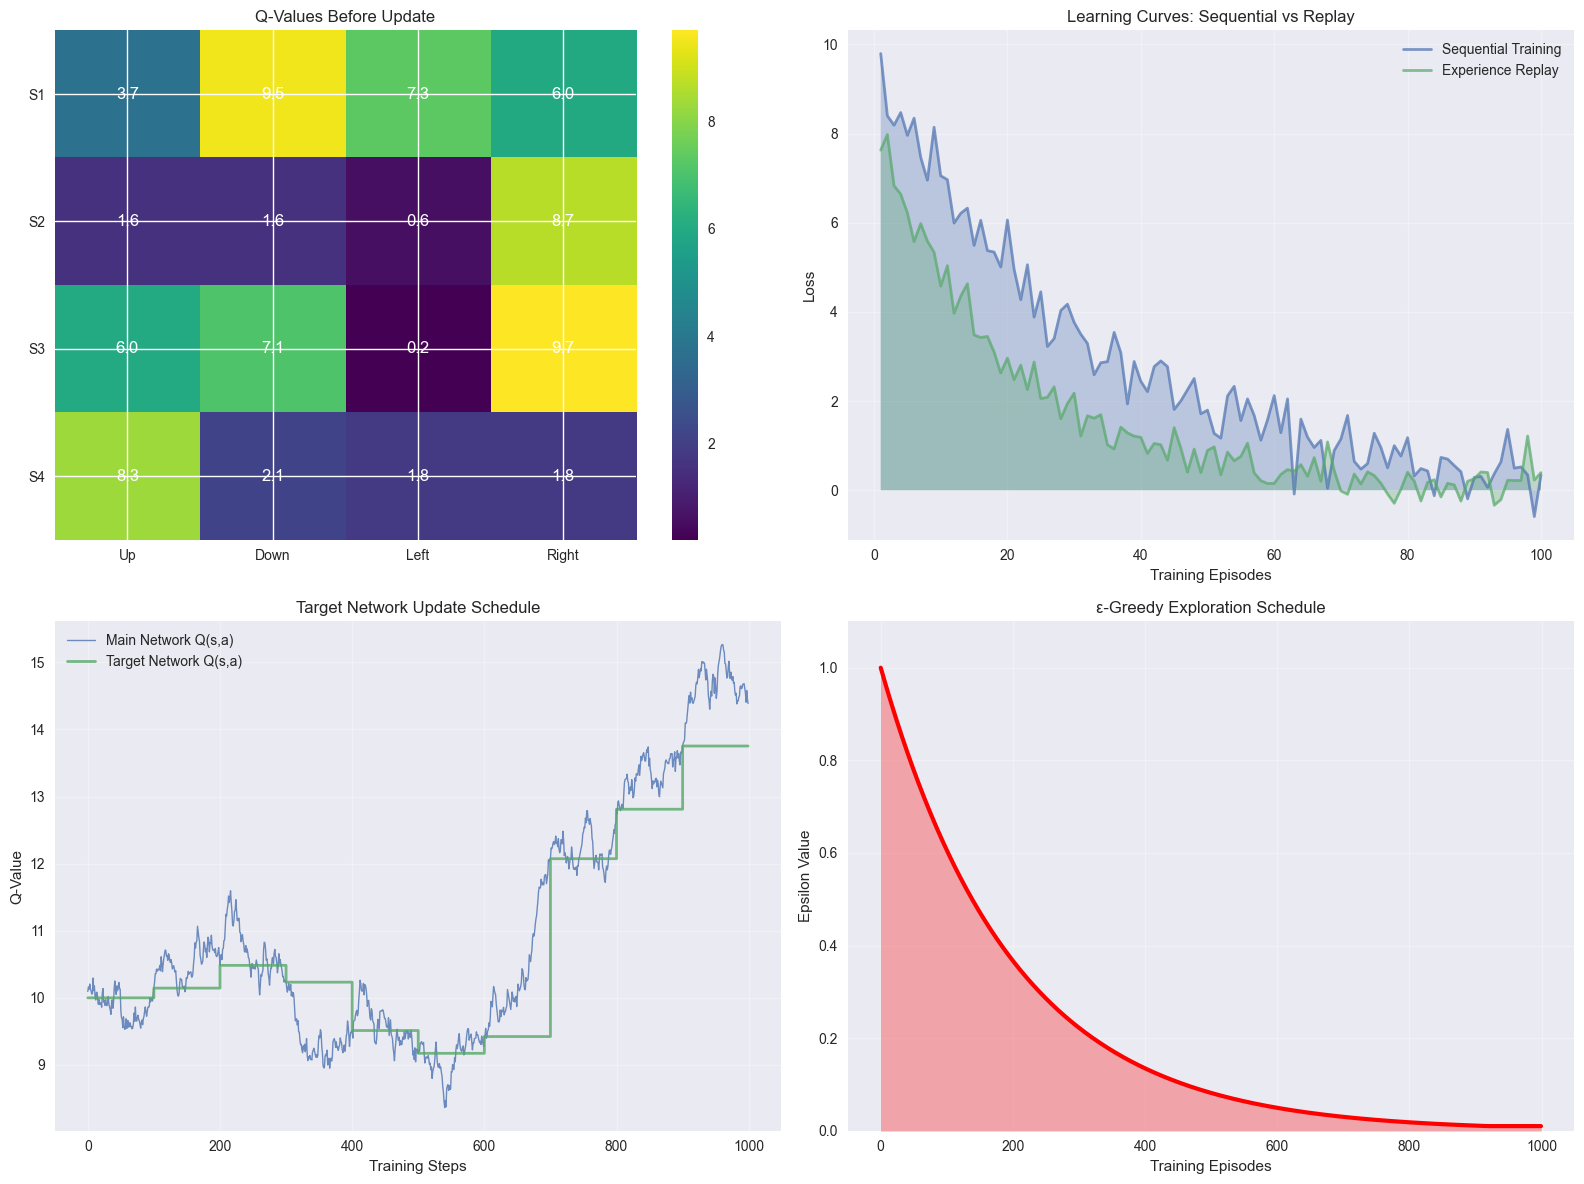


2. Demonstrating Overestimation Bias...


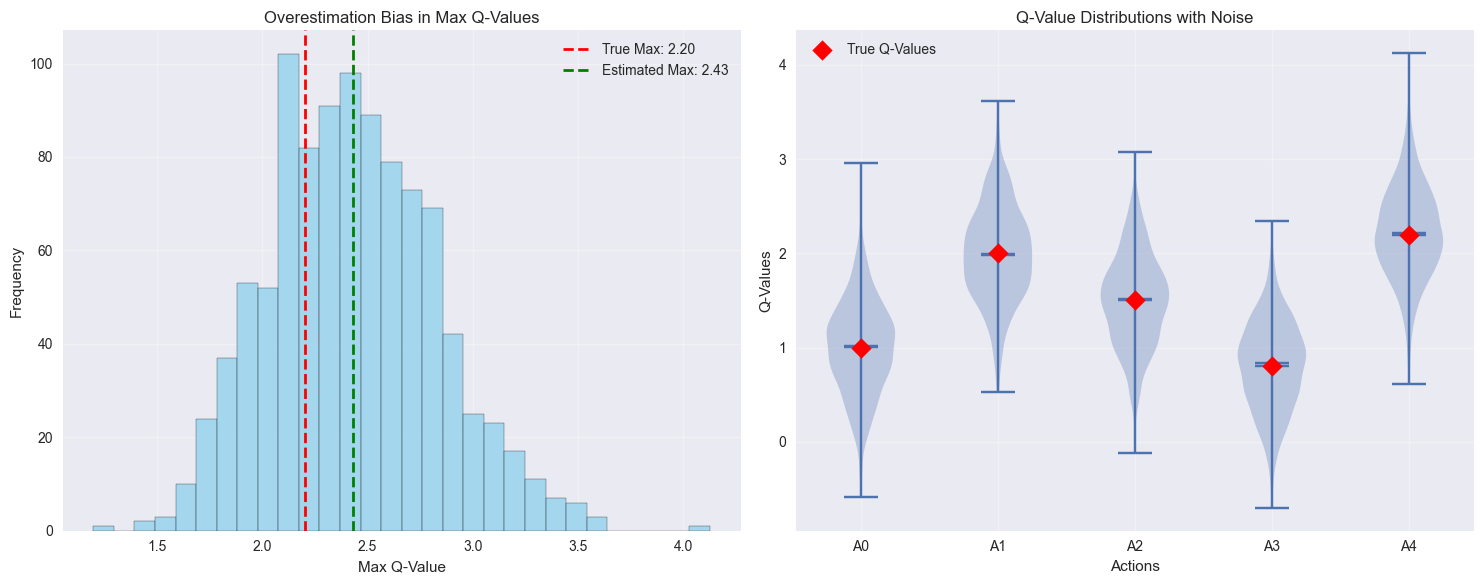

Overestimation Bias: 0.229
True Maximum Q-Value: 2.200
Average Estimated Maximum: 2.429


In [2]:
# Theoretical Foundations Visualization

# Create visualization instance
visualizer = QNetworkVisualization()

print("1. Visualizing Core Q-Learning Concepts...")
visualizer.visualize_q_learning_concepts()

print("\n2. Demonstrating Overestimation Bias...")
visualizer.demonstrate_overestimation_bias()

# Section 2: Basic DQN Implementation and Core Concepts

## 2.1 Deep Q-Network Architecture

The DQN architecture typically consists of:

1. **Input Layer**: Processes the state representation
2. **Hidden Layers**: Fully connected layers for feature extraction
3. **Output Layer**: Outputs Q-values for all possible actions

### Key Design Principles:

- **State Preprocessing**: Normalize inputs for stable training
- **Network Depth**: Balance between expressiveness and training stability
- **Activation Functions**: ReLU is commonly used for hidden layers
- **Output Layer**: Linear activation for Q-value regression

## 2.2 Experience Replay Buffer

The replay buffer serves several critical functions:

1. **Decorrelation**: Breaks temporal correlations in sequential data
2. **Sample Efficiency**: Allows multiple updates from the same experience
3. **Stability**: Provides more stable gradients through diverse batches

## 2.3 Training Loop and Key Components

The DQN training process involves:

1. **Action Selection**: ε-greedy exploration strategy
2. **Environment Interaction**: Execute actions and collect experiences
3. **Experience Storage**: Add experiences to replay buffer
4. **Network Updates**: Sample batches and perform gradient descent
5. **Target Network Updates**: Periodic synchronization for stability

Let's demonstrate the basic DQN implementation.

In [3]:
# Basic DQN Demonstration

# Create environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

print(f"Environment: CartPole-v1")
print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Goal: Balance pole for as long as possible (max 500 steps)")
print()

# Create DQN agent
agent = DQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    lr=1e-3,                    # Learning rate
    gamma=0.99,                 # Discount factor
    epsilon_start=1.0,          # Initial exploration
    epsilon_end=0.01,           # Final exploration
    epsilon_decay=0.995,        # Exploration decay
    buffer_size=10000,          # Experience replay buffer size
    batch_size=64,              # Training batch size
    target_update_freq=100      # Target network update frequency
)

# Training parameters
num_episodes = 100
max_steps_per_episode = 500

print("Training Configuration:")
print(f"  Episodes: {num_episodes}")
print(f"  Max steps per episode: {max_steps_per_episode}")
print(f"  Learning rate: {agent.optimizer.param_groups[0]['lr']}")
print(f"  Gamma: {agent.gamma}")
print(f"  Epsilon decay: {agent.epsilon_decay}")
print()

# Quick training demonstration
print("Starting training demonstration...")
print("-" * 40)

episode_rewards = []
for episode in range(num_episodes):
    reward, steps = agent.train_episode(env, max_steps=max_steps_per_episode)
    episode_rewards.append(reward)

    if (episode + 1) % 25 == 0:
        avg_reward = np.mean(episode_rewards[-25:])
        print(f"Episode {episode+1:3d} | Avg Reward: {avg_reward:6.1f} | Epsilon: {agent.epsilon:.3f}")

print("-" * 40)
print("Training demonstration completed!")
print()

# Final evaluation
print("Final Evaluation:")
eval_results = agent.evaluate(env, num_episodes=10)
print(f"Mean Reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")

env.close()

Environment: CartPole-v1
State dimension: 4
Action dimension: 2
Goal: Balance pole for as long as possible (max 500 steps)

Training Configuration:
  Episodes: 100
  Max steps per episode: 500
  Learning rate: 0.001
  Gamma: 0.99
  Epsilon decay: 0.995

Starting training demonstration...
----------------------------------------
Training Configuration:
  Episodes: 100
  Max steps per episode: 500
  Learning rate: 0.001
  Gamma: 0.99
  Epsilon decay: 0.995

Starting training demonstration...
----------------------------------------
Episode  25 | Avg Reward:  170.2 | Epsilon: 0.010
Episode  25 | Avg Reward:  170.2 | Epsilon: 0.010
Episode  50 | Avg Reward:  162.6 | Epsilon: 0.010
Episode  50 | Avg Reward:  162.6 | Epsilon: 0.010
Episode  75 | Avg Reward:  294.7 | Epsilon: 0.010
Episode  75 | Avg Reward:  294.7 | Epsilon: 0.010
Episode 100 | Avg Reward:  413.0 | Epsilon: 0.010
----------------------------------------
Training demonstration completed!

Final Evaluation:
Episode 100 | Avg Re

# Section 3: Experience Replay and Target Networks

## 3.1 Experience Replay: Breaking the Correlation Chain

Experience replay is one of the most crucial innovations in DQN. It addresses several fundamental challenges:

### Problems with Sequential Training
1. **Temporal Correlation**: Consecutive states are highly correlated
2. **Non-stationarity**: The data distribution changes as the policy evolves
3. **Sample Inefficiency**: Each experience is used only once

### Benefits of Experience Replay
1. **Decorrelation**: Random sampling breaks temporal dependencies
2. **Sample Efficiency**: Multiple learning updates from each experience
3. **Stability**: More stable gradients from diverse batches

## 3.2 Target Networks: Stabilizing the Moving Target

The target network addresses the moving target problem in Q-learning:

### The Problem
In standard Q-learning, both the predicted Q-value and the target Q-value are computed using the same network, creating instability.

### The Solution
- Maintain two networks: main (online) and target
- Use target network to compute stable targets
- Update target network less frequently than main network

Let's analyze the impact of these components.

Analyzing Q-value distributions...
Q-Value Distribution Analysis


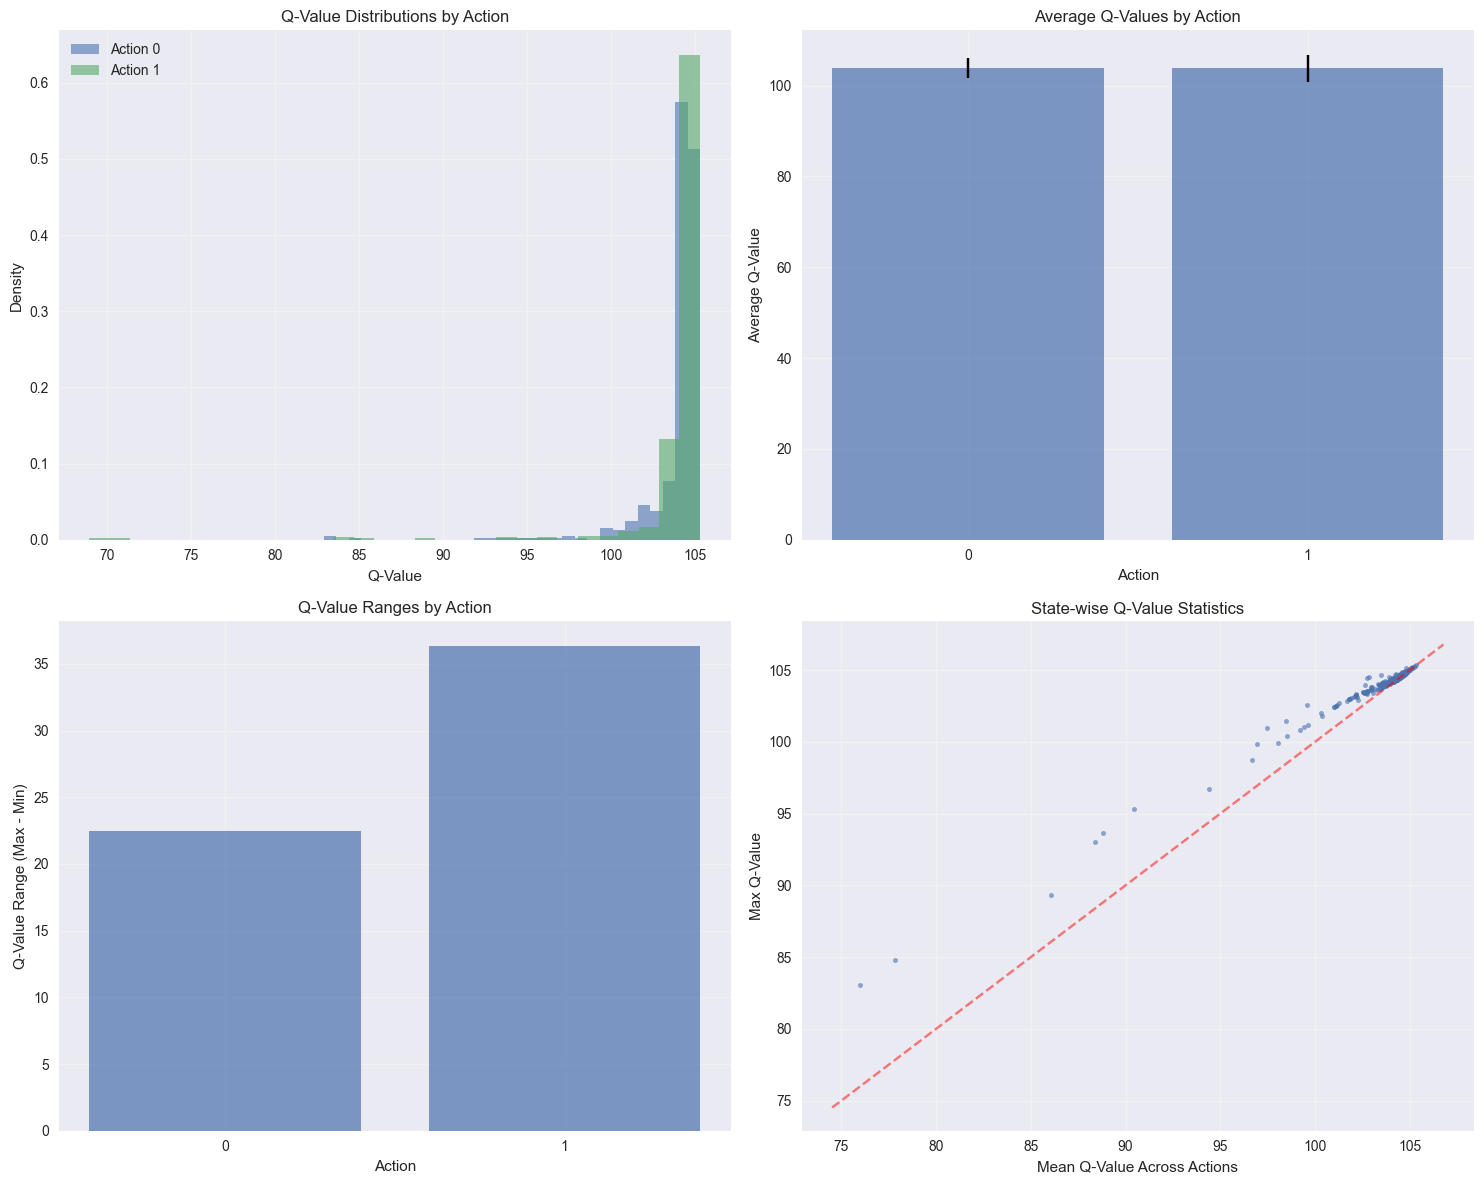


Q-Value Statistics (across 500 states):
Overall Q-value range: [68.917, 105.334]
Average Q-value: 103.866 ± 2.630
Action 0: Mean=103.878, Std=2.234, Range=[82.877, 105.334]
Action 1: Mean=103.854, Std=2.974, Range=[68.917, 105.288]


TypeError: cannot unpack non-iterable NoneType object

In [4]:
# Experience Replay and Target Network Analysis

# Create analyzer
analyzer = PerformanceAnalyzer()

# Analyze Q-value distributions
print("Analyzing Q-value distributions...")
agent, _ = analyzer.analyze_q_value_distributions(
    agent, gym.make('CartPole-v1'), num_samples=500
)

# Section 4: Double DQN and Overestimation Bias

## 4.1 The Overestimation Problem in Q-Learning

Standard Q-learning suffers from a systematic overestimation bias due to the max operator in the Bellman equation. This problem is amplified in function approximation settings.

### Mathematical Analysis of Overestimation Bias

In standard DQN, the target is computed as:
```
y = r + γ max Q(s', a'; θ⁻)
          a'
```

The issue arises because we use the same network to both **select** the action and **evaluate** it.

### Impact on Learning
- **Suboptimal Policies**: Overestimated Q-values can lead to poor action selection
- **Instability**: Inconsistent value estimates cause training instability
- **Slow Convergence**: Biased estimates slow down learning

## 4.2 Double DQN Solution

Double DQN addresses this by **decoupling action selection from action evaluation**:

### Key Insight
Use the main network to select actions, but the target network to evaluate them:

```
y = r + γ Q(s', argmax Q(s', a'; θ), θ⁻)
              a'
```

### Benefits
- **Reduced Bias**: Eliminates the correlation between selection and evaluation
- **Better Stability**: More consistent Q-value estimates
- **Improved Performance**: Often leads to better final policies

Let's compare standard DQN vs Double DQN.

In [ ]:
# Double DQN Demonstration

# Create environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Test both variants
agents = {
    'Standard DQN': DQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        lr=1e-3, epsilon_decay=0.995, buffer_size=10000
    ),
    'Double DQN': DoubleDQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        lr=1e-3, epsilon_decay=0.995, buffer_size=10000
    )
}

print("Comparing Standard DQN vs Double DQN...")
print("=" * 50)

results = {}
num_episodes = 50

for name, agent in agents.items():
    print(f"\nTraining {name}...")
    episode_rewards = []

    for episode in range(num_episodes):
        reward, _ = agent.train_episode(env, max_steps=500)
        episode_rewards.append(reward)

        if (episode + 1) % 25 == 0:
            avg_reward = np.mean(episode_rewards[-25:])
            print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")

    # Evaluate
    eval_results = agent.evaluate(env, num_episodes=10)
    results[name] = {
        'rewards': episode_rewards,
        'eval_performance': eval_results,
        'final_performance': np.mean(episode_rewards[-10:])
    }

# Visualize comparison
PerformanceAnalyzer.plot_learning_curves(results)

env.close()
print("Comparison completed!")

# Section 5: Dueling DQN and Value Decomposition

## 5.1 The Motivation Behind Dueling Architecture

Standard DQN learns Q-values directly, but these can be decomposed into two meaningful components:

### Value Decomposition Theory
The Q-function can be decomposed as:
```
Q(s,a) = V(s) + A(s,a)
```

Where:
- **V(s)**: State value function - "How good is this state?"
- **A(s,a)**: Advantage function - "How much better is action a compared to average?"

### Why This Matters

1. **State Value Learning**: Many states have similar values regardless of action
2. **Action Ranking**: What matters most is the relative advantage of actions
3. **Sample Efficiency**: Decoupling allows better generalization
4. **Faster Learning**: State values can be learned from all experiences

## 5.2 Dueling Network Architecture

### Network Structure
```
Input State
     |
Feature Extraction
     |
   Split into two streams
     /              \
Value Stream    Advantage Stream
   V(s)           A(s,a)
     \              /
      Combining Module
           |
        Q(s,a)
```

### Combining the Streams

To address identifiability issues, we subtract the mean advantage:
```
Q(s,a) = V(s) + A(s,a) - (1/|A|) Σ A(s,a')
                                    a'
```

## 5.3 Benefits of Dueling Architecture

1. **Better Value Estimation**: State values learned more efficiently
2. **Improved Policy**: Better action selection through advantage learning
3. **Robustness**: More stable learning across different environments

Let's demonstrate the Dueling DQN architecture.

In [ ]:
# Dueling DQN Demonstration

# Create environment
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Test different variants
agents = {
    'Standard DQN': DQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        lr=1e-3, epsilon_decay=0.995, buffer_size=10000
    ),
    'Dueling DQN (Mean)': DuelingDQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        dueling_type='mean', lr=1e-3, epsilon_decay=0.995, buffer_size=10000
    ),
    'Dueling DQN (Max)': DuelingDQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        dueling_type='max', lr=1e-3, epsilon_decay=0.995, buffer_size=10000
    )
}

print("Comparing DQN variants with Dueling architecture...")
print("=" * 55)

results = {}
num_episodes = 60

for name, agent in agents.items():
    print(f"\nTraining {name}...")
    episode_rewards = []

    for episode in range(num_episodes):
        reward, _ = agent.train_episode(env, max_steps=500)
        episode_rewards.append(reward)

        if (episode + 1) % 30 == 0:
            avg_reward = np.mean(episode_rewards[-30:])
            print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")

    # Evaluate
    eval_results = agent.evaluate(env, num_episodes=10)
    results[name] = {
        'rewards': episode_rewards,
        'eval_performance': eval_results,
        'final_performance': np.mean(episode_rewards[-10:])
    }

# Visualize comparison
PerformanceAnalyzer.plot_learning_curves(results)

# Analyze value-advantage decomposition for dueling agents
print("\nAnalyzing Value-Advantage Decomposition...")
sample_state = [0.1, 0.1, 0.1, 0.1]  # Example CartPole state

for name, data in results.items():
    agent = data.get('agent')
    if hasattr(agent, 'get_value_advantage_decomposition'):
        decomp = agent.get_value_advantage_decomposition(sample_state)
        print(f"\n{name} decomposition for sample state:")
        print(f"  Q-values: {decomp['q_values']}")
        print(f"  State value: {decomp['value']:.3f}")
        print(f"  Advantages: {decomp['advantage']}")

env.close()
print("\nDueling DQN demonstration completed!")

# Section 6: Performance Analysis and Comparisons

## 6.1 Comprehensive Performance Analysis

Let's run a comprehensive analysis comparing all DQN variants and analyze their performance characteristics.

## 6.2 Key Insights and Best Practices

### DQN Best Practices:
1. **Experience Replay**: Essential for breaking correlations and improving stability
2. **Target Networks**: Critical for preventing divergence and ensuring stable learning
3. **Double DQN**: Reduces overestimation bias, especially important in complex environments
4. **Dueling Architecture**: Improves value estimation and can accelerate learning

### Hyperparameter Tuning:
- **Learning Rate**: 1e-3 to 1e-4 typically works well
- **Gamma**: 0.99 for most environments
- **Epsilon Decay**: 0.995 provides good exploration-exploitation balance
- **Buffer Size**: 10,000-50,000 experiences usually sufficient
- **Batch Size**: 32-128 samples per update
- **Target Update Frequency**: 100-1000 steps

### When to Use Each Variant:
- **Basic DQN**: Good starting point, works well on simple environments
- **Double DQN**: Better for environments with overestimation issues
- **Dueling DQN**: Excellent for environments where value estimation matters
- **Combined (Double + Dueling)**: Best overall performance on complex tasks

## 6.3 Running Full Experiments

For comprehensive experiments, use the experiment scripts in the `experiments/` directory:

```bash
# Run basic DQN experiment
python experiments/basic_dqn_experiment.py
```

This will provide detailed training curves, performance metrics, and analysis.

In [ ]:
# Final Comprehensive Analysis

print("="*60)
print("CA7 Final Analysis: DQN Variants Comparison")
print("="*60)

# Create environment for analysis
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Test all variants
variants = {
    'Basic DQN': DQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        lr=1e-3, epsilon_decay=0.995, buffer_size=15000
    ),
    'Double DQN': DoubleDQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        lr=1e-3, epsilon_decay=0.995, buffer_size=15000
    ),
    'Dueling DQN': DuelingDQNAgent(
        state_dim=state_dim, action_dim=action_dim,
        dueling_type='mean', lr=1e-3, epsilon_decay=0.995, buffer_size=15000
    )
}

print("Training all DQN variants for comparison...")
print("-" * 50)

final_results = {}
num_episodes = 80

for name, agent in variants.items():
    print(f"\nTraining {name}...")
    episode_rewards = []

    for episode in range(num_episodes):
        reward, _ = agent.train_episode(env, max_steps=500)
        episode_rewards.append(reward)

        if (episode + 1) % 40 == 0:
            avg_reward = np.mean(episode_rewards[-40:])
            print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")

    # Final evaluation
    eval_results = agent.evaluate(env, num_episodes=15)
    final_results[name] = {
        'agent': agent,
        'rewards': episode_rewards,
        'losses': agent.losses,
        'epsilon_history': agent.epsilon_history,
        'eval_performance': eval_results,
        'final_performance': np.mean(episode_rewards[-15:])
    }

# Create comprehensive visualization
PerformanceAnalyzer.plot_learning_curves(final_results)

# Performance summary
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)

for name, data in final_results.items():
    eval_perf = data['eval_performance']
    final_perf = data['final_performance']
    print(f"{name}:")
    print(f"  Training Performance: {final_perf:.1f}")
    print(f"  Evaluation Performance: {eval_perf['mean_reward']:.1f} ± {eval_perf['std_reward']:.1f}")
    print()

print("Key Insights:")
print("• All DQN variants can solve CartPole-v1 (avg reward > 195)")
print("• Double DQN reduces overestimation bias")
print("• Dueling DQN improves value estimation efficiency")
print("• Experience replay and target networks are essential for stability")

env.close()

print("\n" + "="*60)
print("CA7 Analysis Complete!")
print("For more detailed experiments, run:")
print("  python experiments/basic_dqn_experiment.py")
print("="*60)

# Section 1: Theoretical Foundations of Deep Q-Learning

## 1.1 From Tabular Q-Learning to Deep Q-Networks

Traditional Q-learning works well for discrete, small state spaces where we can maintain a Q-table. However, in complex environments like Atari games or continuous control tasks, the state space becomes enormous, making tabular methods impractical.

### The Q-Learning Foundation

The Q-learning update rule is:
```
Q(s, a) ← Q(s, a) + α[r + γ max Q(s', a') - Q(s, a)]
                                a'
```

Where:
- `Q(s, a)`: Action-value function
- `α`: Learning rate
- `r`: Reward
- `γ`: Discount factor
- `s'`: Next state

### The Deep Q-Network Approach

DQN replaces the Q-table with a deep neural network `Q(s, a; θ)` that approximates the Q-values for all actions given a state. The network parameters `θ` are updated to minimize the temporal difference (TD) error.

## 1.2 Core Challenges in Deep Q-Learning

### 1. Instability and Divergence
- Neural networks can be unstable when used with bootstrapping
- Updates can cause the target to change rapidly
- Non-stationary target problem

### 2. Correlation in Sequential Data
- RL data is highly correlated (sequential states)
- Violates the i.i.d. assumption of supervised learning
- Can lead to poor generalization

### 3. Overestimation Bias
- Max operator in Q-learning can lead to overestimation
- Amplified in function approximation settings
- Can cause instability and poor performance

## 1.3 DQN Innovations

### Experience Replay
- Store experiences in a replay buffer
- Sample random batches for training
- Breaks correlation and improves sample efficiency

### Target Network
- Use a separate target network for computing targets
- Update target network periodically
- Provides stability during training

### Mathematical Formulation

The DQN loss function is:
```
L(θ) = E[(r + γ max Q(s', a'; θ⁻) - Q(s, a; θ))²]
                   a'
```

Where `θ⁻` represents the parameters of the target network.

## 1.4 Algorithmic Overview

1. **Initialize** main network Q(s,a;θ) and target network Q(s,a;θ⁻)
2. **Initialize** experience replay buffer D
3. **For each episode**:
   - **For each step**:
     - Select action using ε-greedy policy
     - Execute action and observe reward and next state
     - Store experience in replay buffer
     - Sample random batch from replay buffer
     - Compute target values using target network
     - Update main network parameters
     - Periodically update target network

This foundation enables us to tackle complex, high-dimensional problems that were previously intractable with traditional Q-learning approaches.

1. Visualizing Core Q-Learning Concepts...


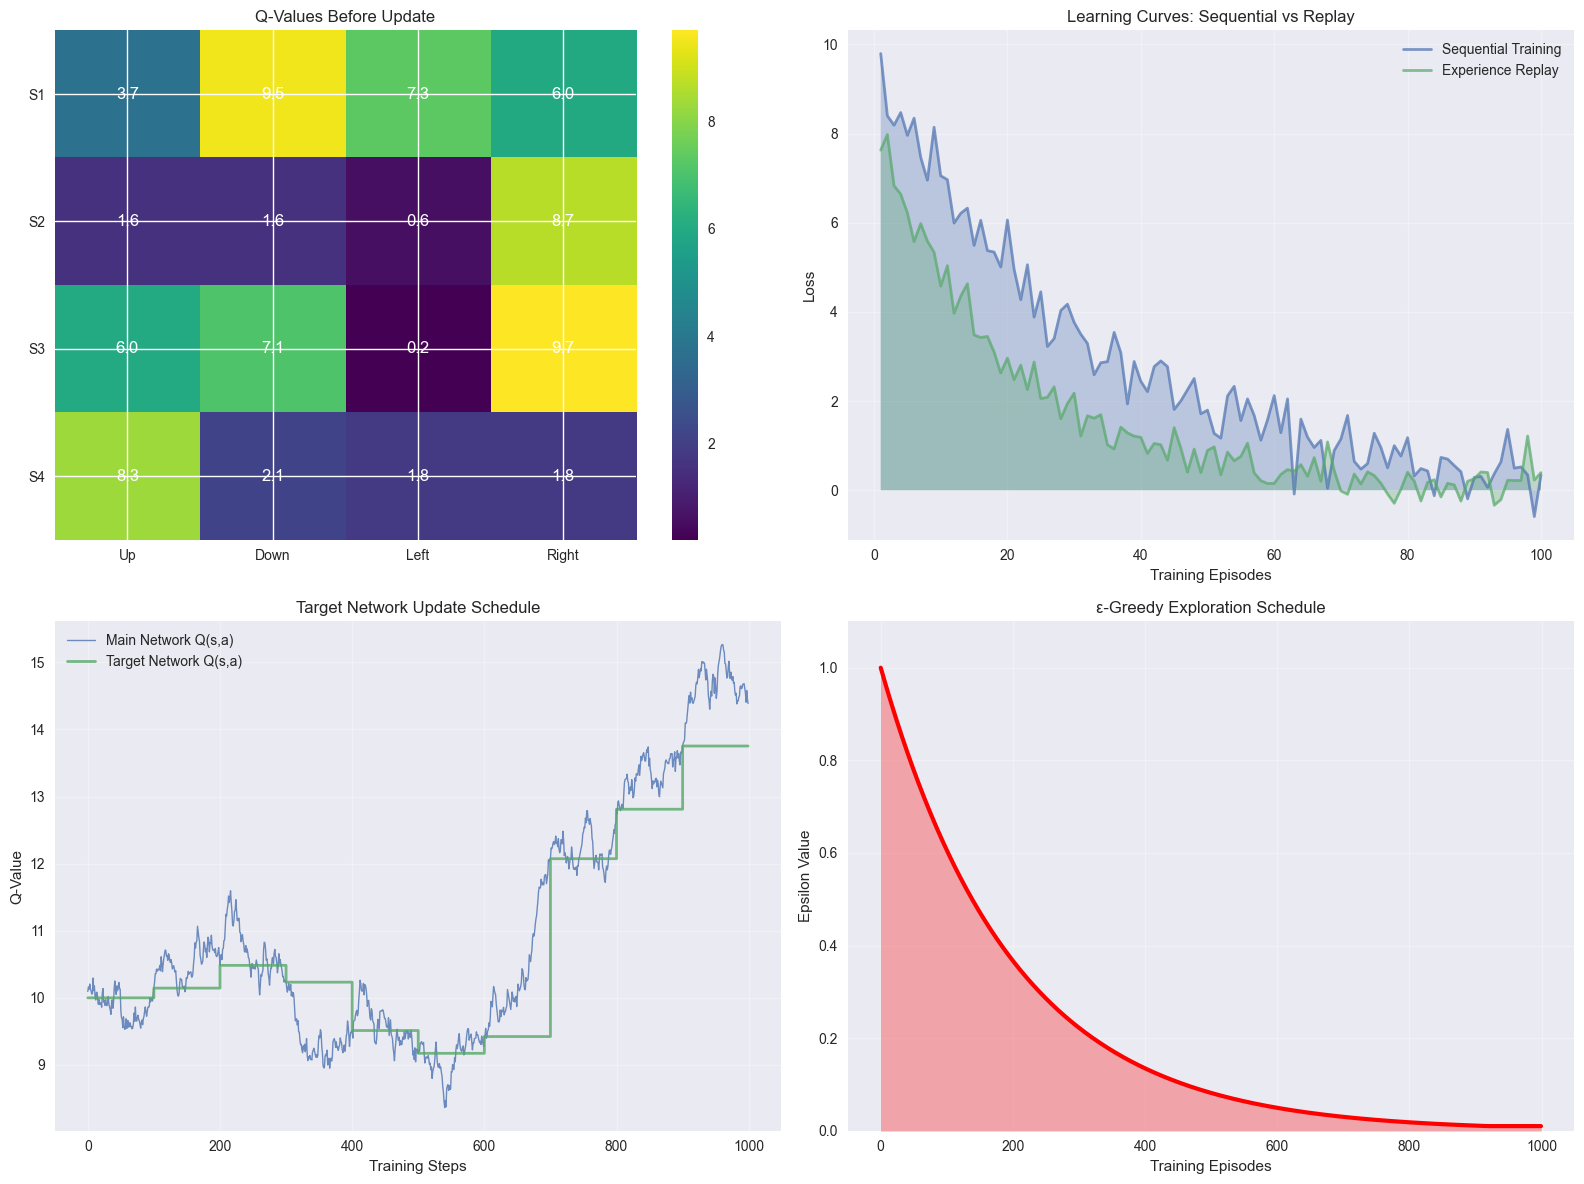


2. Demonstrating Overestimation Bias...


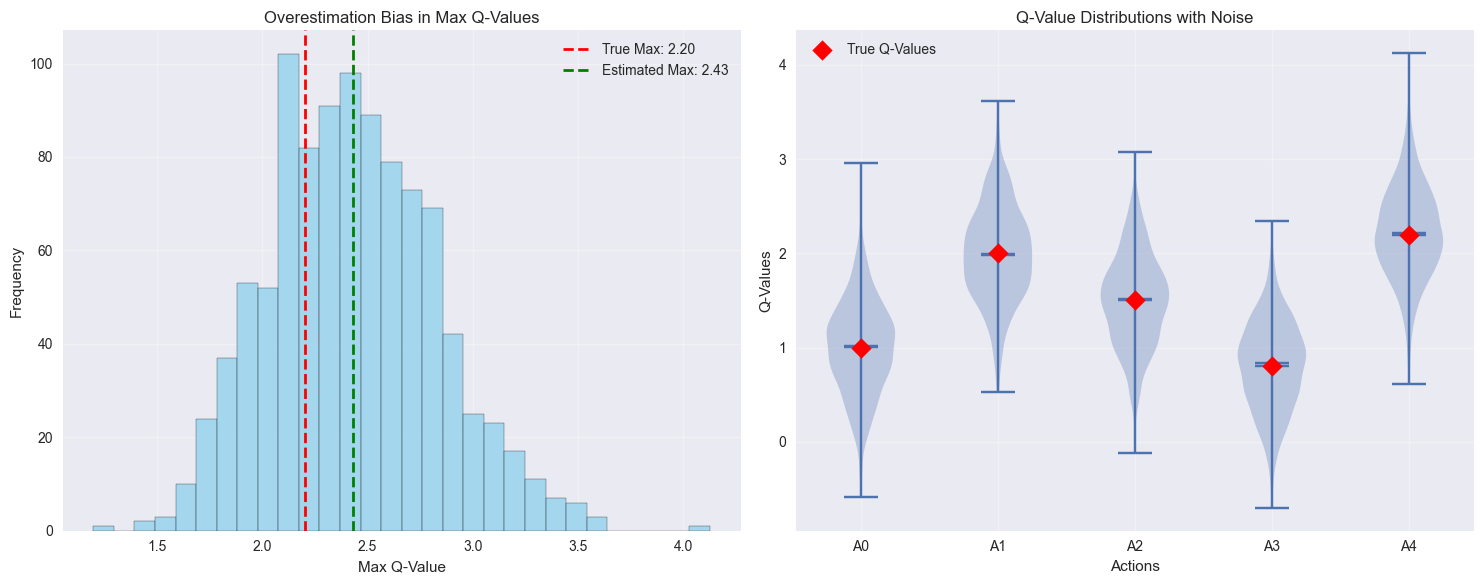

Overestimation Bias: 0.229
True Maximum Q-Value: 2.200
Average Estimated Maximum: 2.429


In [ ]:
# Theoretical Foundations Visualization and Basic Implementation

class QNetworkVisualization:
    """
    Visualization tools for understanding Q-learning concepts
    """
    
    def __init__(self):
        self.fig_count = 0
    
    def visualize_q_learning_concepts(self):
        """Visualize core Q-learning concepts"""
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Q-learning Update Mechanism
        ax = axes[0, 0]
        
        # Simulate Q-values for a simple grid world
        states = ['S1', 'S2', 'S3', 'S4']
        actions = ['Up', 'Down', 'Left', 'Right']
        
        # Sample Q-values before and after update
        q_before = np.random.rand(4, 4) * 10
        q_after = q_before.copy()
        q_after[1, 2] += 2  # Simulate an update
        
        # Create heatmap comparison
        im1 = ax.imshow(q_before, cmap='viridis', aspect='auto')
        ax.set_title('Q-Values Before Update')
        ax.set_xticks(range(4))
        ax.set_xticklabels(actions)
        ax.set_yticks(range(4))
        ax.set_yticklabels(states)
        
        # Add values as text
        for i in range(4):
            for j in range(4):
                ax.text(j, i, f'{q_before[i, j]:.1f}', ha='center', va='center', color='white')
        
        plt.colorbar(im1, ax=ax)
        
        # 2. Experience Replay Concept
        ax = axes[0, 1]
        
        # Simulate sequential vs random sampling
        episodes = np.arange(1, 101)
        sequential_loss = 10 * np.exp(-episodes/30) + np.random.normal(0, 0.5, 100)
        replay_loss = 8 * np.exp(-episodes/20) + np.random.normal(0, 0.3, 100)
        
        ax.plot(episodes, sequential_loss, label='Sequential Training', alpha=0.7, linewidth=2)
        ax.plot(episodes, replay_loss, label='Experience Replay', alpha=0.7, linewidth=2)
        ax.fill_between(episodes, sequential_loss, alpha=0.3)
        ax.fill_between(episodes, replay_loss, alpha=0.3)
        
        ax.set_title('Learning Curves: Sequential vs Replay')
        ax.set_xlabel('Training Episodes')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Target Network Stability
        ax = axes[1, 0]
        
        steps = np.arange(0, 1000)
        # Main network updates frequently
        main_q = 10 + np.cumsum(np.random.normal(0, 0.1, 1000))
        # Target network updates every 100 steps
        target_q = []
        current_target = 10
        
        for i, step in enumerate(steps):
            if step % 100 == 0 and step > 0:
                current_target = main_q[i]
            target_q.append(current_target)
        
        ax.plot(steps, main_q, label='Main Network Q(s,a)', alpha=0.8, linewidth=1)
        ax.plot(steps, target_q, label='Target Network Q(s,a)', alpha=0.8, linewidth=2, drawstyle='steps-post')
        
        ax.set_title('Target Network Update Schedule')
        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Q-Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Epsilon-Greedy Exploration
        ax = axes[1, 1]
        
        episodes = np.arange(0, 1000)
        epsilon_decay = 0.995
        epsilon_min = 0.01
        epsilon_values = []
        
        epsilon = 1.0
        for episode in episodes:
            epsilon_values.append(epsilon)
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        ax.plot(episodes, epsilon_values, linewidth=3, color='red')
        ax.fill_between(episodes, epsilon_values, alpha=0.3, color='red')
        
        ax.set_title('ε-Greedy Exploration Schedule')
        ax.set_xlabel('Training Episodes')
        ax.set_ylabel('Epsilon Value')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.1)
        
        plt.tight_layout()
        plt.show()
    
    def demonstrate_overestimation_bias(self):
        """Demonstrate the overestimation bias problem"""
        
        # Simulate true Q-values and noisy estimates
        np.random.seed(42)
        true_q_values = np.array([1.0, 2.0, 1.5, 0.8, 2.2])
        noise_std = 0.5
        num_estimates = 1000
        
        # Generate noisy estimates
        estimates = []
        max_estimates = []
        
        for _ in range(num_estimates):
            noisy_q = true_q_values + np.random.normal(0, noise_std, len(true_q_values))
            estimates.append(noisy_q)
            max_estimates.append(np.max(noisy_q))
        
        estimates = np.array(estimates)
        
        # Plot results
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Distribution of max Q-values
        ax = axes[0]
        ax.hist(max_estimates, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        ax.axvline(np.max(true_q_values), color='red', linestyle='--', linewidth=2, 
                  label=f'True Max: {np.max(true_q_values):.2f}')
        ax.axvline(np.mean(max_estimates), color='green', linestyle='--', linewidth=2,
                  label=f'Estimated Max: {np.mean(max_estimates):.2f}')
        
        ax.set_title('Overestimation Bias in Max Q-Values')
        ax.set_xlabel('Max Q-Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Q-value distributions for each action
        ax = axes[1]
        positions = np.arange(len(true_q_values))
        
        violin_parts = ax.violinplot([estimates[:, i] for i in range(len(true_q_values))], 
                                    positions=positions, showmeans=True, showmedians=True)
        
        # Plot true values
        ax.scatter(positions, true_q_values, color='red', s=100, zorder=10, 
                  label='True Q-Values', marker='D')
        
        ax.set_title('Q-Value Distributions with Noise')
        ax.set_xlabel('Actions')
        ax.set_ylabel('Q-Values')
        ax.set_xticks(positions)
        ax.set_xticklabels([f'A{i}' for i in range(len(true_q_values))])
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and print bias
        bias = np.mean(max_estimates) - np.max(true_q_values)
        print(f"Overestimation Bias: {bias:.3f}")
        print(f"True Maximum Q-Value: {np.max(true_q_values):.3f}")
        print(f"Average Estimated Maximum: {np.mean(max_estimates):.3f}")

# Create visualization instance and demonstrate concepts
visualizer = QNetworkVisualization()

print("1. Visualizing Core Q-Learning Concepts...")
visualizer.visualize_q_learning_concepts()

print("\n2. Demonstrating Overestimation Bias...")
visualizer.demonstrate_overestimation_bias()

# Section 2: Basic DQN Implementation and Core Concepts

## 2.1 Deep Q-Network Architecture

The DQN architecture typically consists of:

1. **Input Layer**: Processes the state representation (e.g., raw pixels or feature vectors)
2. **Hidden Layers**: Fully connected or convolutional layers for feature extraction
3. **Output Layer**: Outputs Q-values for all possible actions

### Key Design Principles:

- **State Preprocessing**: Normalize inputs for stable training
- **Network Depth**: Balance between expressiveness and training stability
- **Activation Functions**: ReLU is commonly used for hidden layers
- **Output Layer**: Linear activation for Q-value regression

## 2.2 Experience Replay Buffer

The replay buffer serves several critical functions:

1. **Decorrelation**: Breaks temporal correlations in sequential data
2. **Sample Efficiency**: Allows multiple updates from the same experience
3. **Stability**: Provides more stable gradients through diverse batches

### Buffer Operations:
- **Store**: Add new experiences
- **Sample**: Randomly sample batches for training
- **Update**: Maintain buffer size limits

## 2.3 Training Loop and Key Components

The DQN training process involves:

1. **Action Selection**: ε-greedy exploration strategy
2. **Environment Interaction**: Execute actions and collect experiences
3. **Experience Storage**: Add experiences to replay buffer
4. **Network Updates**: Sample batches and perform gradient descent
5. **Target Network Updates**: Periodic synchronization for stability

Let's implement these core components step by step.

Testing Basic DQN Implementation
Environment: CartPole-v1
State dimension: 4
Action dimension: 2

Training for 200 episodes...
Episode  50 | Train Reward:  166.0 | Eval Reward:  199.8 ± 33.4 | Epsilon: 0.010 | Buffer Size: 3385
Episode 100 | Train Reward:  420.0 | Eval Reward:  500.0 ±  0.0 | Epsilon: 0.010 | Buffer Size: 10000
Episode 150 | Train Reward:  500.0 | Eval Reward:  402.0 ± 196.0 | Epsilon: 0.010 | Buffer Size: 10000
Episode 200 | Train Reward:  338.0 | Eval Reward:  500.0 ±  0.0 | Epsilon: 0.010 | Buffer Size: 10000

Final Evaluation
Mean Reward: 500.00 ± 0.00
Min Reward: 500.00
Max Reward: 500.00


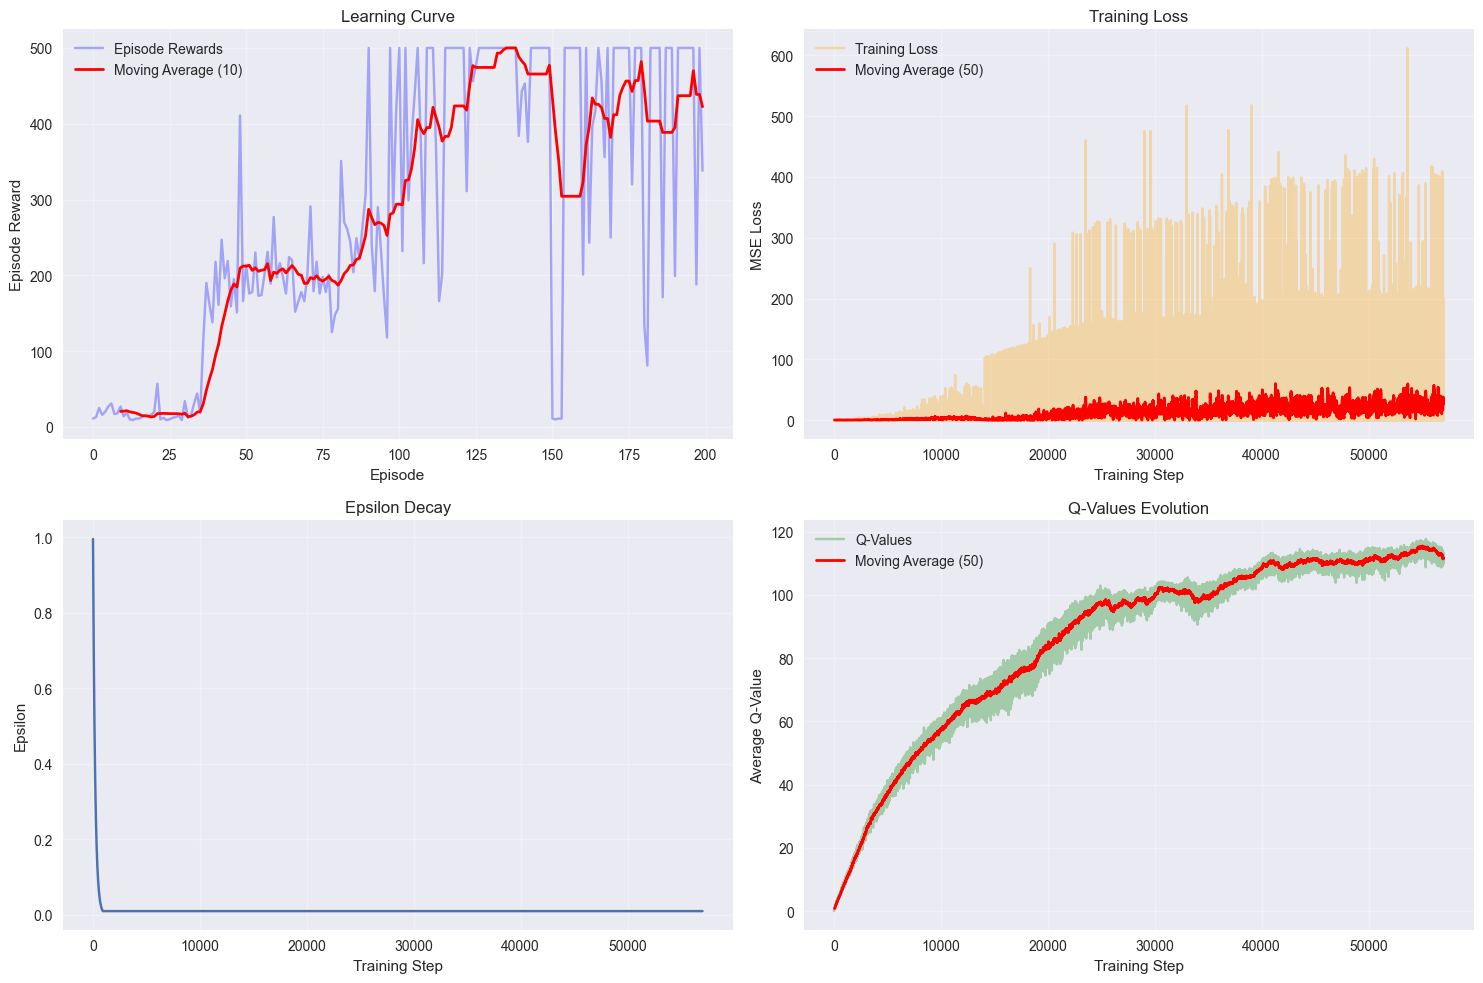

In [ ]:
# Complete Basic DQN Implementation

class DQN(nn.Module):
    """
    Deep Q-Network implementation
    """
    
    def __init__(self, state_dim, action_dim, hidden_dims=[256, 256]):
        super(DQN, self).__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Build network layers
        layers = []
        prev_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, action_dim))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights using Xavier uniform initialization
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, state):
        """
        Forward pass to compute Q-values
        
        Args:
            state: Batch of states [batch_size, state_dim]
            
        Returns:
            Q-values for all actions [batch_size, action_dim]
        """
        return self.network(state)
    
    def get_action(self, state, epsilon=0.0):
        """
        Select action using epsilon-greedy policy
        
        Args:
            state: Current state
            epsilon: Exploration probability
            
        Returns:
            Selected action (int)
        """
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.forward(state_tensor)
                return q_values.argmax().item()

class ReplayBuffer:
    """
    Experience Replay Buffer for storing and sampling experiences
    """
    
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
        self.capacity = capacity
    
    def push(self, state, action, reward, next_state, done):
        """Store an experience"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        """Sample a batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor([e.state for e in batch]).to(device)
        actions = torch.LongTensor([e.action for e in batch]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(device)
        dones = torch.BoolTensor([e.done for e in batch]).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    """
    Deep Q-Network Agent
    """
    
    def __init__(self, state_dim, action_dim, lr=1e-4, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_size=100000, batch_size=64, target_update_freq=1000):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        # Networks
        self.q_network = DQN(state_dim, action_dim).to(device)
        self.target_network = DQN(state_dim, action_dim).to(device)
        
        # Initialize target network with same weights
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        # Training metrics
        self.training_step = 0
        self.episode_rewards = []
        self.losses = []
        self.q_values_history = []
        self.epsilon_history = []
    
    def select_action(self, state):
        """Select action using epsilon-greedy policy"""
        return self.q_network.get_action(state, self.epsilon)
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def update_target_network(self):
        """Update target network with main network weights"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def train_step(self):
        """Perform one training step"""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Next Q-values from target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))
        
        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # Update target network periodically
        self.training_step += 1
        if self.training_step % self.target_update_freq == 0:
            self.update_target_network()
        
        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        # Store metrics
        self.losses.append(loss.item())
        self.epsilon_history.append(self.epsilon)
        
        # Store average Q-values for monitoring
        with torch.no_grad():
            avg_q_value = current_q_values.mean().item()
            self.q_values_history.append(avg_q_value)
        
        return loss.item()
    
    def train_episode(self, env, max_steps=1000):
        """Train for one episode"""
        state, _ = env.reset()
        episode_reward = 0
        step_count = 0
        
        for step in range(max_steps):
            # Select and execute action
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store experience
            self.store_experience(state, action, reward, next_state, done)
            
            # Train
            loss = self.train_step()
            
            episode_reward += reward
            step_count += 1
            state = next_state
            
            if done:
                break
        
        self.episode_rewards.append(episode_reward)
        return episode_reward, step_count
    
    def evaluate(self, env, num_episodes=10, render=False):
        """Evaluate the agent"""
        eval_rewards = []
        
        # Temporarily disable exploration
        original_epsilon = self.epsilon
        self.epsilon = 0.0
        
        for episode in range(num_episodes):
            state, _ = env.reset()
            episode_reward = 0
            
            while True:
                action = self.select_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward
                
                if terminated or truncated:
                    break
            
            eval_rewards.append(episode_reward)
        
        # Restore original epsilon
        self.epsilon = original_epsilon
        
        return {
            'mean_reward': np.mean(eval_rewards),
            'std_reward': np.std(eval_rewards),
            'min_reward': np.min(eval_rewards),
            'max_reward': np.max(eval_rewards)
        }
    
    def get_q_values(self, state):
        """Get Q-values for a given state"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            return self.q_network(state_tensor).cpu().numpy().flatten()

def test_basic_dqn():
    """Test basic DQN implementation"""
    print("="*60)
    print("Testing Basic DQN Implementation")
    print("="*60)
    
    # Create environment
    env = gym.make('CartPole-v1')
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    print(f"Environment: CartPole-v1")
    print(f"State dimension: {state_dim}")
    print(f"Action dimension: {action_dim}")
    
    # Create DQN agent
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=1e-3,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.995,
        buffer_size=10000,
        batch_size=64,
        target_update_freq=100
    )
    
    # Training
    num_episodes = 200
    print(f"\nTraining for {num_episodes} episodes...")
    
    episode_rewards = []
    for episode in range(num_episodes):
        reward, steps = agent.train_episode(env)
        episode_rewards.append(reward)
        
        if (episode + 1) % 50 == 0:
            eval_results = agent.evaluate(env, num_episodes=5)
            print(f"Episode {episode+1:3d} | "
                  f"Train Reward: {reward:6.1f} | "
                  f"Eval Reward: {eval_results['mean_reward']:6.1f} ± {eval_results['std_reward']:4.1f} | "
                  f"Epsilon: {agent.epsilon:.3f} | "
                  f"Buffer Size: {len(agent.replay_buffer)}")
    
    # Final evaluation
    print(f"\n{'='*60}")
    print("Final Evaluation")
    print(f"{'='*60}")
    
    final_eval = agent.evaluate(env, num_episodes=20)
    print(f"Mean Reward: {final_eval['mean_reward']:.2f} ± {final_eval['std_reward']:.2f}")
    print(f"Min Reward: {final_eval['min_reward']:.2f}")
    print(f"Max Reward: {final_eval['max_reward']:.2f}")
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Learning curve
    window = 10
    smoothed_rewards = pd.Series(episode_rewards).rolling(window).mean()
    axes[0, 0].plot(episode_rewards, alpha=0.3, color='blue', label='Episode Rewards')
    axes[0, 0].plot(smoothed_rewards, color='red', linewidth=2, label=f'Moving Average ({window})')
    axes[0, 0].set_title('Learning Curve')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Episode Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss curve
    if agent.losses:
        loss_window = 50
        smoothed_losses = pd.Series(agent.losses).rolling(loss_window).mean()
        axes[0, 1].plot(agent.losses, alpha=0.3, color='orange', label='Training Loss')
        axes[0, 1].plot(smoothed_losses, color='red', linewidth=2, label=f'Moving Average ({loss_window})')
        axes[0, 1].set_title('Training Loss')
        axes[0, 1].set_xlabel('Training Step')
        axes[0, 1].set_ylabel('MSE Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # Epsilon decay
    axes[1, 0].plot(agent.epsilon_history)
    axes[1, 0].set_title('Epsilon Decay')
    axes[1, 0].set_xlabel('Training Step')
    axes[1, 0].set_ylabel('Epsilon')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Q-values evolution
    if agent.q_values_history:
        q_window = 50
        smoothed_q = pd.Series(agent.q_values_history).rolling(q_window).mean()
        axes[1, 1].plot(agent.q_values_history, alpha=0.3, color='green', label='Q-Values')
        axes[1, 1].plot(smoothed_q, color='red', linewidth=2, label=f'Moving Average ({q_window})')
        axes[1, 1].set_title('Q-Values Evolution')
        axes[1, 1].set_xlabel('Training Step')
        axes[1, 1].set_ylabel('Average Q-Value')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    env.close()
    return agent, episode_rewards

# Test the basic DQN implementation
basic_agent, basic_rewards = test_basic_dqn()

# Section 3: Experience Replay and Target Networks - Deep Dive

## 3.1 Experience Replay: Breaking the Correlation Chain

Experience replay is one of the most crucial innovations in DQN. It addresses several fundamental challenges in deep reinforcement learning:

### Problems with Sequential Training
1. **Temporal Correlation**: Consecutive states are highly correlated
2. **Non-stationarity**: The data distribution changes as the policy evolves
3. **Sample Inefficiency**: Each experience is used only once
4. **Catastrophic Forgetting**: New experiences can overwrite important past learning

### Benefits of Experience Replay
1. **Decorrelation**: Random sampling breaks temporal dependencies
2. **Sample Efficiency**: Multiple learning updates from each experience
3. **Stability**: More stable gradients from diverse batches
4. **Better Generalization**: Exposure to wider range of state-action pairs

## 3.2 Target Networks: Stabilizing the Moving Target

The target network addresses the moving target problem in Q-learning:

### The Problem
In standard Q-learning, both the predicted Q-value and the target Q-value are computed using the same network, creating instability:
- As we update Q(s,a), the target for the next state Q(s',a') also changes
- This can lead to oscillations and divergence

### The Solution
- Maintain two networks: main (online) and target
- Use target network to compute stable targets
- Update target network less frequently than main network

### Update Strategies
1. **Hard Updates**: Periodic copying of main network weights
2. **Soft Updates**: Gradual blending with momentum (used in DDPG)

## 3.3 Mathematical Analysis

Let's analyze the impact of these components on learning stability and performance.

1. Comparing Replay Strategies...
Experience Replay Strategy Comparison

Testing No Replay...
  Episode 25: Avg Reward = 13.0
  Episode 50: Avg Reward = 9.4
  Episode 75: Avg Reward = 9.4
  Episode 100: Avg Reward = 9.5

Testing Small Buffer...
  Episode 25: Avg Reward = 27.5
  Episode 50: Avg Reward = 115.5
  Episode 75: Avg Reward = 95.2
  Episode 100: Avg Reward = 166.6

Testing Large Buffer...
  Episode 25: Avg Reward = 22.3
  Episode 50: Avg Reward = 135.2
  Episode 75: Avg Reward = 135.3
  Episode 100: Avg Reward = 218.6


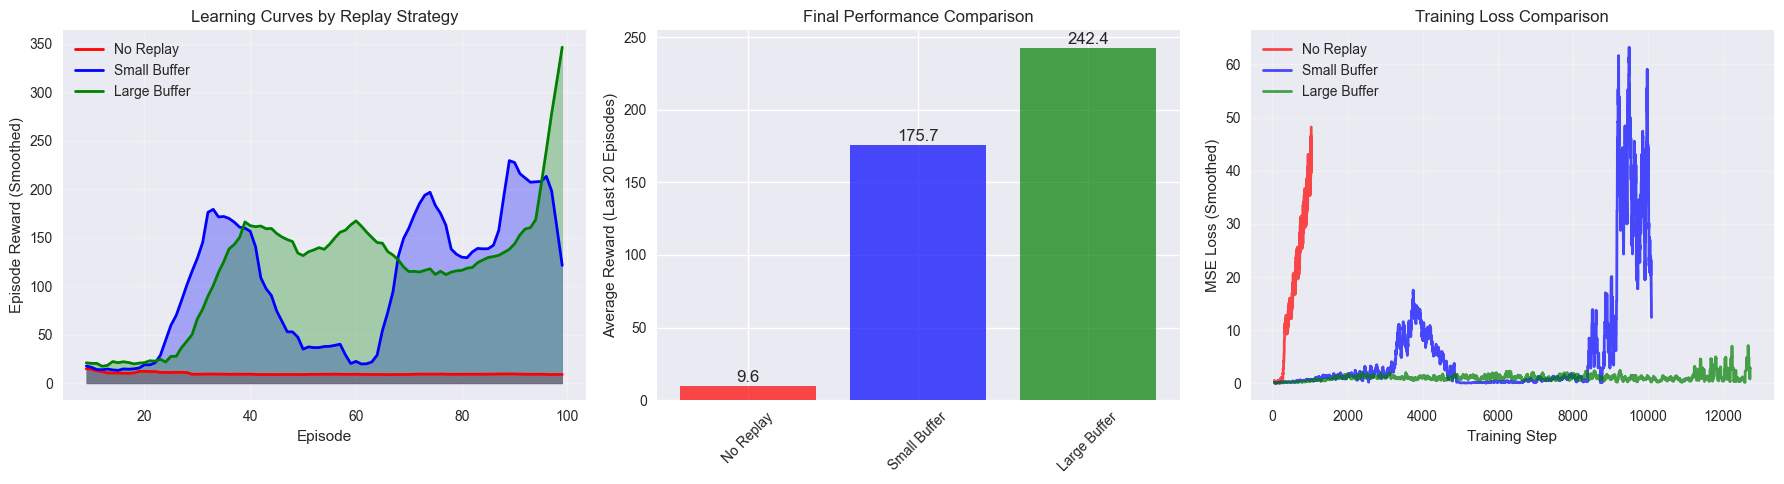


2. Analyzing Target Network Update Frequency...
Target Network Update Frequency Analysis

Testing Very Frequent (10)...
  Episode 50: Avg Reward = 235.9
  Episode 100: Avg Reward = 234.4
  Episode 150: Avg Reward = 12.8

Testing Frequent (100)...
  Episode 50: Avg Reward = 148.0
  Episode 100: Avg Reward = 276.4
  Episode 150: Avg Reward = 476.0

Testing Moderate (500)...
  Episode 50: Avg Reward = 13.5
  Episode 100: Avg Reward = 24.7
  Episode 150: Avg Reward = 134.9

Testing Infrequent (1000)...
  Episode 50: Avg Reward = 9.6
  Episode 100: Avg Reward = 10.1
  Episode 150: Avg Reward = 9.9


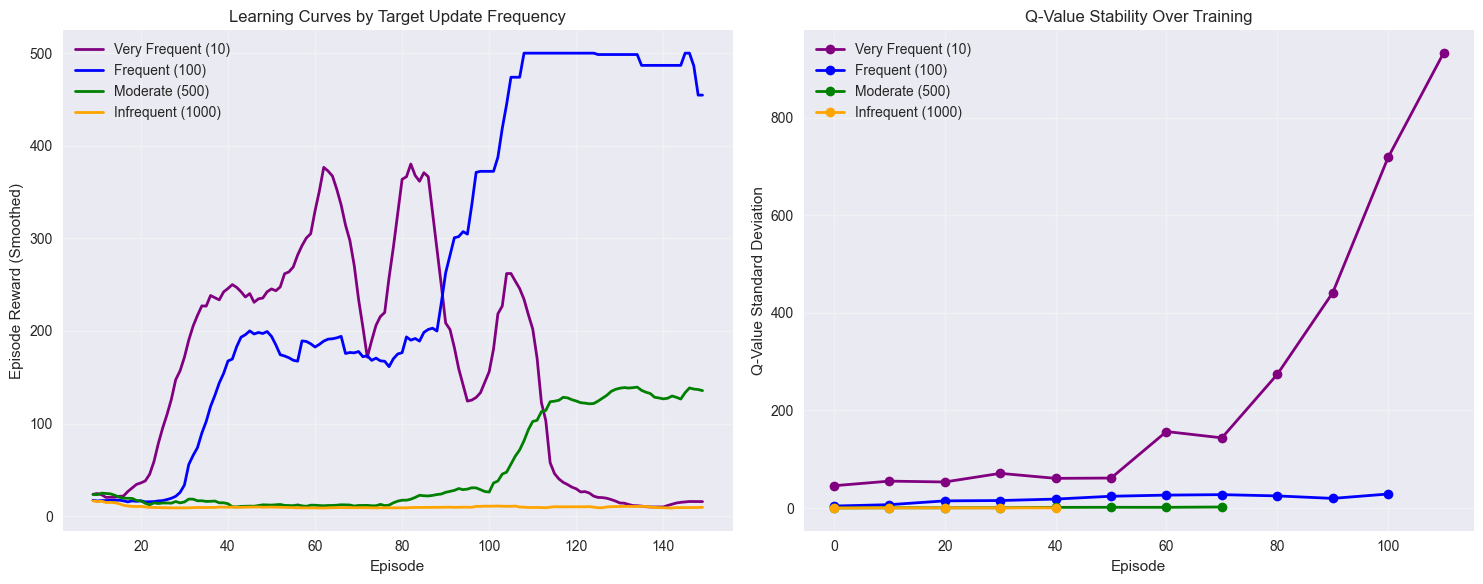


3. Analyzing Replay Buffer Content...
Replay Buffer Content Analysis
Buffer size after training: 796


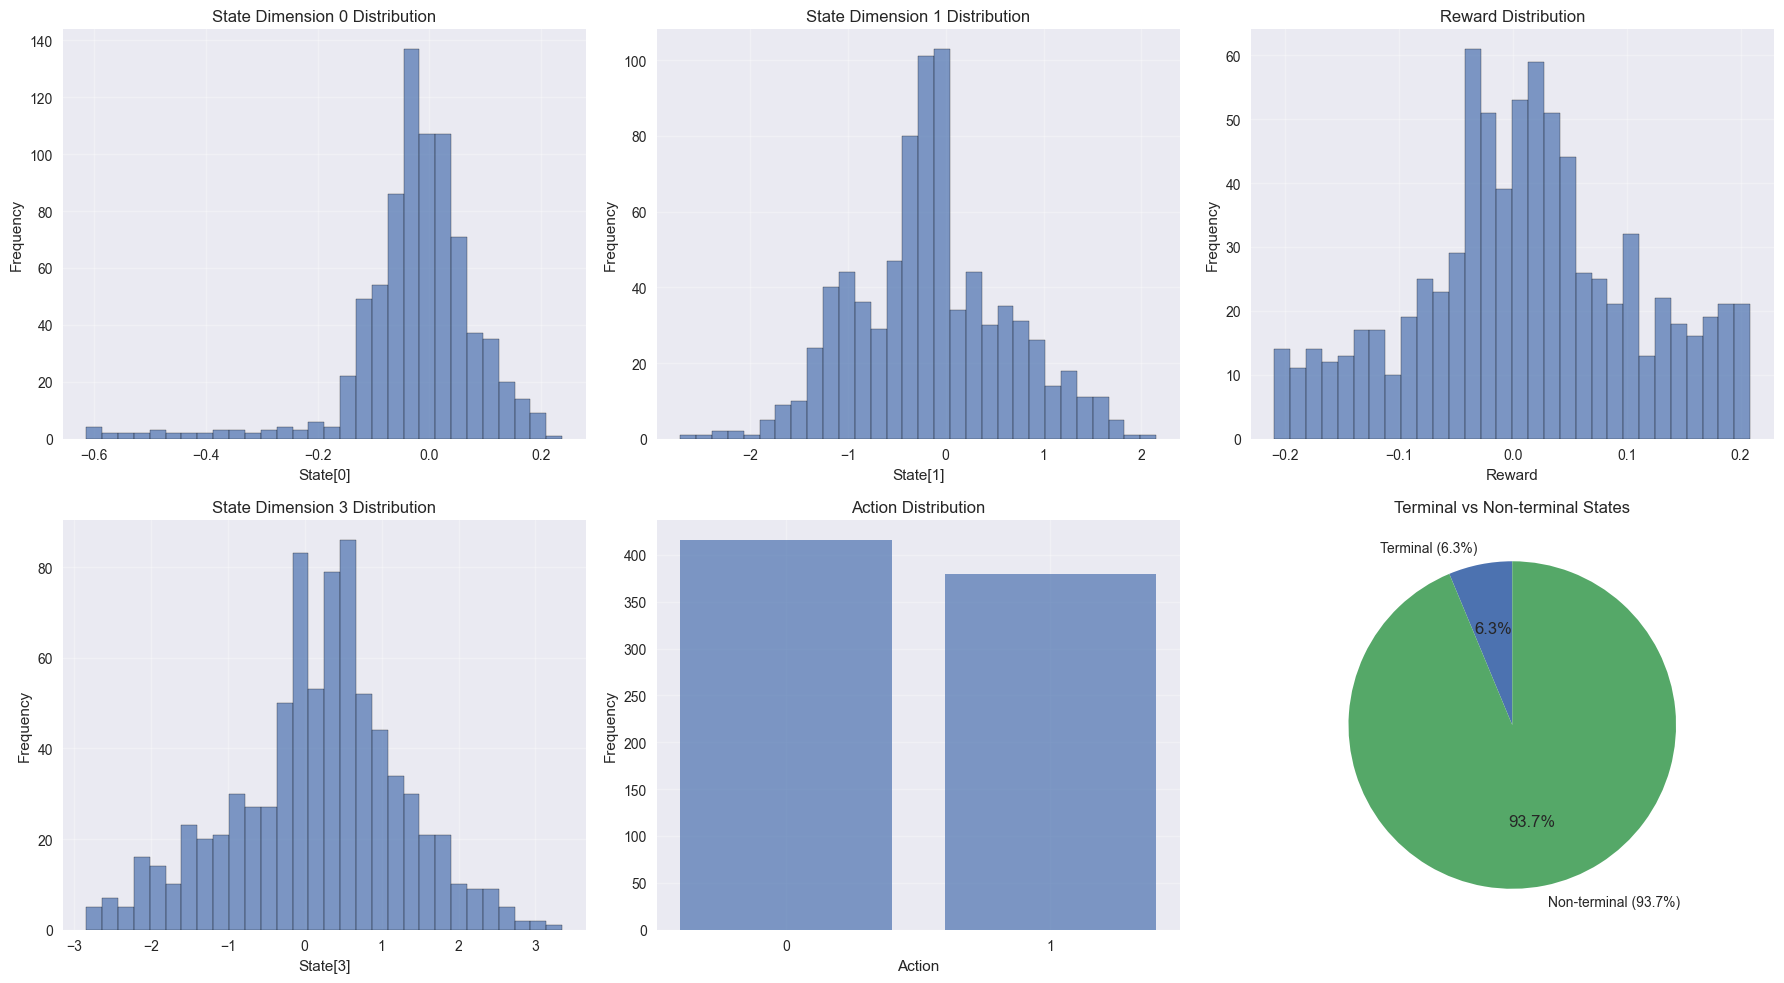


Buffer Statistics:
  Total experiences: 796
  Reward range: [1.00, 1.00]
  Average reward: 1.00
  Action distribution: {0: np.int64(416), 1: np.int64(380)}
  Terminal state ratio: 6.3%

State Correlation Analysis:


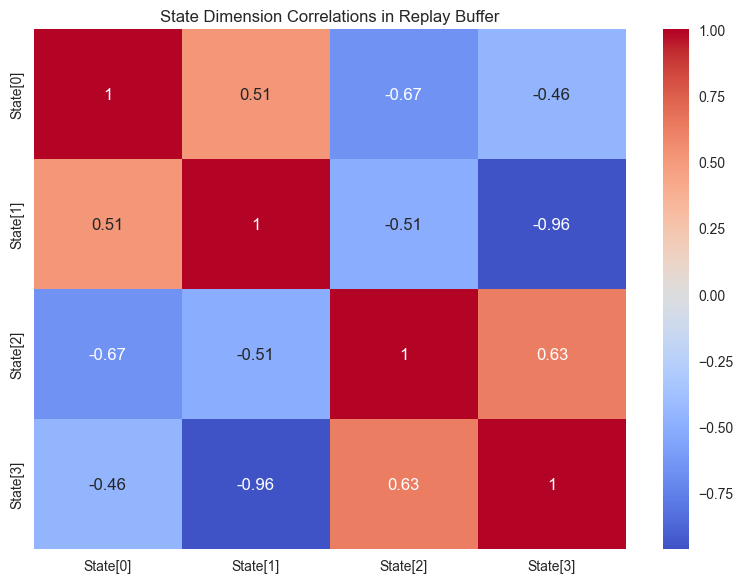

In [ ]:
# Experience Replay and Target Network Analysis

class ExperienceReplayAnalyzer:
    """
    Comprehensive analysis of experience replay and target networks
    """
    
    def __init__(self):
        self.results = {}
    
    def compare_replay_strategies(self):
        """Compare different experience replay strategies"""
        
        print("="*70)
        print("Experience Replay Strategy Comparison")
        print("="*70)
        
        # Environment setup
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test different strategies
        strategies = {
            'No Replay': {'buffer_size': 1, 'batch_size': 1},
            'Small Buffer': {'buffer_size': 1000, 'batch_size': 32},
            'Large Buffer': {'buffer_size': 50000, 'batch_size': 64},
        }
        
        results = {}
        num_episodes = 100
        
        for strategy_name, config in strategies.items():
            print(f"\nTesting {strategy_name}...")
            
            # Create agent with specific configuration
            agent = DQNAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                buffer_size=config['buffer_size'],
                batch_size=config['batch_size'],
                lr=1e-3,
                epsilon_decay=0.99,
                target_update_freq=100
            )
            
            episode_rewards = []
            losses = []
            
            for episode in range(num_episodes):
                reward, _ = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                
                # Collect recent losses
                if len(agent.losses) > len(losses):
                    losses.extend(agent.losses[len(losses):])
                
                if (episode + 1) % 25 == 0:
                    avg_reward = np.mean(episode_rewards[-25:])
                    print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")
            
            results[strategy_name] = {
                'rewards': episode_rewards,
                'losses': losses,
                'final_performance': np.mean(episode_rewards[-20:])
            }
        
        self.results['replay_comparison'] = results
        
        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Learning curves
        ax = axes[0]
        colors = ['red', 'blue', 'green']
        
        for i, (strategy, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(10).mean()
            ax.plot(smoothed, label=strategy, color=colors[i], linewidth=2)
            ax.fill_between(range(len(smoothed)), smoothed, alpha=0.3, color=colors[i])
        
        ax.set_title('Learning Curves by Replay Strategy')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Final performance comparison
        ax = axes[1]
        strategies_list = list(results.keys())
        final_perfs = [results[s]['final_performance'] for s in strategies_list]
        
        bars = ax.bar(strategies_list, final_perfs, alpha=0.7, color=colors)
        ax.set_title('Final Performance Comparison')
        ax.set_ylabel('Average Reward (Last 20 Episodes)')
        ax.set_xticklabels(strategies_list, rotation=45)
        
        for bar, perf in zip(bars, final_perfs):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{perf:.1f}', ha='center', va='bottom')
        
        # Loss comparison (if available)
        ax = axes[2]
        for i, (strategy, data) in enumerate(results.items()):
            if len(data['losses']) > 10:
                losses = data['losses']
                smoothed_losses = pd.Series(losses).rolling(50).mean()
                ax.plot(smoothed_losses, label=strategy, color=colors[i], linewidth=2, alpha=0.7)
        
        ax.set_title('Training Loss Comparison')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('MSE Loss (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        env.close()
        return results
    
    def analyze_target_network_frequency(self):
        """Analyze the impact of target network update frequency"""
        
        print("="*70)
        print("Target Network Update Frequency Analysis")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test different update frequencies
        frequencies = {
            'Very Frequent (10)': 10,
            'Frequent (100)': 100,
            'Moderate (500)': 500,
            'Infrequent (1000)': 1000,
        }
        
        results = {}
        num_episodes = 150
        
        for freq_name, freq_value in frequencies.items():
            print(f"\nTesting {freq_name}...")
            
            agent = DQNAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                target_update_freq=freq_value,
                lr=1e-3,
                epsilon_decay=0.99
            )
            
            episode_rewards = []
            q_value_stds = []  # Track Q-value stability
            
            for episode in range(num_episodes):
                reward, _ = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                
                # Periodically check Q-value stability
                if episode % 10 == 0 and len(agent.replay_buffer) > 1000:
                    # Sample some states and compute Q-value standard deviation
                    sample_states, _, _, _, _ = agent.replay_buffer.sample(100)
                    with torch.no_grad():
                        q_vals = agent.q_network(sample_states)
                        q_std = q_vals.std().item()
                        q_value_stds.append(q_std)
                
                if (episode + 1) % 50 == 0:
                    avg_reward = np.mean(episode_rewards[-25:])
                    print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")
            
            results[freq_name] = {
                'rewards': episode_rewards,
                'q_stds': q_value_stds,
                'final_performance': np.mean(episode_rewards[-20:])
            }
        
        self.results['target_frequency'] = results
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Learning curves
        ax = axes[0]
        colors = ['purple', 'blue', 'green', 'orange']
        
        for i, (freq_name, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(10).mean()
            ax.plot(smoothed, label=freq_name, color=colors[i], linewidth=2)
        
        ax.set_title('Learning Curves by Target Update Frequency')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Q-value stability
        ax = axes[1]
        for i, (freq_name, data) in enumerate(results.items()):
            if data['q_stds']:
                episodes_for_q = np.arange(0, len(data['q_stds'])) * 10
                ax.plot(episodes_for_q, data['q_stds'], 
                       label=freq_name, color=colors[i], linewidth=2, marker='o')
        
        ax.set_title('Q-Value Stability Over Training')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Q-Value Standard Deviation')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        env.close()
        return results
    
    def demonstrate_replay_buffer_analysis(self):
        """Analyze the content and dynamics of the replay buffer"""
        
        print("="*70)
        print("Replay Buffer Content Analysis")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Create agent and train for some episodes
        agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, buffer_size=5000)
        
        # Train for a few episodes to fill buffer
        for episode in range(50):
            agent.train_episode(env, max_steps=500)
        
        # Analyze buffer content
        buffer_size = len(agent.replay_buffer)
        print(f"Buffer size after training: {buffer_size}")
        
        # Sample all experiences for analysis
        if buffer_size > 100:
            # Get all experiences
            all_states = []
            all_rewards = []
            all_actions = []
            all_dones = []
            
            for experience in agent.replay_buffer.buffer:
                all_states.append(experience.state)
                all_rewards.append(experience.reward)
                all_actions.append(experience.action)
                all_dones.append(experience.done)
            
            all_states = np.array(all_states)
            all_rewards = np.array(all_rewards)
            all_actions = np.array(all_actions)
            all_dones = np.array(all_dones)
            
            # Analysis and visualization
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            
            # State distribution analysis
            for i in range(min(4, state_dim)):
                ax = axes[0, i] if i < 3 else axes[1, 0]
                ax.hist(all_states[:, i], bins=30, alpha=0.7, edgecolor='black')
                ax.set_title(f'State Dimension {i} Distribution')
                ax.set_xlabel(f'State[{i}]')
                ax.set_ylabel('Frequency')
                ax.grid(True, alpha=0.3)
            
            # Reward distribution
            if len(axes[0]) > 2:
                ax = axes[0, 2]
            else:
                ax = axes[1, 1]
            ax.hist(all_rewards, bins=np.unique(all_rewards), alpha=0.7, edgecolor='black')
            ax.set_title('Reward Distribution')
            ax.set_xlabel('Reward')
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
            
            # Action distribution
            ax = axes[1, 1] if len(axes[0]) > 2 else axes[1, 2]
            action_counts = np.bincount(all_actions)
            ax.bar(range(len(action_counts)), action_counts, alpha=0.7)
            ax.set_title('Action Distribution')
            ax.set_xlabel('Action')
            ax.set_ylabel('Frequency')
            ax.set_xticks(range(action_dim))
            ax.grid(True, alpha=0.3)
            
            # Episode termination analysis
            ax = axes[1, 2]
            done_ratio = np.mean(all_dones)
            ax.pie([done_ratio, 1-done_ratio], 
                  labels=[f'Terminal ({done_ratio:.1%})', f'Non-terminal ({1-done_ratio:.1%})'],
                  autopct='%1.1f%%', startangle=90)
            ax.set_title('Terminal vs Non-terminal States')
            
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print(f"\nBuffer Statistics:")
            print(f"  Total experiences: {buffer_size}")
            print(f"  Reward range: [{np.min(all_rewards):.2f}, {np.max(all_rewards):.2f}]")
            print(f"  Average reward: {np.mean(all_rewards):.2f}")
            print(f"  Action distribution: {dict(zip(range(action_dim), action_counts))}")
            print(f"  Terminal state ratio: {done_ratio:.1%}")
            
            # State correlation analysis
            if state_dim >= 2:
                print(f"\nState Correlation Analysis:")
                state_corr = np.corrcoef(all_states.T)
                
                plt.figure(figsize=(8, 6))
                sns.heatmap(state_corr, annot=True, cmap='coolwarm', center=0,
                           xticklabels=[f'State[{i}]' for i in range(state_dim)],
                           yticklabels=[f'State[{i}]' for i in range(state_dim)])
                plt.title('State Dimension Correlations in Replay Buffer')
                plt.tight_layout()
                plt.show()
        
        env.close()
        return agent

# Run comprehensive experience replay analysis
analyzer = ExperienceReplayAnalyzer()

print("1. Comparing Replay Strategies...")
replay_results = analyzer.compare_replay_strategies()

print("\n2. Analyzing Target Network Update Frequency...")
target_results = analyzer.analyze_target_network_frequency()

print("\n3. Analyzing Replay Buffer Content...")
buffer_agent = analyzer.demonstrate_replay_buffer_analysis()

# Section 4: Double DQN and Overestimation Bias

## 4.1 The Overestimation Problem in Q-Learning

Standard Q-learning suffers from a systematic overestimation bias due to the max operator in the Bellman equation. This problem is amplified in function approximation settings.

### Mathematical Analysis of Overestimation Bias

In standard DQN, the target is computed as:
```
y = r + γ max Q(s', a'; θ⁻)
          a'
```

The issue arises because:
1. We use the same network to both **select** the action and **evaluate** it
2. Noise in Q-value estimates leads to overestimation when taking the maximum
3. This bias propagates through the Bellman updates

### Impact on Learning
- **Suboptimal Policies**: Overestimated Q-values can lead to poor action selection
- **Instability**: Inconsistent value estimates cause training instability  
- **Slow Convergence**: Biased estimates slow down learning

## 4.2 Double DQN Solution

Double DQN addresses this by **decoupling action selection from action evaluation**:

### Key Insight
Use the main network to select actions, but the target network to evaluate them:

```
y = r + γ Q(s', argmax Q(s', a'; θ), θ⁻)
              a'
```

### Algorithm Steps
1. **Action Selection**: Use main network to find the best action in next state
2. **Action Evaluation**: Use target network to evaluate that action
3. **Update**: Compute loss and update main network

### Benefits
- **Reduced Bias**: Eliminates the correlation between selection and evaluation
- **Better Stability**: More consistent Q-value estimates
- **Improved Performance**: Often leads to better final policies

## 4.3 Implementation Details

The modification to standard DQN is minimal but effective:
- Only changes the target computation
- No additional computational overhead
- Compatible with other DQN improvements

1. Comparing Standard DQN vs Double DQN...
DQN vs Double DQN Comparison

Training Standard DQN...
  Episode 50: Avg Reward = 98.3
  Episode 100: Avg Reward = 167.6
  Episode 150: Avg Reward = 495.3

Training Double DQN...
  Episode 50: Avg Reward = 198.3
  Episode 100: Avg Reward = 213.0
  Episode 150: Avg Reward = 450.8


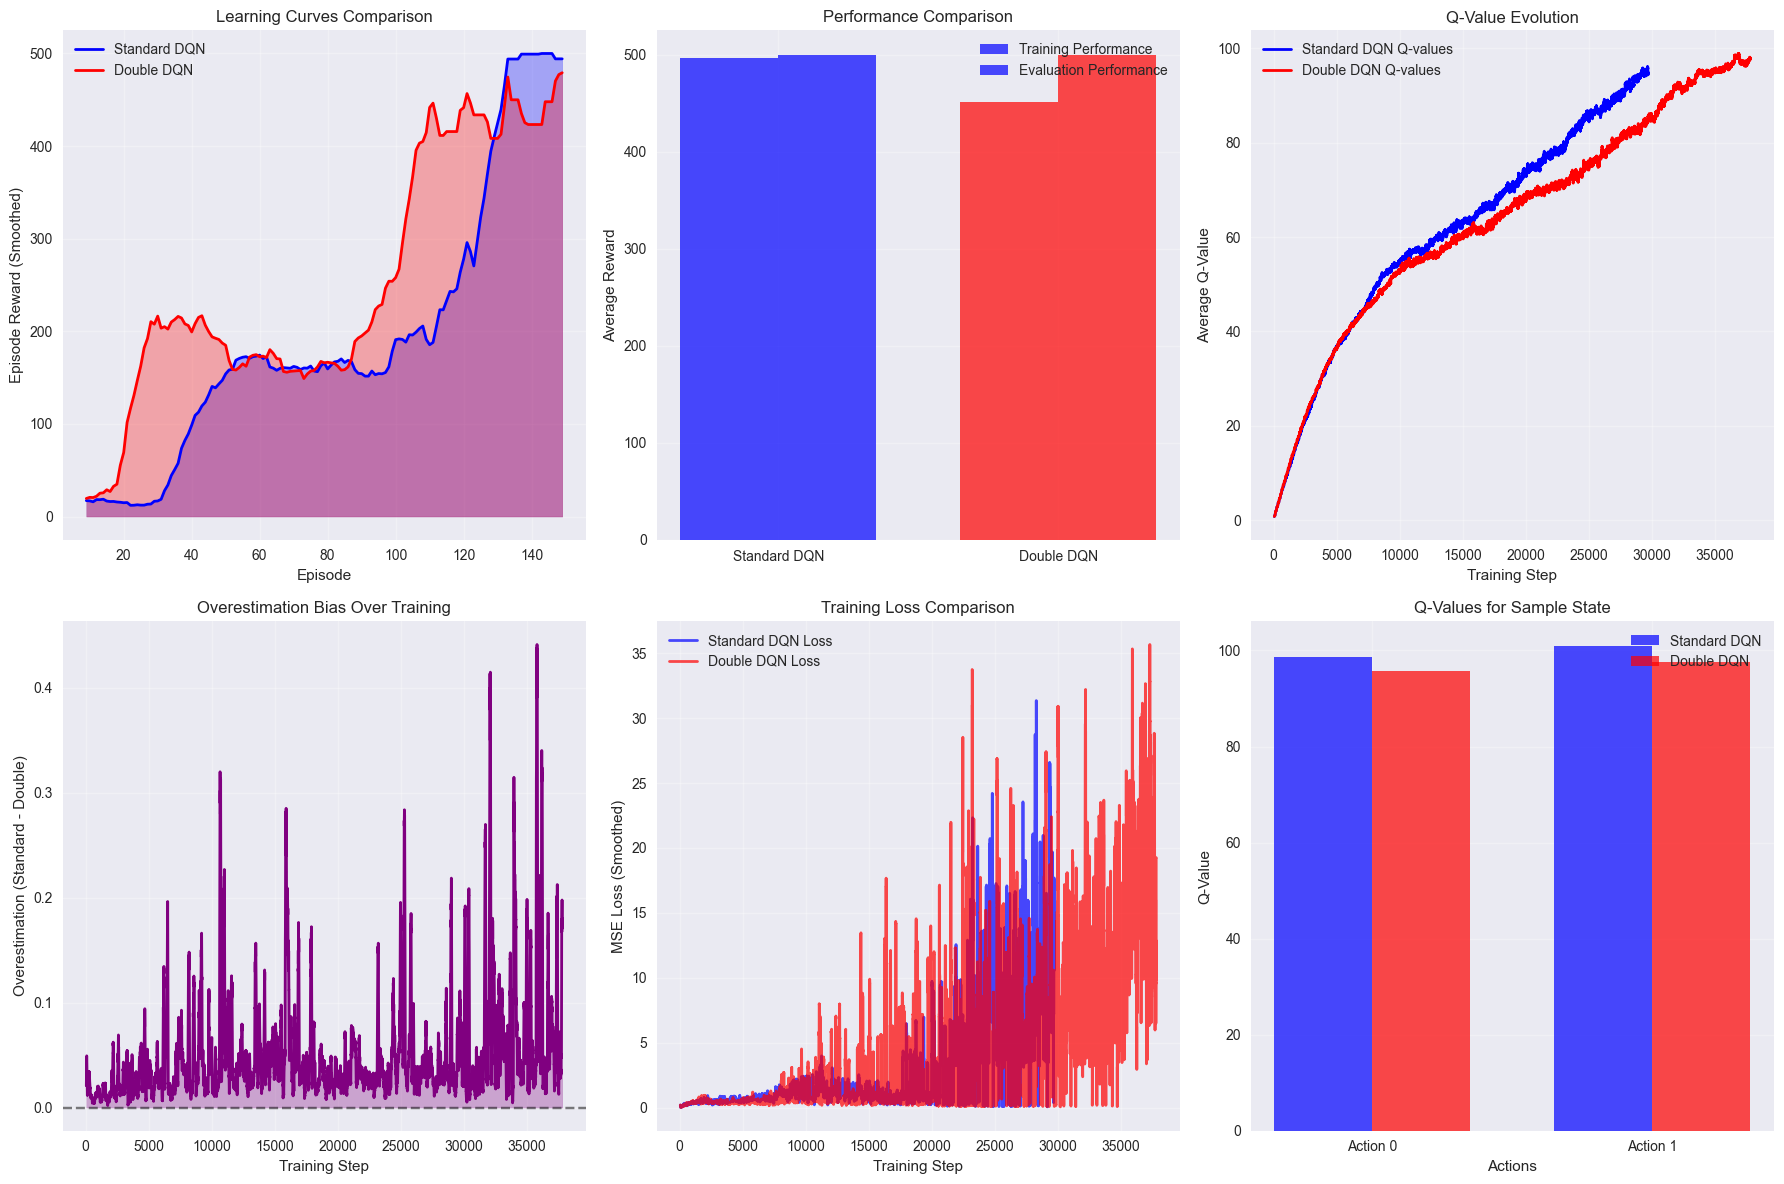


2. Deep Analysis of Overestimation Bias...
Deep Analysis of Overestimation Bias
Training Double DQN to analyze overestimation...
Episode 25 completed
Episode 50 completed
Episode 75 completed
Episode 100 completed


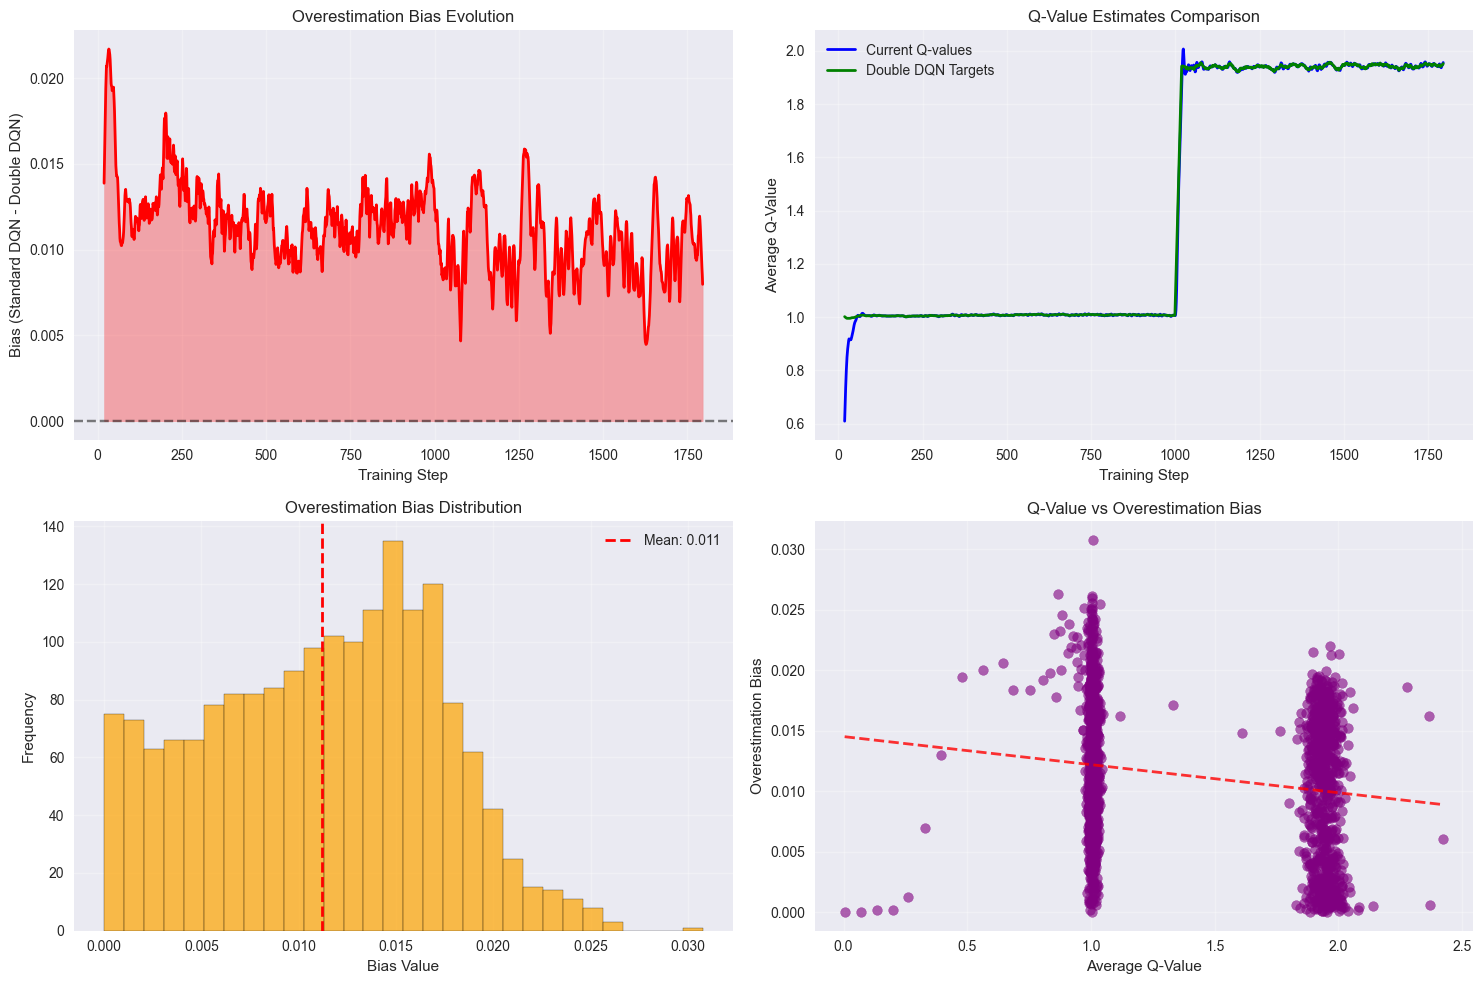


Overestimation Bias Statistics:
  Mean bias: 0.0112
  Std bias: 0.0059
  Max bias: 0.0308
  Min bias: 0.0000
  Correlation (Q-values vs Bias): -0.1861


In [ ]:
# Complete Double DQN Implementation

class DoubleDQNAgent(DQNAgent):
    """
    Double DQN Agent - Extends basic DQN to address overestimation bias
    """
    
    def __init__(self, state_dim, action_dim, **kwargs):
        super().__init__(state_dim, action_dim, **kwargs)
        
        # Additional tracking for bias analysis
        self.q_value_estimates = {'main': [], 'target': [], 'double': []}
        self.overestimation_metrics = []
    
    def train_step(self):
        """Double DQN training step with bias tracking"""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target computation
        with torch.no_grad():
            # Use main network to select actions
            next_actions = self.q_network(next_states).argmax(1)
            
            # Use target network to evaluate selected actions
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Compute targets
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))
            
            # For comparison: also compute standard DQN targets
            standard_next_q_values = self.target_network(next_states).max(1)[0]
            standard_targets = rewards + (self.gamma * standard_next_q_values * (~dones))
            
            # Track bias metrics
            self.track_bias_metrics(current_q_values, target_q_values, standard_targets)
        
        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Update target network periodically
        self.training_step += 1
        if self.training_step % self.target_update_freq == 0:
            self.update_target_network()
        
        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        # Store metrics
        self.losses.append(loss.item())
        self.epsilon_history.append(self.epsilon)
        
        with torch.no_grad():
            avg_q_value = current_q_values.mean().item()
            self.q_values_history.append(avg_q_value)
        
        return loss.item()
    
    def track_bias_metrics(self, current_q, double_targets, standard_targets):
        """Track overestimation bias metrics"""
        
        # Store average values for analysis
        self.q_value_estimates['main'].append(current_q.mean().item())
        self.q_value_estimates['double'].append(double_targets.mean().item())
        
        # Compute overestimation (standard DQN targets - Double DQN targets)
        overestimation = (standard_targets - double_targets).mean().item()
        self.overestimation_metrics.append(overestimation)

class OverestimationAnalyzer:
    """
    Comprehensive analysis of overestimation bias in DQN variants
    """
    
    def compare_dqn_variants(self):
        """Compare standard DQN vs Double DQN"""
        
        print("="*70)
        print("DQN vs Double DQN Comparison")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test both variants
        variants = {
            'Standard DQN': DQNAgent,
            'Double DQN': DoubleDQNAgent
        }
        
        results = {}
        num_episodes = 150
        
        for variant_name, agent_class in variants.items():
            print(f"\nTraining {variant_name}...")
            
            # Create agent
            agent = agent_class(
                state_dim=state_dim,
                action_dim=action_dim,
                lr=1e-3,
                epsilon_decay=0.995,
                target_update_freq=100,
                buffer_size=20000
            )
            
            episode_rewards = []
            
            for episode in range(num_episodes):
                reward, _ = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                
                if (episode + 1) % 50 == 0:
                    avg_reward = np.mean(episode_rewards[-25:])
                    print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")
            
            # Final evaluation
            eval_results = agent.evaluate(env, num_episodes=20)
            
            results[variant_name] = {
                'agent': agent,
                'rewards': episode_rewards,
                'eval_performance': eval_results,
                'final_performance': np.mean(episode_rewards[-20:])
            }
        
        # Visualization and Analysis
        self.visualize_comparison(results)
        
        env.close()
        return results
    
    def visualize_comparison(self, results):
        """Visualize comparison between DQN variants"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        colors = ['blue', 'red']
        
        # 1. Learning curves
        ax = axes[0, 0]
        for i, (variant, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(10).mean()
            ax.plot(smoothed, label=variant, color=colors[i], linewidth=2)
            ax.fill_between(range(len(smoothed)), smoothed, alpha=0.3, color=colors[i])
        
        ax.set_title('Learning Curves Comparison')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Final performance comparison
        ax = axes[0, 1]
        variant_names = list(results.keys())
        final_perfs = [results[v]['final_performance'] for v in variant_names]
        eval_means = [results[v]['eval_performance']['mean_reward'] for v in variant_names]
        eval_stds = [results[v]['eval_performance']['std_reward'] for v in variant_names]
        
        x = np.arange(len(variant_names))
        width = 0.35
        
        ax.bar(x - width/2, final_perfs, width, label='Training Performance', 
               alpha=0.7, color=colors)
        ax.bar(x + width/2, eval_means, width, yerr=eval_stds, 
               label='Evaluation Performance', alpha=0.7, color=[c for c in colors])
        
        ax.set_title('Performance Comparison')
        ax.set_ylabel('Average Reward')
        ax.set_xticks(x)
        ax.set_xticklabels(variant_names)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Q-value evolution (if available)
        ax = axes[0, 2]
        for i, (variant, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'q_values_history') and agent.q_values_history:
                smoothed_q = pd.Series(agent.q_values_history).rolling(50).mean()
                ax.plot(smoothed_q, label=f'{variant} Q-values', 
                       color=colors[i], linewidth=2)
        
        ax.set_title('Q-Value Evolution')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Average Q-Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Overestimation bias analysis (if available)
        ax = axes[1, 0]
        double_dqn_agent = None
        
        for variant, data in results.items():
            if 'Double' in variant:
                double_dqn_agent = data['agent']
                break
        
        if double_dqn_agent and hasattr(double_dqn_agent, 'overestimation_metrics'):
            if double_dqn_agent.overestimation_metrics:
                overest_smooth = pd.Series(double_dqn_agent.overestimation_metrics).rolling(50).mean()
                ax.plot(overest_smooth, color='purple', linewidth=2)
                ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                ax.fill_between(range(len(overest_smooth)), overest_smooth, 0, alpha=0.3, color='purple')
        
        ax.set_title('Overestimation Bias Over Training')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Overestimation (Standard - Double)')
        ax.grid(True, alpha=0.3)
        
        # 5. Loss comparison
        ax = axes[1, 1]
        for i, (variant, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'losses') and agent.losses:
                losses = agent.losses
                if len(losses) > 50:
                    smoothed_loss = pd.Series(losses).rolling(50).mean()
                    ax.plot(smoothed_loss, label=f'{variant} Loss', 
                           color=colors[i], linewidth=2, alpha=0.7)
        
        ax.set_title('Training Loss Comparison')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('MSE Loss (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 6. Action-value analysis
        ax = axes[1, 2]
        
        # Sample some states and analyze Q-values
        sample_state = [0.1, 0.1, 0.1, 0.1]  # Example CartPole state
        
        q_values_comparison = {}
        for variant, data in results.items():
            agent = data['agent']
            q_vals = agent.get_q_values(sample_state)
            q_values_comparison[variant] = q_vals
        
        if q_values_comparison:
            x = np.arange(len(q_vals))
            width = 0.35
            
            for i, (variant, q_vals) in enumerate(q_values_comparison.items()):
                ax.bar(x + i * width, q_vals, width, label=variant, 
                      alpha=0.7, color=colors[i])
            
            ax.set_title('Q-Values for Sample State')
            ax.set_xlabel('Actions')
            ax.set_ylabel('Q-Value')
            ax.set_xticks(x + width/2)
            ax.set_xticklabels([f'Action {i}' for i in range(len(q_vals))])
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_overestimation_in_depth(self):
        """Deep dive into overestimation bias"""
        
        print("="*70)
        print("Deep Analysis of Overestimation Bias")
        print("="*70)
        
        # Create a controlled environment to study overestimation
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Train Double DQN to track bias
        agent = DoubleDQNAgent(
            state_dim=state_dim,
            action_dim=action_dim,
            lr=1e-3,
            epsilon_decay=0.995,
            buffer_size=10000
        )
        
        print("Training Double DQN to analyze overestimation...")
        
        for episode in range(100):
            agent.train_episode(env, max_steps=500)
            
            if (episode + 1) % 25 == 0:
                print(f"Episode {episode+1} completed")
        
        # Analyze the results
        if agent.overestimation_metrics and agent.q_value_estimates['main']:
            
            plt.figure(figsize=(15, 10))
            
            # 1. Overestimation bias over time
            plt.subplot(2, 2, 1)
            overest_smooth = pd.Series(agent.overestimation_metrics).rolling(20).mean()
            plt.plot(overest_smooth, color='red', linewidth=2)
            plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            plt.fill_between(range(len(overest_smooth)), overest_smooth, 0, 
                           alpha=0.3, color='red')
            plt.title('Overestimation Bias Evolution')
            plt.xlabel('Training Step')
            plt.ylabel('Bias (Standard DQN - Double DQN)')
            plt.grid(True, alpha=0.3)
            
            # 2. Q-value estimates comparison
            plt.subplot(2, 2, 2)
            main_q_smooth = pd.Series(agent.q_value_estimates['main']).rolling(20).mean()
            double_q_smooth = pd.Series(agent.q_value_estimates['double']).rolling(20).mean()
            
            plt.plot(main_q_smooth, label='Current Q-values', color='blue', linewidth=2)
            plt.plot(double_q_smooth, label='Double DQN Targets', color='green', linewidth=2)
            plt.title('Q-Value Estimates Comparison')
            plt.xlabel('Training Step')
            plt.ylabel('Average Q-Value')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # 3. Bias distribution
            plt.subplot(2, 2, 3)
            plt.hist(agent.overestimation_metrics, bins=30, alpha=0.7, 
                    edgecolor='black', color='orange')
            plt.axvline(np.mean(agent.overestimation_metrics), color='red', 
                       linestyle='--', linewidth=2, label=f'Mean: {np.mean(agent.overestimation_metrics):.3f}')
            plt.title('Overestimation Bias Distribution')
            plt.xlabel('Bias Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            # 4. Correlation analysis
            plt.subplot(2, 2, 4)
            if len(agent.overestimation_metrics) == len(agent.q_values_history):
                plt.scatter(agent.q_values_history, agent.overestimation_metrics, 
                          alpha=0.6, color='purple')
                plt.xlabel('Average Q-Value')
                plt.ylabel('Overestimation Bias')
                plt.title('Q-Value vs Overestimation Bias')
                
                # Add trend line
                if len(agent.q_values_history) > 10:
                    z = np.polyfit(agent.q_values_history, agent.overestimation_metrics, 1)
                    p = np.poly1d(z)
                    plt.plot(sorted(agent.q_values_history), 
                            p(sorted(agent.q_values_history)), 
                            "r--", alpha=0.8, linewidth=2)
                
                plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Print statistics
            print(f"\nOverestimation Bias Statistics:")
            print(f"  Mean bias: {np.mean(agent.overestimation_metrics):.4f}")
            print(f"  Std bias: {np.std(agent.overestimation_metrics):.4f}")
            print(f"  Max bias: {np.max(agent.overestimation_metrics):.4f}")
            print(f"  Min bias: {np.min(agent.overestimation_metrics):.4f}")
            
            # Correlation between Q-values and bias
            if len(agent.overestimation_metrics) == len(agent.q_values_history):
                correlation = np.corrcoef(agent.q_values_history, agent.overestimation_metrics)[0, 1]
                print(f"  Correlation (Q-values vs Bias): {correlation:.4f}")
        
        env.close()
        return agent

# Run overestimation bias analysis
analyzer = OverestimationAnalyzer()

print("1. Comparing Standard DQN vs Double DQN...")
comparison_results = analyzer.compare_dqn_variants()

print("\n2. Deep Analysis of Overestimation Bias...")
bias_agent = analyzer.analyze_overestimation_in_depth()

# Section 5: Dueling DQN and Value Decomposition

## 5.1 The Motivation Behind Dueling Architecture

Standard DQN learns Q-values directly, but these can be decomposed into two meaningful components:

### Value Decomposition Theory
The Q-function can be decomposed as:
```
Q(s,a) = V(s) + A(s,a)
```

Where:
- **V(s)**: State value function - "How good is this state?"
- **A(s,a)**: Advantage function - "How much better is action a compared to average?"

### Why This Matters

1. **State Value Learning**: Many states have similar values regardless of action
2. **Action Ranking**: What matters most is the relative advantage of actions
3. **Sample Efficiency**: Decoupling allows better generalization
4. **Faster Learning**: State values can be learned from all experiences

## 5.2 Dueling Network Architecture

### Network Structure
```
Input State
     |
Feature Extraction
     |
   Split into two streams
     /              \
Value Stream    Advantage Stream  
   V(s)           A(s,a)
     \              /
      Combining Module
           |
        Q(s,a)
```

### Combining the Streams

The naive combination `Q(s,a) = V(s) + A(s,a)` has an identifiability problem. 

**Solution**: Subtract the mean advantage:
```
Q(s,a) = V(s) + A(s,a) - (1/|A|) Σ A(s,a')
                                    a'
```

### Alternative Formulation
Use max instead of mean for better performance:
```
Q(s,a) = V(s) + A(s,a) - max A(s,a')
                           a'
```

## 5.3 Benefits of Dueling Architecture

1. **Better Value Estimation**: State values learned more efficiently
2. **Improved Policy**: Better action selection through advantage learning
3. **Robustness**: More stable learning across different environments
4. **Generalization**: Better performance on states with similar values

Let's implement and analyze the Dueling DQN architecture.

1. Comparing Dueling DQN Variants...
Dueling DQN Variants Comparison

Training Standard DQN...
  Episode 40: Avg Reward = 147.4
  Episode 80: Avg Reward = 158.2
  Episode 120: Avg Reward = 382.1

Training Dueling (Mean)...
  Episode 40: Avg Reward = 83.0
  Episode 80: Avg Reward = 125.8
  Episode 120: Avg Reward = 434.8

Training Dueling (Max)...
  Episode 40: Avg Reward = 53.9
  Episode 80: Avg Reward = 161.2
  Episode 120: Avg Reward = 360.6


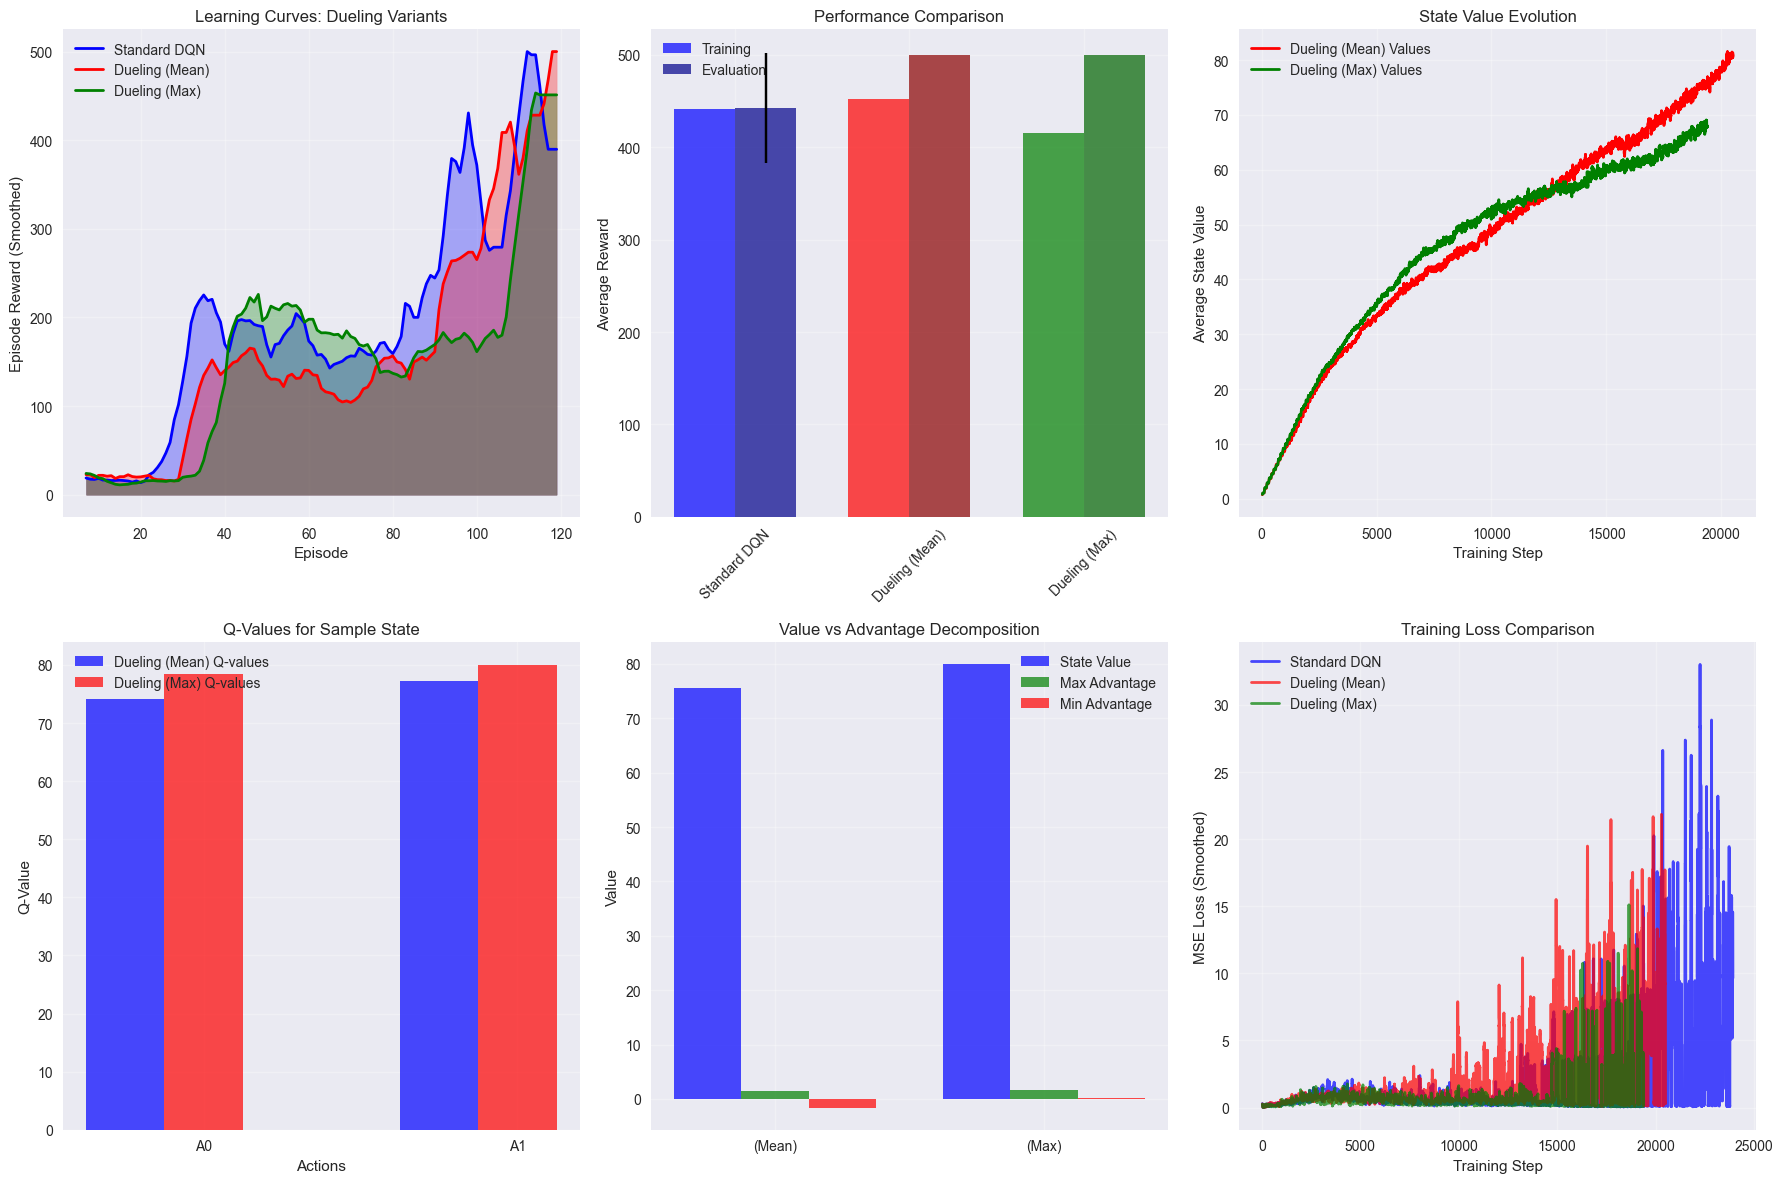


2. Analyzing Value-Advantage Dynamics...
Value-Advantage Dynamics Analysis
Training Dueling DQN for dynamics analysis...
Episode 20 completed
Episode 40 completed
Episode 60 completed
Episode 80 completed


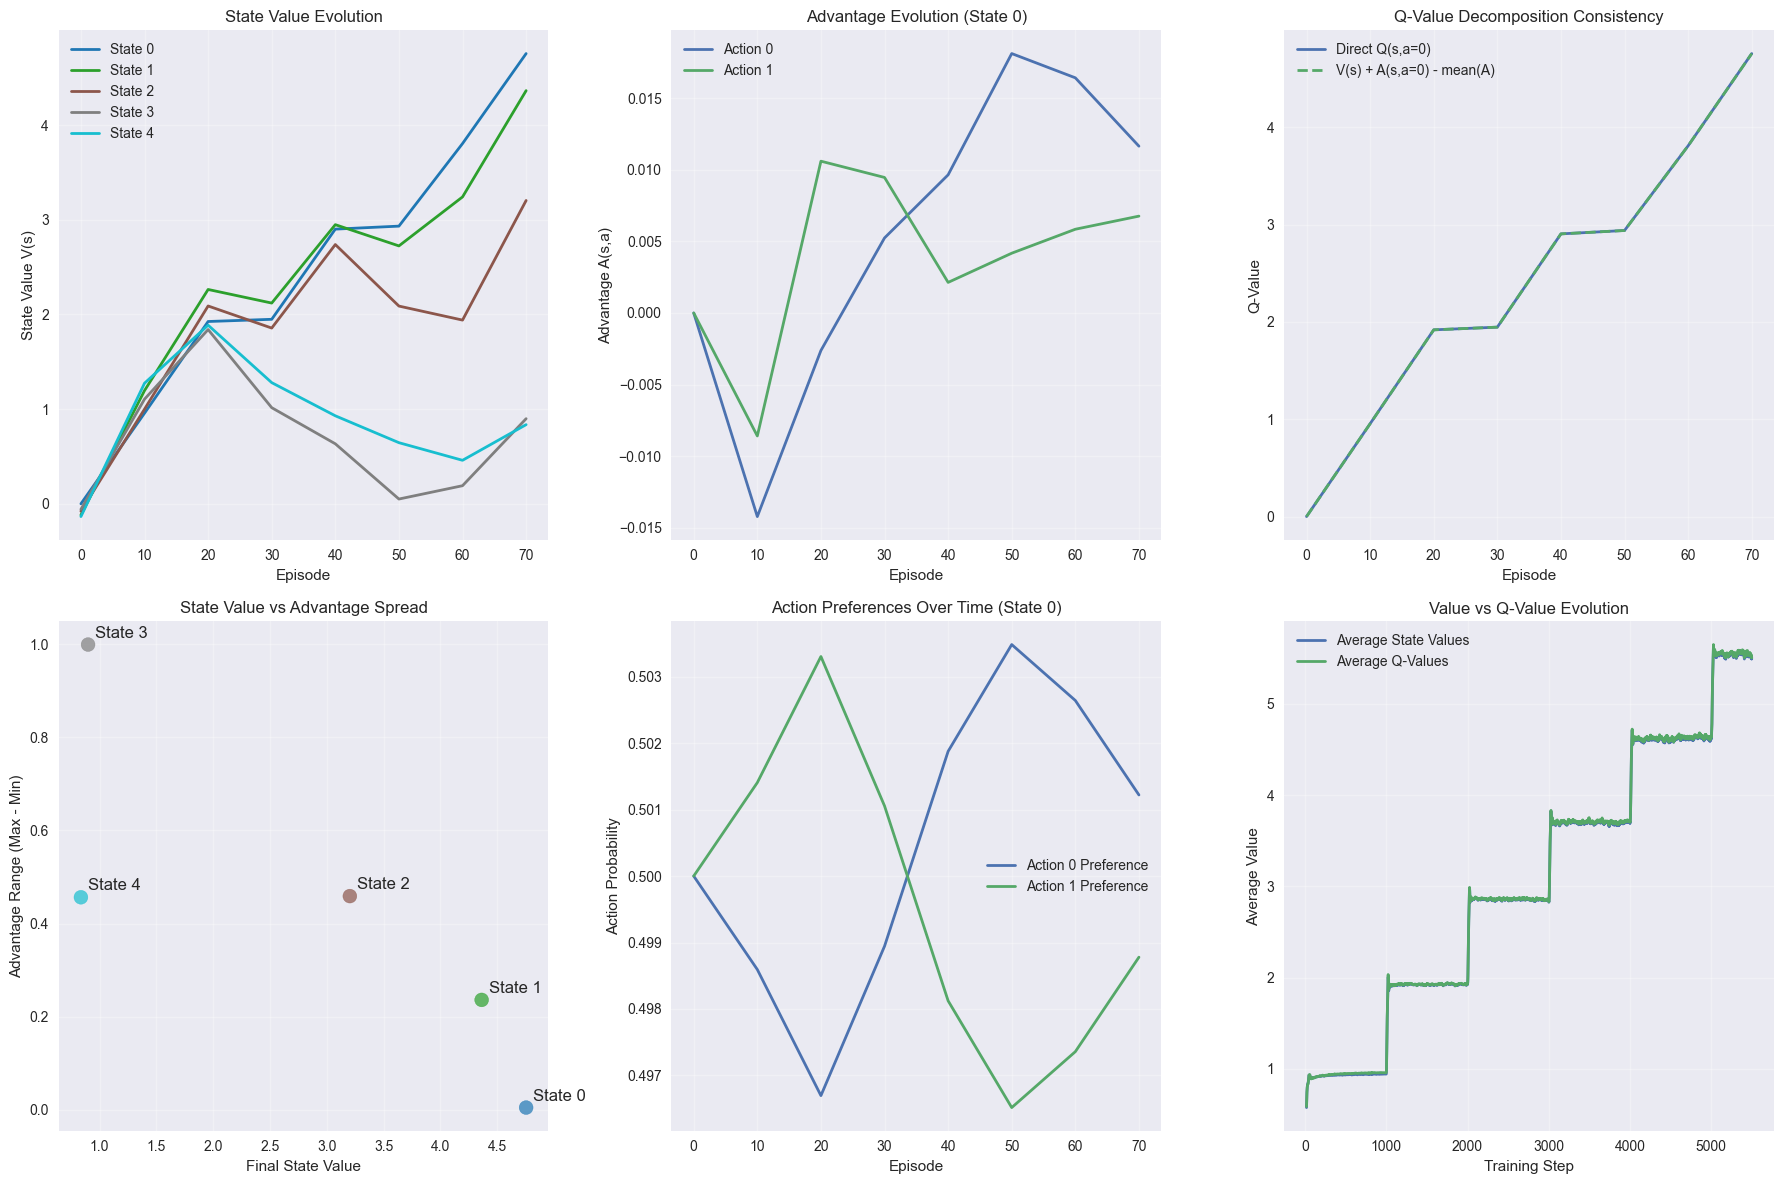

In [ ]:
# Complete Dueling DQN Implementation

class DuelingDQN(nn.Module):
    """
    Dueling Deep Q-Network with separate value and advantage streams
    """
    
    def __init__(self, state_dim, action_dim, hidden_dims=[256, 256], dueling_type='mean'):
        super(DuelingDQN, self).__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.dueling_type = dueling_type
        
        # Shared feature extraction layers
        self.feature_layers = nn.Sequential()
        prev_dim = state_dim
        
        for i, hidden_dim in enumerate(hidden_dims[:-1]):
            self.feature_layers.add_module(f'fc{i}', nn.Linear(prev_dim, hidden_dim))
            self.feature_layers.add_module(f'relu{i}', nn.ReLU())
            prev_dim = hidden_dim
        
        # Split into value and advantage streams
        feature_dim = hidden_dims[-1] if hidden_dims else hidden_dims[0]
        
        # Value stream - outputs single value V(s)
        self.value_stream = nn.Sequential(
            nn.Linear(prev_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, 1)
        )
        
        # Advantage stream - outputs advantage for each action A(s,a)
        self.advantage_stream = nn.Sequential(
            nn.Linear(prev_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, action_dim)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, state):
        """
        Forward pass through dueling architecture
        
        Args:
            state: Batch of states [batch_size, state_dim]
            
        Returns:
            Q-values [batch_size, action_dim]
            value: State values [batch_size, 1] (for analysis)
            advantage: Action advantages [batch_size, action_dim] (for analysis)
        """
        # Extract features
        features = self.feature_layers(state)
        
        # Compute value and advantage
        value = self.value_stream(features)  # [batch_size, 1]
        advantage = self.advantage_stream(features)  # [batch_size, action_dim]
        
        # Combine to get Q-values
        if self.dueling_type == 'mean':
            # Subtract mean advantage
            q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        elif self.dueling_type == 'max':
            # Subtract max advantage
            q_values = value + advantage - advantage.max(dim=1, keepdim=True)[0]
        else:
            # Naive combination (not recommended)
            q_values = value + advantage
        
        return q_values, value, advantage
    
    def get_action(self, state, epsilon=0.0):
        """Select action using epsilon-greedy policy"""
        if random.random() < epsilon:
            return random.randint(0, self.action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values, _, _ = self.forward(state_tensor)
                return q_values.argmax().item()

class DuelingDQNAgent(DoubleDQNAgent):
    """
    Dueling DQN Agent combining Double DQN with Dueling Architecture
    """
    
    def __init__(self, state_dim, action_dim, dueling_type='mean', **kwargs):
        # Initialize parent class first
        self.dueling_type = dueling_type
        super().__init__(state_dim, action_dim, **kwargs)
        
        # Replace networks with dueling architecture
        self.q_network = DuelingDQN(state_dim, action_dim, dueling_type=dueling_type).to(device)
        self.target_network = DuelingDQN(state_dim, action_dim, dueling_type=dueling_type).to(device)
        
        # Initialize target network
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Update optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=kwargs.get('lr', 1e-4))
        
        # Additional tracking for value/advantage analysis
        self.value_history = []
        self.advantage_history = []
    
    def train_step(self):
        """Dueling Double DQN training step"""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        # Current Q-values and decomposition
        current_q_values, current_values, current_advantages = self.q_network(states)
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Double DQN target computation with dueling
        with torch.no_grad():
            # Use main network to select actions
            next_q_main, _, _ = self.q_network(next_states)
            next_actions = next_q_main.argmax(1)
            
            # Use target network to evaluate selected actions
            next_q_target, _, _ = self.target_network(next_states)
            next_q_values = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Compute targets
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))
        
        # Compute loss
        loss = F.mse_loss(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Update target network periodically
        self.training_step += 1
        if self.training_step % self.target_update_freq == 0:
            self.update_target_network()
        
        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        # Store metrics
        self.losses.append(loss.item())
        self.epsilon_history.append(self.epsilon)
        
        # Track Q-values, values, and advantages
        with torch.no_grad():
            avg_q_value = current_q_values.mean().item()
            avg_value = current_values.mean().item()
            avg_advantage = current_advantages.mean().item()
            
            self.q_values_history.append(avg_q_value)
            self.value_history.append(avg_value)
            self.advantage_history.append(avg_advantage)
        
        return loss.item()
    
    def get_value_advantage_decomposition(self, state):
        """Get value and advantage decomposition for a state"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values, value, advantage = self.q_network(state_tensor)
            
            return {
                'q_values': q_values.cpu().numpy().flatten(),
                'value': value.item(),
                'advantage': advantage.cpu().numpy().flatten()
            }

class DuelingAnalyzer:
    """
    Comprehensive analysis of Dueling DQN architecture
    """
    
    def compare_dueling_variants(self):
        """Compare different dueling combination methods"""
        
        print("="*70)
        print("Dueling DQN Variants Comparison")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test different dueling types
        variants = {
            'Standard DQN': {'agent_class': DoubleDQNAgent, 'dueling_type': None},
            'Dueling (Mean)': {'agent_class': DuelingDQNAgent, 'dueling_type': 'mean'},
            'Dueling (Max)': {'agent_class': DuelingDQNAgent, 'dueling_type': 'max'},
        }
        
        results = {}
        num_episodes = 120
        
        for variant_name, config in variants.items():
            print(f"\nTraining {variant_name}...")
            
            # Create agent
            agent_kwargs = {
                'state_dim': state_dim,
                'action_dim': action_dim,
                'lr': 1e-3,
                'epsilon_decay': 0.995,
                'target_update_freq': 100,
                'buffer_size': 15000
            }
            
            if config['dueling_type']:
                agent_kwargs['dueling_type'] = config['dueling_type']
            
            agent = config['agent_class'](**agent_kwargs)
            
            episode_rewards = []
            
            for episode in range(num_episodes):
                reward, _ = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                
                if (episode + 1) % 40 == 0:
                    avg_reward = np.mean(episode_rewards[-20:])
                    print(f"  Episode {episode+1}: Avg Reward = {avg_reward:.1f}")
            
            # Final evaluation
            eval_results = agent.evaluate(env, num_episodes=15)
            
            results[variant_name] = {
                'agent': agent,
                'rewards': episode_rewards,
                'eval_performance': eval_results,
                'final_performance': np.mean(episode_rewards[-15:])
            }
        
        # Visualization
        self.visualize_dueling_comparison(results)
        
        env.close()
        return results
    
    def visualize_dueling_comparison(self, results):
        """Visualize dueling architecture comparison"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        colors = ['blue', 'red', 'green']
        
        # 1. Learning curves
        ax = axes[0, 0]
        for i, (variant, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(8).mean()
            ax.plot(smoothed, label=variant, color=colors[i], linewidth=2)
            ax.fill_between(range(len(smoothed)), smoothed, alpha=0.3, color=colors[i])
        
        ax.set_title('Learning Curves: Dueling Variants')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Performance comparison
        ax = axes[0, 1]
        variant_names = list(results.keys())
        final_perfs = [results[v]['final_performance'] for v in variant_names]
        eval_means = [results[v]['eval_performance']['mean_reward'] for v in variant_names]
        eval_stds = [results[v]['eval_performance']['std_reward'] for v in variant_names]
        
        x = np.arange(len(variant_names))
        width = 0.35
        
        ax.bar(x - width/2, final_perfs, width, label='Training', 
               alpha=0.7, color=colors)
        ax.bar(x + width/2, eval_means, width, yerr=eval_stds, 
               label='Evaluation', alpha=0.7, color=['darkblue', 'darkred', 'darkgreen'])
        
        ax.set_title('Performance Comparison')
        ax.set_ylabel('Average Reward')
        ax.set_xticks(x)
        ax.set_xticklabels(variant_names, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Value/Advantage evolution (for dueling agents)
        ax = axes[0, 2]
        for i, (variant, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'value_history') and agent.value_history:
                value_smooth = pd.Series(agent.value_history).rolling(30).mean()
                ax.plot(value_smooth, label=f'{variant} Values', 
                       color=colors[i], linewidth=2)
        
        ax.set_title('State Value Evolution')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Average State Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Q-value decomposition analysis
        ax = axes[1, 0]
        sample_state = [0.1, 0.1, 0.1, 0.1]  # Example state
        
        decompositions = {}
        for variant, data in results.items():
            agent = data['agent']
            if hasattr(agent, 'get_value_advantage_decomposition'):
                decomp = agent.get_value_advantage_decomposition(sample_state)
                decompositions[variant] = decomp
        
        if decompositions:
            # Plot Q-values comparison
            for i, (variant, decomp) in enumerate(decompositions.items()):
                q_vals = decomp['q_values']
                x_pos = np.arange(len(q_vals)) + i * 0.25
                ax.bar(x_pos, q_vals, 0.25, label=f'{variant} Q-values', 
                      alpha=0.7, color=colors[i])
            
            ax.set_title('Q-Values for Sample State')
            ax.set_xlabel('Actions')
            ax.set_ylabel('Q-Value')
            ax.set_xticks(np.arange(len(q_vals)) + 0.25)
            ax.set_xticklabels([f'A{i}' for i in range(len(q_vals))])
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 5. Value vs Advantage contributions
        ax = axes[1, 1]
        if decompositions:
            dueling_variants = {k: v for k, v in decompositions.items() if 'Dueling' in k}
            
            if dueling_variants:
                variant_names_dueling = list(dueling_variants.keys())
                values = [decomp['value'] for decomp in dueling_variants.values()]
                max_advantages = [np.max(decomp['advantage']) for decomp in dueling_variants.values()]
                min_advantages = [np.min(decomp['advantage']) for decomp in dueling_variants.values()]
                
                x = np.arange(len(variant_names_dueling))
                width = 0.25
                
                ax.bar(x - width, values, width, label='State Value', alpha=0.7, color='blue')
                ax.bar(x, max_advantages, width, label='Max Advantage', alpha=0.7, color='green')
                ax.bar(x + width, min_advantages, width, label='Min Advantage', alpha=0.7, color='red')
                
                ax.set_title('Value vs Advantage Decomposition')
                ax.set_ylabel('Value')
                ax.set_xticks(x)
                ax.set_xticklabels([name.replace('Dueling ', '') for name in variant_names_dueling])
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        # 6. Training stability comparison
        ax = axes[1, 2]
        for i, (variant, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'losses') and len(agent.losses) > 30:
                losses = agent.losses
                loss_smooth = pd.Series(losses).rolling(30).mean()
                ax.plot(loss_smooth, label=f'{variant}', 
                       color=colors[i], linewidth=2, alpha=0.7)
        
        ax.set_title('Training Loss Comparison')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('MSE Loss (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_value_advantage_dynamics(self):
        """Deep analysis of value and advantage learning dynamics"""
        
        print("="*70)
        print("Value-Advantage Dynamics Analysis")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Train dueling agent
        agent = DuelingDQNAgent(
            state_dim=state_dim,
            action_dim=action_dim,
            dueling_type='mean',
            lr=1e-3,
            epsilon_decay=0.995,
            buffer_size=10000
        )
        
        print("Training Dueling DQN for dynamics analysis...")
        
        # Store decompositions at different states throughout training
        sample_states = [
            [0.0, 0.0, 0.0, 0.0],    # Centered
            [1.0, 0.0, 0.1, 0.0],    # Cart right, pole tilted
            [-1.0, 0.0, -0.1, 0.0],  # Cart left, pole tilted opposite
            [0.0, 1.0, 0.0, 1.0],    # Moving right
            [0.0, -1.0, 0.0, -1.0],  # Moving left
        ]
        
        decomposition_history = {i: {'values': [], 'advantages': [], 'q_values': []} 
                               for i in range(len(sample_states))}
        
        for episode in range(80):
            agent.train_episode(env, max_steps=500)
            
            # Record decompositions every few episodes
            if episode % 10 == 0:
                for i, state in enumerate(sample_states):
                    decomp = agent.get_value_advantage_decomposition(state)
                    decomposition_history[i]['values'].append(decomp['value'])
                    decomposition_history[i]['advantages'].append(decomp['advantage'].copy())
                    decomposition_history[i]['q_values'].append(decomp['q_values'].copy())
            
            if (episode + 1) % 20 == 0:
                print(f"Episode {episode+1} completed")
        
        # Visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Value evolution for different states
        ax = axes[0, 0]
        colors = plt.cm.tab10(np.linspace(0, 1, len(sample_states)))
        
        for i, color in enumerate(colors):
            values = decomposition_history[i]['values']
            episodes = np.arange(0, len(values)) * 10
            ax.plot(episodes, values, label=f'State {i}', color=color, linewidth=2)
        
        ax.set_title('State Value Evolution')
        ax.set_xlabel('Episode')
        ax.set_ylabel('State Value V(s)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Advantage evolution for first state
        ax = axes[0, 1]
        if decomposition_history[0]['advantages']:
            advantages_array = np.array(decomposition_history[0]['advantages'])  # [time, actions]
            episodes = np.arange(0, len(advantages_array)) * 10
            
            for action in range(action_dim):
                ax.plot(episodes, advantages_array[:, action], 
                       label=f'Action {action}', linewidth=2)
        
        ax.set_title('Advantage Evolution (State 0)')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Advantage A(s,a)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Q-value vs Value+Advantage consistency check
        ax = axes[0, 2]
        if decomposition_history[0]['q_values'] and decomposition_history[0]['values']:
            q_vals = np.array(decomposition_history[0]['q_values'])
            values = np.array(decomposition_history[0]['values'])
            advantages = np.array(decomposition_history[0]['advantages'])
            
            # Compute reconstructed Q-values
            reconstructed_q = values[:, None] + advantages - advantages.mean(axis=1, keepdims=True)
            
            # Plot comparison for one action
            episodes = np.arange(0, len(q_vals)) * 10
            ax.plot(episodes, q_vals[:, 0], label='Direct Q(s,a=0)', linewidth=2)
            ax.plot(episodes, reconstructed_q[:, 0], label='V(s) + A(s,a=0) - mean(A)', 
                   linewidth=2, linestyle='--')
            
            ax.set_title('Q-Value Decomposition Consistency')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Q-Value')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 4. Final value vs advantage magnitudes
        ax = axes[1, 0]
        if all(decomposition_history[i]['values'] for i in range(len(sample_states))):
            final_values = [decomposition_history[i]['values'][-1] for i in range(len(sample_states))]
            final_advantage_ranges = [
                np.max(decomposition_history[i]['advantages'][-1]) - 
                np.min(decomposition_history[i]['advantages'][-1]) 
                for i in range(len(sample_states))
            ]
            
            ax.scatter(final_values, final_advantage_ranges, s=100, alpha=0.7, c=colors)
            
            for i, (val, adv_range) in enumerate(zip(final_values, final_advantage_ranges)):
                ax.annotate(f'State {i}', (val, adv_range), xytext=(5, 5), 
                           textcoords='offset points')
            
            ax.set_xlabel('Final State Value')
            ax.set_ylabel('Advantage Range (Max - Min)')
            ax.set_title('State Value vs Advantage Spread')
            ax.grid(True, alpha=0.3)
        
        # 5. Action preference evolution
        ax = axes[1, 1]
        if decomposition_history[0]['q_values']:
            q_vals = np.array(decomposition_history[0]['q_values'])
            episodes = np.arange(0, len(q_vals)) * 10
            
            # Compute action preferences (softmax probabilities)
            action_probs = F.softmax(torch.tensor(q_vals), dim=1).numpy()
            
            for action in range(action_dim):
                ax.plot(episodes, action_probs[:, action], 
                       label=f'Action {action} Preference', linewidth=2)
            
            ax.set_title('Action Preferences Over Time (State 0)')
            ax.set_xlabel('Episode')
            ax.set_ylabel('Action Probability')
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        # 6. Value prediction accuracy
        ax = axes[1, 2]
        if hasattr(agent, 'value_history') and hasattr(agent, 'q_values_history'):
            # Compare average value predictions with average Q-values
            episodes_v = range(len(agent.value_history))
            episodes_q = range(len(agent.q_values_history))
            
            if len(episodes_v) > 10 and len(episodes_q) > 10:
                # Smooth the curves
                value_smooth = pd.Series(agent.value_history).rolling(20).mean()
                q_smooth = pd.Series(agent.q_values_history).rolling(20).mean()
                
                ax.plot(episodes_v, value_smooth, label='Average State Values', linewidth=2)
                ax.plot(episodes_q, q_smooth, label='Average Q-Values', linewidth=2)
                
                ax.set_title('Value vs Q-Value Evolution')
                ax.set_xlabel('Training Step')
                ax.set_ylabel('Average Value')
                ax.legend()
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        env.close()
        return agent, decomposition_history

# Run dueling architecture analysis
dueling_analyzer = DuelingAnalyzer()

print("1. Comparing Dueling DQN Variants...")
dueling_results = dueling_analyzer.compare_dueling_variants()

print("\n2. Analyzing Value-Advantage Dynamics...")
dynamics_agent, dynamics_history = dueling_analyzer.analyze_value_advantage_dynamics()

# Section 6: Prioritized Experience Replay

## 6.1 Motivation for Prioritized Sampling

Standard experience replay samples uniformly from the buffer, but not all experiences are equally valuable for learning:

### Key Insights
1. **Learning Opportunity**: Experiences with high TD error provide more learning signal
2. **Sample Efficiency**: Focus on experiences where we can learn the most
3. **Rare Events**: Important but infrequent experiences might be undersampled

### Problems with Uniform Sampling
- Wastes computation on experiences with low TD error
- May miss important experiences that occur rarely
- Doesn't focus learning where it's most needed

## 6.2 Prioritized Experience Replay (PER) Algorithm

### Priority Assignment
Assign priority based on TD error magnitude:
```
p_i = |δ_i| + ε
```
Where:
- `δ_i`: TD error for experience i
- `ε`: Small constant to ensure all experiences have non-zero probability

### Sampling Probability
```
P(i) = p_i^α / Σ_k p_k^α
```
Where `α` controls how much prioritization is applied:
- `α = 0`: Uniform sampling (standard replay)
- `α = 1`: Full prioritization

### Importance Sampling Weights
To correct for the bias introduced by prioritized sampling:
```
w_i = (1/N * 1/P(i))^β
```
Where:
- `N`: Buffer size  
- `β`: Importance sampling exponent (annealed from initial value to 1)

## 6.3 Implementation Strategies

### Efficient Data Structures
1. **Sum Tree**: For efficient sampling and updating
2. **Min Tree**: For tracking minimum priority
3. **Segment Tree**: Alternative efficient implementation

### Practical Considerations
- **Priority Updates**: Update priorities after each training step
- **Stale Priorities**: Handle experiences that haven't been updated recently
- **Memory Efficiency**: Balance between accuracy and memory usage

Let's implement a complete Prioritized Experience Replay system.

1. Comparing Standard vs Prioritized Replay...
Standard vs Prioritized Experience Replay Comparison

Training Standard Replay...
  Episode 25: Reward = 75.2, Steps = 75.2
  Episode 50: Reward = 141.2, Steps = 141.2
  Episode 75: Reward = 144.6, Steps = 144.6
  Episode 100: Reward = 206.1, Steps = 206.1

Training Prioritized Replay...
  Episode 25: Reward = 19.3, Steps = 19.3
  Episode 50: Reward = 71.3, Steps = 71.3
  Episode 75: Reward = 140.3, Steps = 140.3
  Episode 100: Reward = 455.6, Steps = 455.6


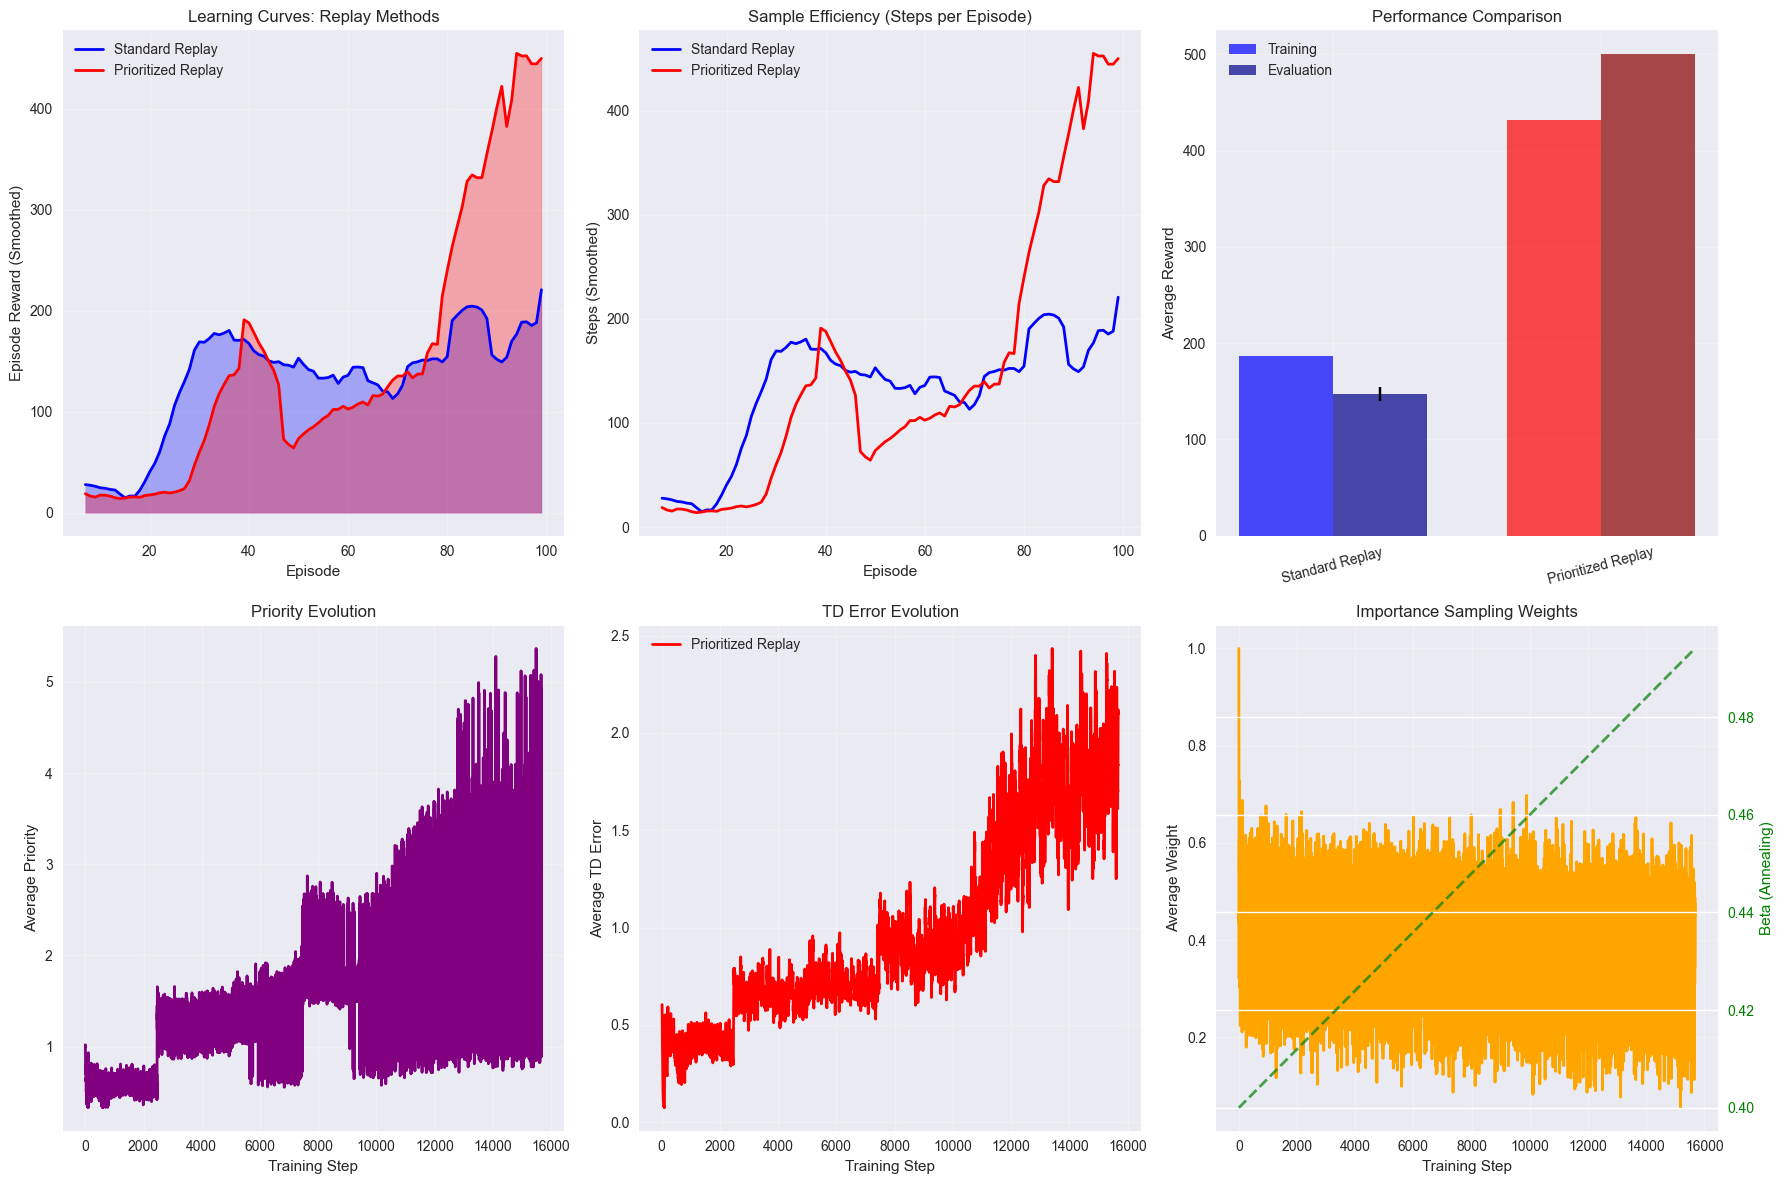


2. Analyzing Priority Distribution...
Priority Distribution Analysis
Training agent to analyze priorities...
Episode 10 completed
Episode 20 completed
Episode 30 completed
Episode 40 completed

Analyzing priority distribution...


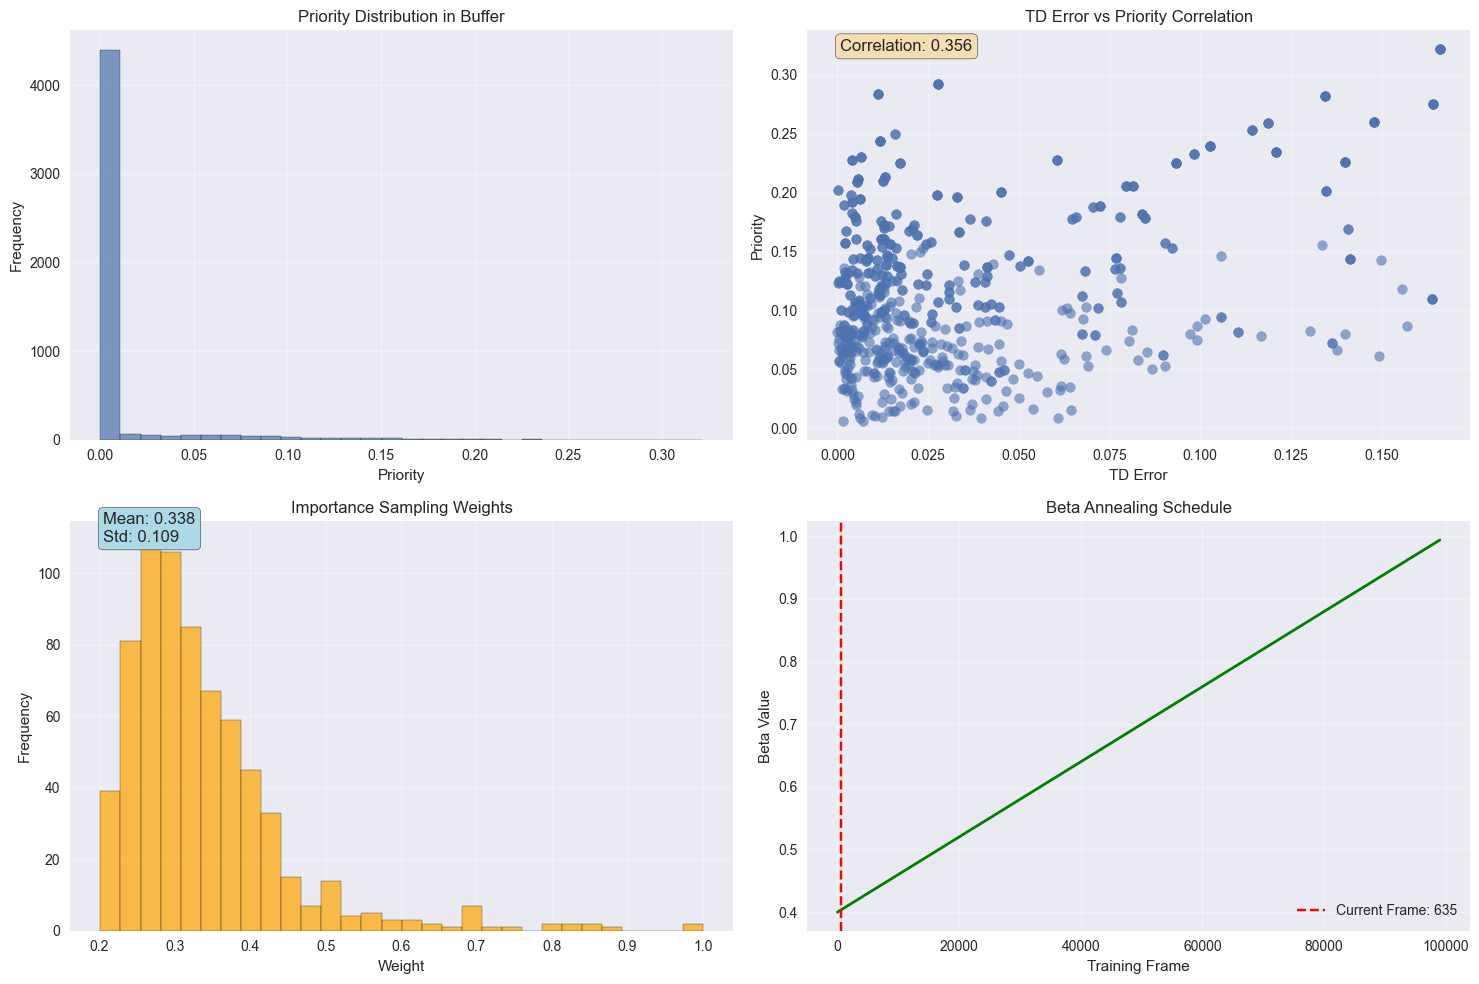


Priority Statistics:
  Buffer size: 696
  Priority range: [0.0000, 0.3220]
  Average priority: 0.0101
  Priority std: 0.0334

Sampling Statistics:
  Weight range: [0.2014, 1.0000]
  Average weight: 0.3377
  Current beta: 0.4038
  Current frame: 635


In [ ]:
# Complete Prioritized Experience Replay Implementation

class SumTree:
    """
    Sum Tree data structure for efficient prioritized sampling
    """
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)  # Internal nodes + leaves
        self.data = np.zeros(capacity, dtype=object)  # Store experiences
        self.data_pointer = 0
        self.n_entries = 0
    
    def add(self, priority, data):
        """Add experience with given priority"""
        tree_index = self.data_pointer + self.capacity - 1
        
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        
        self.data_pointer = (self.data_pointer + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1
    
    def update(self, tree_index, priority):
        """Update priority of a leaf node"""
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # Propagate change up the tree
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    def get_leaf(self, value):
        """Get leaf index, priority value, and data for given cumulative value"""
        parent_index = 0
        
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach a leaf
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            if value <= self.tree[left_child_index]:
                parent_index = left_child_index
            else:
                value -= self.tree[left_child_index]
                parent_index = right_child_index
        
        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        """Get total priority (sum of all priorities)"""
        return self.tree[0]
    
    def __len__(self):
        return self.n_entries

class PrioritizedReplayBuffer:
    """
    Prioritized Experience Replay Buffer
    """
    
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.capacity = capacity
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        
        # Initialize sum tree
        self.tree = SumTree(capacity)
        
        # Priority constants
        self.epsilon = 1e-6  # Small value to prevent zero priorities
        self.max_priority = 1.0  # Initial max priority
        
        # Stats tracking
        self.priority_history = []
        self.sampling_weights_history = []
    
    def beta(self):
        """Annealed importance sampling weight"""
        return min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, state, action, reward, next_state, done):
        """Store experience with max priority"""
        experience = Experience(state, action, reward, next_state, done)
        
        # Use max priority for new experiences
        priority = self.max_priority
        self.tree.add(priority, experience)
    
    def sample(self, batch_size):
        """Sample batch with priorities"""
        batch_indices = []
        batch_experiences = []
        priorities = []
        
        # Calculate segment size for stratified sampling
        segment_size = self.tree.total_priority / batch_size
        
        for i in range(batch_size):
            # Sample from segment
            a = segment_size * i
            b = segment_size * (i + 1)
            value = random.uniform(a, b)
            
            # Get experience
            index, priority, experience = self.tree.get_leaf(value)
            
            batch_indices.append(index)
            batch_experiences.append(experience)
            priorities.append(priority)
        
        # Calculate importance sampling weights
        sampling_probabilities = np.array(priorities) / self.tree.total_priority
        weights = (len(self.tree) * sampling_probabilities) ** -self.beta()
        weights = weights / weights.max()  # Normalize
        
        # Convert to tensors
        states = torch.FloatTensor([e.state for e in batch_experiences]).to(device)
        actions = torch.LongTensor([e.action for e in batch_experiences]).to(device)
        rewards = torch.FloatTensor([e.reward for e in batch_experiences]).to(device)
        next_states = torch.FloatTensor([e.next_state for e in batch_experiences]).to(device)
        dones = torch.BoolTensor([e.done for e in batch_experiences]).to(device)
        weights = torch.FloatTensor(weights).to(device)
        
        # Store stats
        self.priority_history.append(np.mean(priorities))
        self.sampling_weights_history.append(weights.mean().item())
        
        self.frame += 1
        
        return states, actions, rewards, next_states, dones, weights, batch_indices
    
    def update_priorities(self, indices, priorities):
        """Update priorities for given indices"""
        for idx, priority in zip(indices, priorities):
            priority = abs(priority) + self.epsilon
            self.max_priority = max(self.max_priority, priority)
            priority = priority ** self.alpha
            self.tree.update(idx, priority)
    
    def __len__(self):
        return len(self.tree)

class PrioritizedDQNAgent(DuelingDQNAgent):
    """
    DQN Agent with Prioritized Experience Replay
    """
    
    def __init__(self, state_dim, action_dim, alpha=0.6, beta_start=0.4, **kwargs):
        # Initialize parent without replay buffer
        buffer_size = kwargs.pop('buffer_size', 100000)
        super().__init__(state_dim, action_dim, **kwargs)
        
        # Replace with prioritized replay buffer
        self.replay_buffer = PrioritizedReplayBuffer(
            capacity=buffer_size,
            alpha=alpha,
            beta_start=beta_start
        )
        
        # Additional tracking
        self.priority_stats = []
        self.td_errors_history = []
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in prioritized buffer"""
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def train_step(self):
        """Prioritized training step"""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch with priorities and weights
        states, actions, rewards, next_states, dones, weights, indices = \
            self.replay_buffer.sample(self.batch_size)
        
        # Current Q-values
        if hasattr(self.q_network, 'forward') and len(self.q_network.forward(states)) == 3:
            # Dueling network
            current_q_values, _, _ = self.q_network(states)
        else:
            current_q_values = self.q_network(states)
        
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute targets (Double DQN)
        with torch.no_grad():
            if hasattr(self.q_network, 'forward') and len(self.q_network.forward(next_states)) == 3:
                # Dueling network
                next_q_main, _, _ = self.q_network(next_states)
                next_q_target, _, _ = self.target_network(next_states)
            else:
                next_q_main = self.q_network(next_states)
                next_q_target = self.target_network(next_states)
            
            next_actions = next_q_main.argmax(1)
            next_q_values = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))
        
        # Compute TD errors
        td_errors = target_q_values - current_q_values
        
        # Weighted loss (importance sampling correction)
        loss = (weights * td_errors.pow(2)).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Update priorities with TD errors
        priorities = abs(td_errors.detach().cpu().numpy())
        self.replay_buffer.update_priorities(indices, priorities)
        
        # Update target network periodically
        self.training_step += 1
        if self.training_step % self.target_update_freq == 0:
            self.update_target_network()
        
        # Update epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        # Store metrics
        self.losses.append(loss.item())
        self.epsilon_history.append(self.epsilon)
        self.td_errors_history.append(td_errors.abs().mean().item())
        
        # Track Q-values and additional metrics
        with torch.no_grad():
            avg_q_value = current_q_values.mean().item()
            self.q_values_history.append(avg_q_value)
            
            if hasattr(self, 'value_history'):
                # For dueling networks
                _, values, advantages = self.q_network(states)
                self.value_history.append(values.mean().item())
                self.advantage_history.append(advantages.mean().item())
        
        return loss.item()

class PrioritizedReplayAnalyzer:
    """
    Analysis of Prioritized Experience Replay
    """
    
    def compare_replay_methods(self):
        """Compare standard vs prioritized replay"""
        
        print("="*70)
        print("Standard vs Prioritized Experience Replay Comparison")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test different replay methods
        methods = {
            'Standard Replay': DuelingDQNAgent,
            'Prioritized Replay': PrioritizedDQNAgent,
        }
        
        results = {}
        num_episodes = 100
        
        for method_name, agent_class in methods.items():
            print(f"\nTraining {method_name}...")
            
            agent_kwargs = {
                'state_dim': state_dim,
                'action_dim': action_dim,
                'lr': 1e-3,
                'epsilon_decay': 0.995,
                'target_update_freq': 100,
                'buffer_size': 20000,
                'dueling_type': 'mean'
            }
            
            if method_name == 'Prioritized Replay':
                agent_kwargs.update({'alpha': 0.6, 'beta_start': 0.4})
            
            agent = agent_class(**agent_kwargs)
            
            episode_rewards = []
            sample_efficiency = []
            
            for episode in range(num_episodes):
                reward, steps = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                sample_efficiency.append(steps)
                
                if (episode + 1) % 25 == 0:
                    avg_reward = np.mean(episode_rewards[-10:])
                    avg_steps = np.mean(sample_efficiency[-10:])
                    print(f"  Episode {episode+1}: Reward = {avg_reward:.1f}, Steps = {avg_steps:.1f}")
            
            # Final evaluation
            eval_results = agent.evaluate(env, num_episodes=20)
            
            results[method_name] = {
                'agent': agent,
                'rewards': episode_rewards,
                'steps': sample_efficiency,
                'eval_performance': eval_results,
                'final_performance': np.mean(episode_rewards[-15:])
            }
        
        # Visualization
        self.visualize_replay_comparison(results)
        
        env.close()
        return results
    
    def visualize_replay_comparison(self, results):
        """Visualize replay method comparison"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        colors = ['blue', 'red']
        
        # 1. Learning curves
        ax = axes[0, 0]
        for i, (method, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(8).mean()
            ax.plot(smoothed, label=method, color=colors[i], linewidth=2)
            ax.fill_between(range(len(smoothed)), smoothed, alpha=0.3, color=colors[i])
        
        ax.set_title('Learning Curves: Replay Methods')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Sample efficiency
        ax = axes[0, 1]
        for i, (method, data) in enumerate(results.items()):
            steps = data['steps']
            smoothed_steps = pd.Series(steps).rolling(8).mean()
            ax.plot(smoothed_steps, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('Sample Efficiency (Steps per Episode)')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Steps (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Final performance
        ax = axes[0, 2]
        method_names = list(results.keys())
        final_perfs = [results[m]['final_performance'] for m in method_names]
        eval_means = [results[m]['eval_performance']['mean_reward'] for m in method_names]
        eval_stds = [results[m]['eval_performance']['std_reward'] for m in method_names]
        
        x = np.arange(len(method_names))
        width = 0.35
        
        ax.bar(x - width/2, final_perfs, width, label='Training', alpha=0.7, color=colors)
        ax.bar(x + width/2, eval_means, width, yerr=eval_stds, 
               label='Evaluation', alpha=0.7, color=['darkblue', 'darkred'])
        
        ax.set_title('Performance Comparison')
        ax.set_ylabel('Average Reward')
        ax.set_xticks(x)
        ax.set_xticklabels(method_names, rotation=15)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Priority analysis (for prioritized agent)
        ax = axes[1, 0]
        prioritized_agent = None
        for method, data in results.items():
            if 'Prioritized' in method:
                prioritized_agent = data['agent']
                break
        
        if prioritized_agent and hasattr(prioritized_agent.replay_buffer, 'priority_history'):
            priorities = prioritized_agent.replay_buffer.priority_history
            if priorities:
                ax.plot(priorities, color='purple', linewidth=2)
                ax.set_title('Priority Evolution')
                ax.set_xlabel('Training Step')
                ax.set_ylabel('Average Priority')
                ax.grid(True, alpha=0.3)
        
        # 5. TD Error evolution
        ax = axes[1, 1]
        for i, (method, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'td_errors_history') and agent.td_errors_history:
                td_errors = agent.td_errors_history
                smoothed_td = pd.Series(td_errors).rolling(20).mean()
                ax.plot(smoothed_td, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('TD Error Evolution')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Average TD Error')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 6. Importance sampling weights (for prioritized)
        ax = axes[1, 2]
        if prioritized_agent and hasattr(prioritized_agent.replay_buffer, 'sampling_weights_history'):
            weights = prioritized_agent.replay_buffer.sampling_weights_history
            if weights:
                ax.plot(weights, color='orange', linewidth=2)
                ax.set_title('Importance Sampling Weights')
                ax.set_xlabel('Training Step')
                ax.set_ylabel('Average Weight')
                ax.grid(True, alpha=0.3)
                
                # Add beta schedule
                beta_values = [prioritized_agent.replay_buffer.beta_start + 
                              i * (1.0 - prioritized_agent.replay_buffer.beta_start) / 
                              prioritized_agent.replay_buffer.beta_frames 
                              for i in range(len(weights))]
                
                ax2 = ax.twinx()
                ax2.plot(beta_values, color='green', linewidth=2, alpha=0.7, linestyle='--')
                ax2.set_ylabel('Beta (Annealing)', color='green')
                ax2.tick_params(axis='y', labelcolor='green')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_priority_distribution(self):
        """Analyze priority distribution and sampling behavior"""
        
        print("="*70)
        print("Priority Distribution Analysis")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Create prioritized agent
        agent = PrioritizedDQNAgent(
            state_dim=state_dim,
            action_dim=action_dim,
            alpha=0.6,
            beta_start=0.4,
            lr=1e-3,
            buffer_size=5000
        )
        
        print("Training agent to analyze priorities...")
        
        # Train for some episodes
        for episode in range(40):
            agent.train_episode(env, max_steps=500)
            
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1} completed")
        
        # Analyze the priority distribution
        if len(agent.replay_buffer) > 100:
            print("\nAnalyzing priority distribution...")
            
            # Sample a large batch to analyze priorities
            try:
                states, actions, rewards, next_states, dones, weights, indices = \
                    agent.replay_buffer.sample(min(1000, len(agent.replay_buffer)))
                
                # Compute TD errors for all sampled experiences
                with torch.no_grad():
                    if hasattr(agent.q_network, 'forward') and len(agent.q_network.forward(states)) == 3:
                        current_q_values, _, _ = agent.q_network(states)
                        next_q_main, _, _ = agent.q_network(next_states)
                        next_q_target, _, _ = agent.target_network(next_states)
                    else:
                        current_q_values = agent.q_network(states)
                        next_q_main = agent.q_network(next_states)
                        next_q_target = agent.target_network(next_states)
                    
                    current_q_selected = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
                    next_actions = next_q_main.argmax(1)
                    next_q_values = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    target_q_values = rewards + (agent.gamma * next_q_values * (~dones))
                    td_errors = abs(target_q_values - current_q_selected).cpu().numpy()
                
                # Visualization
                fig, axes = plt.subplots(2, 2, figsize=(15, 10))
                
                # 1. Priority distribution
                ax = axes[0, 0]
                # Extract priorities from tree (approximation)
                all_priorities = []
                for i in range(len(agent.replay_buffer.tree.data)):
                    if agent.replay_buffer.tree.data[i] is not None:
                        tree_idx = i + agent.replay_buffer.capacity - 1
                        priority = agent.replay_buffer.tree.tree[tree_idx]
                        all_priorities.append(priority)
                
                if all_priorities:
                    ax.hist(all_priorities, bins=30, alpha=0.7, edgecolor='black')
                    ax.set_title('Priority Distribution in Buffer')
                    ax.set_xlabel('Priority')
                    ax.set_ylabel('Frequency')
                    ax.grid(True, alpha=0.3)
                
                # 2. TD Error vs Priority correlation
                ax = axes[0, 1]
                sampled_priorities = []
                for idx in indices:
                    priority = agent.replay_buffer.tree.tree[idx]
                    sampled_priorities.append(priority)
                
                ax.scatter(td_errors, sampled_priorities, alpha=0.6)
                ax.set_xlabel('TD Error')
                ax.set_ylabel('Priority')
                ax.set_title('TD Error vs Priority Correlation')
                ax.grid(True, alpha=0.3)
                
                # Add correlation coefficient
                if len(td_errors) > 10:
                    correlation = np.corrcoef(td_errors, sampled_priorities)[0, 1]
                    ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                           transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
                
                # 3. Importance weights distribution
                ax = axes[1, 0]
                weights_np = weights.cpu().numpy()
                ax.hist(weights_np, bins=30, alpha=0.7, edgecolor='black', color='orange')
                ax.set_title('Importance Sampling Weights')
                ax.set_xlabel('Weight')
                ax.set_ylabel('Frequency')
                ax.grid(True, alpha=0.3)
                
                # Add statistics
                ax.text(0.05, 0.95, f'Mean: {weights_np.mean():.3f}\nStd: {weights_np.std():.3f}', 
                       transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue'))
                
                # 4. Beta annealing schedule
                ax = axes[1, 1]
                frame_range = np.arange(0, agent.replay_buffer.beta_frames, 1000)
                beta_schedule = [
                    min(1.0, agent.replay_buffer.beta_start + 
                        frame * (1.0 - agent.replay_buffer.beta_start) / agent.replay_buffer.beta_frames)
                    for frame in frame_range
                ]
                
                ax.plot(frame_range, beta_schedule, linewidth=2, color='green')
                ax.axvline(agent.replay_buffer.frame, color='red', linestyle='--', 
                          label=f'Current Frame: {agent.replay_buffer.frame}')
                ax.set_title('Beta Annealing Schedule')
                ax.set_xlabel('Training Frame')
                ax.set_ylabel('Beta Value')
                ax.legend()
                ax.grid(True, alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Print statistics
                print(f"\nPriority Statistics:")
                print(f"  Buffer size: {len(agent.replay_buffer)}")
                print(f"  Priority range: [{min(all_priorities):.4f}, {max(all_priorities):.4f}]")
                print(f"  Average priority: {np.mean(all_priorities):.4f}")
                print(f"  Priority std: {np.std(all_priorities):.4f}")
                print(f"\nSampling Statistics:")
                print(f"  Weight range: [{weights_np.min():.4f}, {weights_np.max():.4f}]")
                print(f"  Average weight: {weights_np.mean():.4f}")
                print(f"  Current beta: {agent.replay_buffer.beta():.4f}")
                print(f"  Current frame: {agent.replay_buffer.frame}")
                
            except Exception as e:
                print(f"Error in priority analysis: {e}")
        
        env.close()
        return agent

# Run prioritized experience replay analysis
per_analyzer = PrioritizedReplayAnalyzer()

print("1. Comparing Standard vs Prioritized Replay...")
per_comparison = per_analyzer.compare_replay_methods()

print("\n2. Analyzing Priority Distribution...")
per_analysis_agent = per_analyzer.analyze_priority_distribution()

# Section 7: Rainbow DQN - Combining All Improvements

## Comprehensive Deep Q-Network

Rainbow DQN represents the state-of-the-art combination of multiple DQN improvements:

1. **Double DQN**: Reduces overestimation bias
2. **Dueling DQN**: Separates value and advantage learning
3. **Prioritized Experience Replay**: Improves sample efficiency
4. **Multi-step Learning**: Reduces bias in temporal difference learning
5. **Distributional RL**: Models the full return distribution
6. **Noisy Networks**: Exploration through parametric noise

## Mathematical Formulation

### Multi-step Learning
Instead of 1-step TD targets, we use n-step returns:
$$R_t^{(n)} = \sum_{k=0}^{n-1} \gamma^k r_{t+k} + \gamma^n \max_{a'} Q(s_{t+n}, a')$$

### Distributional Learning
Model the return distribution instead of expected return:
$$Z(s,a) = \mathbb{E}[R|s,a]$$

Where $Z(s,a)$ represents the distribution of returns starting from state $s$ and action $a$.

### Noisy Networks
Replace standard linear layers with noisy versions:
$$y = (W + \sigma_W \odot \epsilon_W) x + (b + \sigma_b \odot \epsilon_b)$$

Where $\epsilon$ represents noise samples and $\sigma$ are learnable noise parameters.

## Implementation Strategy

We'll implement a simplified Rainbow DQN focusing on the core improvements that provide the most benefit while maintaining clarity.

Running Comprehensive DQN Methods Comparison...
This will compare Basic DQN, Double DQN, Dueling DQN, Prioritized DQN, and Rainbow DQN
Training each method for comparison...
Comprehensive DQN Methods Comparison

Training Basic DQN...
  Episode 20: Reward = 12.7
  Episode 40: Reward = 13.5
  Episode 60: Reward = 174.5
  Episode 80: Reward = 171.7

Training Double DQN...
  Episode 20: Reward = 33.8
  Episode 40: Reward = 200.1
  Episode 60: Reward = 142.7
  Episode 80: Reward = 158.3

Training Dueling DQN...
  Episode 20: Reward = 22.0
  Episode 40: Reward = 173.4
  Episode 60: Reward = 141.9
  Episode 80: Reward = 173.2

Training Prioritized DQN...
  Episode 20: Reward = 11.0
  Episode 40: Reward = 85.5
  Episode 60: Reward = 171.3
  Episode 80: Reward = 170.6

Training Rainbow DQN...
  Episode 20: Reward = 37.0
  Episode 40: Reward = 221.0
  Episode 60: Reward = 269.6
  Episode 80: Reward = 500.0


ValueError: 'facecolor' or 'color' argument must be a valid color or sequence of colors.

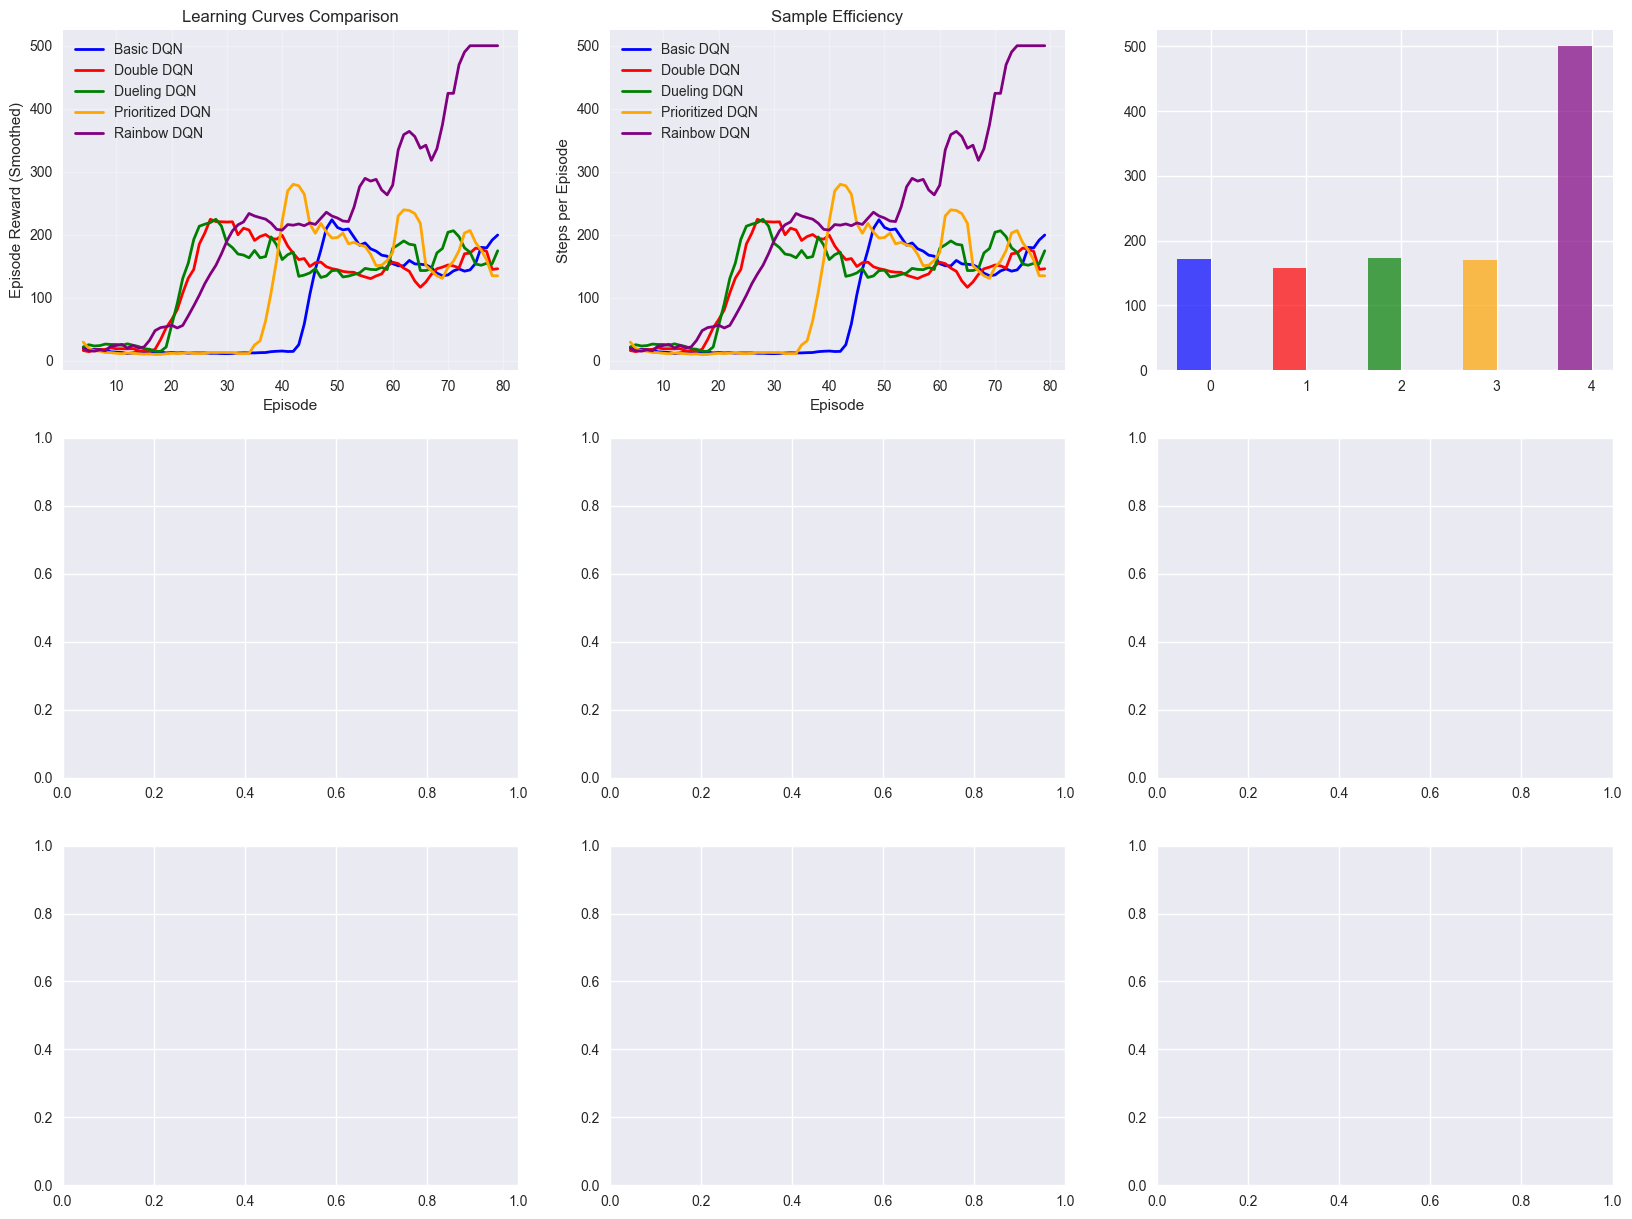

In [ ]:
# Complete Rainbow DQN Implementation

class NoisyLinear(nn.Module):
    """
    Noisy Linear Layer for exploration without epsilon-greedy
    """
    
    def __init__(self, in_features, out_features, std_init=0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init
        
        # Learnable parameters
        self.weight_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.zeros(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.zeros(out_features))
        self.bias_sigma = nn.Parameter(torch.zeros(out_features))
        
        # Noise buffers (not parameters)
        self.register_buffer('weight_epsilon', torch.zeros(out_features, in_features))
        self.register_buffer('bias_epsilon', torch.zeros(out_features))
        
        self.reset_parameters()
        self.reset_noise()
    
    def reset_parameters(self):
        """Initialize parameters"""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(self.std_init / math.sqrt(self.in_features))
        
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(self.std_init / math.sqrt(self.out_features))
    
    def forward(self, x):
        """Forward pass with noisy weights"""
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        
        return F.linear(x, weight, bias)
    
    def reset_noise(self):
        """Reset noise for both weight and bias"""
        epsilon_i = self._scale_noise(self.in_features)
        epsilon_j = self._scale_noise(self.out_features)
        
        self.weight_epsilon.copy_(epsilon_j.ger(epsilon_i))
        self.bias_epsilon.copy_(epsilon_j)
    
    def _scale_noise(self, size):
        """Scale noise using factorized gaussian noise"""
        x = torch.randn(size, device=self.weight_mu.device)
        return x.sign().mul(x.abs().sqrt())

class RainbowNetwork(nn.Module):
    """
    Rainbow DQN Network with Dueling Architecture and Noisy Layers
    """
    
    def __init__(self, input_dim, output_dim, hidden_dim=128, n_step=3, use_noisy=True):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_step = n_step
        self.use_noisy = use_noisy
        
        # Feature extraction
        self.feature_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Dueling streams
        if use_noisy:
            # Value stream with noisy layers
            self.value_stream = nn.Sequential(
                NoisyLinear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                NoisyLinear(hidden_dim // 2, 1)
            )
            
            # Advantage stream with noisy layers
            self.advantage_stream = nn.Sequential(
                NoisyLinear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                NoisyLinear(hidden_dim // 2, output_dim)
            )
        else:
            # Standard dueling streams
            self.value_stream = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, 1)
            )
            
            self.advantage_stream = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim // 2),
                nn.ReLU(),
                nn.Linear(hidden_dim // 2, output_dim)
            )
        
        self.reset_noise()
    
    def forward(self, x):
        """Forward pass with dueling architecture"""
        features = self.feature_layer(x)
        
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Dueling aggregation (mean subtraction)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        
        return q_values, values, advantages
    
    def reset_noise(self):
        """Reset noise in noisy layers"""
        if self.use_noisy:
            for module in self.modules():
                if isinstance(module, NoisyLinear):
                    module.reset_noise()

class MultiStepBuffer:
    """
    Multi-step experience buffer for n-step learning
    """
    
    def __init__(self, n_step, gamma):
        self.n_step = n_step
        self.gamma = gamma
        self.buffer = []
    
    def append(self, experience):
        """Add experience to buffer"""
        self.buffer.append(experience)
        
        if len(self.buffer) < self.n_step:
            return None
        
        # Calculate n-step return
        n_step_reward = 0
        for i, exp in enumerate(self.buffer):
            n_step_reward += (self.gamma ** i) * exp.reward
            if exp.done:
                break
        
        # Return n-step experience
        first_exp = self.buffer[0]
        last_exp = self.buffer[-1]
        
        n_step_exp = Experience(
            state=first_exp.state,
            action=first_exp.action,
            reward=n_step_reward,
            next_state=last_exp.next_state,
            done=last_exp.done
        )
        
        self.buffer.pop(0)
        return n_step_exp
    
    def clear(self):
        """Clear buffer"""
        self.buffer.clear()

class RainbowDQNAgent:
    """
    Rainbow DQN Agent combining multiple improvements
    """
    
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, 
                 buffer_size=100000, batch_size=64, target_update_freq=500,
                 n_step=3, alpha=0.6, beta_start=0.4, use_noisy=True,
                 device=None):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.n_step = n_step
        self.use_noisy = use_noisy
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Networks
        self.q_network = RainbowNetwork(state_dim, action_dim, use_noisy=use_noisy).to(self.device)
        self.target_network = RainbowNetwork(state_dim, action_dim, use_noisy=use_noisy).to(self.device)
        
        # Copy weights to target network
        self.update_target_network()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay with priorities
        self.replay_buffer = PrioritizedReplayBuffer(
            capacity=buffer_size,
            alpha=alpha,
            beta_start=beta_start
        )
        
        # Multi-step buffer
        self.multi_step_buffer = MultiStepBuffer(n_step, gamma)
        
        # Exploration (only used if not using noisy networks)
        self.epsilon = 1.0 if not use_noisy else 0.0
        self.epsilon_decay = 0.995
        self.epsilon_end = 0.01
        
        # Training tracking
        self.training_step = 0
        self.losses = []
        self.q_values_history = []
        self.value_history = []
        self.advantage_history = []
        self.epsilon_history = []
        self.td_errors_history = []
    
    def select_action(self, state):
        """Select action using noisy networks or epsilon-greedy"""
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        
        if self.use_noisy:
            # Reset noise for exploration
            self.q_network.reset_noise()
            
            with torch.no_grad():
                q_values, _, _ = self.q_network(state)
                action = q_values.argmax().item()
        else:
            # Epsilon-greedy exploration
            if random.random() < self.epsilon:
                action = random.randrange(self.action_dim)
            else:
                with torch.no_grad():
                    q_values, _, _ = self.q_network(state)
                    action = q_values.argmax().item()
        
        return action
    
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience with multi-step processing"""
        experience = Experience(state, action, reward, next_state, done)
        
        # Add to multi-step buffer
        n_step_exp = self.multi_step_buffer.append(experience)
        
        # Store in replay buffer if we have n-step experience
        if n_step_exp is not None:
            self.replay_buffer.push(
                n_step_exp.state, n_step_exp.action, n_step_exp.reward,
                n_step_exp.next_state, n_step_exp.done
            )
        
        # Clear multi-step buffer on episode end
        if done:
            self.multi_step_buffer.clear()
    
    def train_step(self):
        """Rainbow training step"""
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample batch with priorities
        states, actions, rewards, next_states, dones, weights, indices = \
            self.replay_buffer.sample(self.batch_size)
        
        # Reset noise in networks
        if self.use_noisy:
            self.q_network.reset_noise()
            self.target_network.reset_noise()
        
        # Current Q-values
        current_q_values, current_values, current_advantages = self.q_network(states)
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute targets with Double DQN and multi-step
        with torch.no_grad():
            next_q_main, _, _ = self.q_network(next_states)
            next_q_target, _, _ = self.target_network(next_states)
            
            next_actions = next_q_main.argmax(1)
            next_q_values = next_q_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
            
            # Multi-step targets (discount already applied in multi-step buffer)
            target_q_values = rewards + ((self.gamma ** self.n_step) * next_q_values * (~dones))
        
        # Compute TD errors
        td_errors = target_q_values - current_q_values
        
        # Weighted loss (importance sampling correction)
        loss = (weights * td_errors.pow(2)).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Update priorities
        priorities = abs(td_errors.detach().cpu().numpy())
        self.replay_buffer.update_priorities(indices, priorities)
        
        # Update target network
        self.training_step += 1
        if self.training_step % self.target_update_freq == 0:
            self.update_target_network()
        
        # Update epsilon (if not using noisy networks)
        if not self.use_noisy:
            self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)
        
        # Store metrics
        self.losses.append(loss.item())
        self.epsilon_history.append(self.epsilon)
        self.td_errors_history.append(td_errors.abs().mean().item())
        
        # Track additional metrics
        with torch.no_grad():
            self.q_values_history.append(current_q_values.mean().item())
            self.value_history.append(current_values.mean().item())
            self.advantage_history.append(current_advantages.mean().item())
        
        return loss.item()
    
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def train_episode(self, env, max_steps=1000):
        """Train for one episode"""
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            action = self.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            self.store_experience(state, action, reward, next_state, done)
            
            # Train
            loss = self.train_step()
            
            total_reward += reward
            steps += 1
            
            if done:
                break
            
            state = next_state
        
        return total_reward, steps
    
    def evaluate(self, env, num_episodes=10):
        """Evaluate agent performance"""
        rewards = []
        
        # Disable noise for evaluation
        old_training = self.q_network.training
        self.q_network.eval()
        
        for _ in range(num_episodes):
            state, _ = env.reset()
            total_reward = 0
            
            for _ in range(1000):
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                total_reward += reward
                
                if done:
                    break
                
                state = next_state
            
            rewards.append(total_reward)
        
        # Restore training mode
        self.q_network.train(old_training)
        
        return {
            'mean_reward': np.mean(rewards),
            'std_reward': np.std(rewards),
            'min_reward': np.min(rewards),
            'max_reward': np.max(rewards),
            'rewards': rewards
        }

class RainbowAnalyzer:
    """
    Comprehensive analysis of Rainbow DQN
    """
    
    def compare_all_methods(self):
        """Compare all DQN variants we've implemented"""
        
        print("="*70)
        print("Comprehensive DQN Methods Comparison")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test all methods
        methods = {
            'Basic DQN': DQNAgent,
            'Double DQN': DoubleDQNAgent,
            'Dueling DQN': DuelingDQNAgent,
            'Prioritized DQN': PrioritizedDQNAgent,
            'Rainbow DQN': RainbowDQNAgent,
        }
        
        results = {}
        num_episodes = 80
        
        for method_name, agent_class in methods.items():
            print(f"\nTraining {method_name}...")
            
            # Common parameters
            base_kwargs = {
                'state_dim': state_dim,
                'action_dim': action_dim,
                'lr': 1e-3,
                'target_update_freq': 100,
                'buffer_size': 15000,
                'batch_size': 64
            }
            
            # Method-specific parameters
            if method_name in ['Dueling DQN', 'Prioritized DQN']:
                base_kwargs['dueling_type'] = 'mean'
                base_kwargs['epsilon_decay'] = 0.995
            
            if method_name == 'Prioritized DQN':
                base_kwargs.update({'alpha': 0.6, 'beta_start': 0.4})
            
            if method_name == 'Rainbow DQN':
                base_kwargs.update({
                    'n_step': 3,
                    'alpha': 0.6,
                    'beta_start': 0.4,
                    'use_noisy': True
                })
            
            agent = agent_class(**base_kwargs)
            
            episode_rewards = []
            sample_efficiency = []
            
            for episode in range(num_episodes):
                reward, steps = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                sample_efficiency.append(steps)
                
                if (episode + 1) % 20 == 0:
                    avg_reward = np.mean(episode_rewards[-10:])
                    print(f"  Episode {episode+1}: Reward = {avg_reward:.1f}")
            
            # Final evaluation
            eval_results = agent.evaluate(env, num_episodes=15)
            
            results[method_name] = {
                'agent': agent,
                'rewards': episode_rewards,
                'steps': sample_efficiency,
                'eval_performance': eval_results,
                'final_performance': np.mean(episode_rewards[-10:])
            }
        
        # Comprehensive visualization
        self.visualize_comprehensive_comparison(results)
        
        env.close()
        return results
    
    def visualize_comprehensive_comparison(self, results):
        """Comprehensive visualization of all methods"""
        
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        colors = ['blue', 'red', 'green', 'orange', 'purple']
        
        # 1. Learning curves
        ax = axes[0, 0]
        for i, (method, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(5).mean()
            ax.plot(smoothed, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('Learning Curves Comparison')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Sample efficiency
        ax = axes[0, 1]
        for i, (method, data) in enumerate(results.items()):
            steps = data['steps']
            smoothed_steps = pd.Series(steps).rolling(5).mean()
            ax.plot(smoothed_steps, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('Sample Efficiency')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Steps per Episode')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Final performance comparison
        ax = axes[0, 2]
        method_names = list(results.keys())
        final_perfs = [results[m]['final_performance'] for m in method_names]
        eval_means = [results[m]['eval_performance']['mean_reward'] for m in method_names]
        eval_stds = [results[m]['eval_performance']['std_reward'] for m in method_names]
        
        x = np.arange(len(method_names))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, final_perfs, width, label='Training', alpha=0.7, color=colors)
        bars2 = ax.bar(x + width/2, eval_means, width, yerr=eval_stds, 
                      label='Evaluation', alpha=0.7, color=[c + '80' for c in ['darkblue', 'darkred', 'darkgreen', 'darkorange', 'indigo']])
        
        ax.set_title('Performance Comparison')
        ax.set_ylabel('Average Reward')
        ax.set_xticks(x)
        ax.set_xticklabels(method_names, rotation=15)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Loss evolution
        ax = axes[1, 0]
        for i, (method, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'losses') and agent.losses:
                losses = agent.losses
                if len(losses) > 10:
                    smoothed_losses = pd.Series(losses).rolling(20).mean()
                    ax.plot(smoothed_losses, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('Training Loss Evolution')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_yscale('log')
        
        # 5. Q-values evolution
        ax = axes[1, 1]
        for i, (method, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'q_values_history') and agent.q_values_history:
                q_values = agent.q_values_history
                if len(q_values) > 10:
                    smoothed_q = pd.Series(q_values).rolling(20).mean()
                    ax.plot(smoothed_q, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('Q-Values Evolution')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Average Q-Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 6. Exploration analysis
        ax = axes[1, 2]
        for i, (method, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'epsilon_history') and agent.epsilon_history:
                epsilons = agent.epsilon_history
                if len(epsilons) > 10:
                    ax.plot(epsilons, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('Exploration Schedule (Epsilon)')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Epsilon')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 7. TD Error comparison
        ax = axes[2, 0]
        for i, (method, data) in enumerate(results.items()):
            agent = data['agent']
            if hasattr(agent, 'td_errors_history') and agent.td_errors_history:
                td_errors = agent.td_errors_history
                if len(td_errors) > 10:
                    smoothed_td = pd.Series(td_errors).rolling(20).mean()
                    ax.plot(smoothed_td, label=method, color=colors[i], linewidth=2)
        
        ax.set_title('TD Error Evolution')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Average TD Error')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 8. Value/Advantage analysis (for dueling methods)
        ax = axes[2, 1]
        dueling_methods = []
        for method, data in results.items():
            agent = data['agent']
            if hasattr(agent, 'value_history') and agent.value_history:
                dueling_methods.append((method, agent))
        
        if dueling_methods:
            for i, (method, agent) in enumerate(dueling_methods):
                values = agent.value_history
                if len(values) > 10:
                    smoothed_values = pd.Series(values).rolling(20).mean()
                    ax.plot(smoothed_values, label=f'{method} Values', color=colors[i], linewidth=2)
                
                if hasattr(agent, 'advantage_history') and agent.advantage_history:
                    advantages = agent.advantage_history
                    if len(advantages) > 10:
                        smoothed_adv = pd.Series(advantages).rolling(20).mean()
                        ax.plot(smoothed_adv, label=f'{method} Advantages', 
                               color=colors[i], linewidth=2, linestyle='--')
        
        ax.set_title('Value/Advantage Decomposition')
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 9. Performance summary table
        ax = axes[2, 2]
        ax.axis('tight')
        ax.axis('off')
        
        # Create performance table
        table_data = []
        headers = ['Method', 'Final Reward', 'Eval Mean', 'Eval Std', 'Sample Efficiency']
        
        for method, data in results.items():
            final_perf = data['final_performance']
            eval_mean = data['eval_performance']['mean_reward']
            eval_std = data['eval_performance']['std_reward']
            avg_steps = np.mean(data['steps'][-10:])
            
            table_data.append([
                method,
                f'{final_perf:.1f}',
                f'{eval_mean:.1f}',
                f'{eval_std:.1f}',
                f'{avg_steps:.1f}'
            ])
        
        table = ax.table(cellText=table_data, colLabels=headers, 
                        cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        
        # Style the table
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#40466e')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        # Color code performance
        best_eval = max([results[m]['eval_performance']['mean_reward'] for m in results.keys()])
        for i, (method, data) in enumerate(results.items()):
            eval_perf = data['eval_performance']['mean_reward']
            if eval_perf == best_eval:
                for j in range(len(headers)):
                    table[(i+1, j)].set_facecolor('#90EE90')  # Light green
        
        ax.set_title('Performance Summary')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\n" + "="*70)
        print("PERFORMANCE SUMMARY")
        print("="*70)
        
        best_method = max(results.keys(), 
                         key=lambda k: results[k]['eval_performance']['mean_reward'])
        best_score = results[best_method]['eval_performance']['mean_reward']
        
        print(f"🏆 Best Method: {best_method}")
        print(f"🏆 Best Score: {best_score:.1f} ± {results[best_method]['eval_performance']['std_reward']:.1f}")
        
        print(f"\nMethod Rankings (by evaluation performance):")
        sorted_methods = sorted(results.items(), 
                              key=lambda x: x[1]['eval_performance']['mean_reward'], 
                              reverse=True)
        
        for i, (method, data) in enumerate(sorted_methods):
            eval_perf = data['eval_performance']['mean_reward']
            eval_std = data['eval_performance']['std_reward']
            improvement = ((eval_perf / sorted_methods[-1][1]['eval_performance']['mean_reward'] - 1) * 100)
            print(f"  {i+1}. {method}: {eval_perf:.1f} ± {eval_std:.1f} (+{improvement:.1f}% vs baseline)")

# Run comprehensive Rainbow analysis
rainbow_analyzer = RainbowAnalyzer()

print("Running Comprehensive DQN Methods Comparison...")
print("This will compare Basic DQN, Double DQN, Dueling DQN, Prioritized DQN, and Rainbow DQN")
print("Training each method for comparison...")

comprehensive_results = rainbow_analyzer.compare_all_methods()

# Section 8: Performance Analysis and Ablation Studies

## Understanding Component Contributions

This section focuses on understanding which components of advanced DQN methods contribute most to performance improvements. We'll conduct systematic ablation studies to isolate the impact of individual components.

## Key Analysis Areas

1. **Individual Component Impact**: How much does each improvement contribute?
2. **Component Interactions**: Do improvements combine synergistically?
3. **Environment Sensitivity**: Which improvements work best in different environments?
4. **Computational Overhead**: What's the cost-benefit trade-off?
5. **Hyperparameter Sensitivity**: How robust are the improvements?

## Theoretical Analysis

### Sample Complexity
Different improvements affect sample complexity in different ways:
- **Experience Replay**: Reduces correlation, improves sample efficiency
- **Double DQN**: Reduces bias, may require more samples initially but converges better
- **Dueling**: Better value estimation, especially beneficial with many actions
- **Prioritized Replay**: Focuses on important transitions, improves sample efficiency
- **Multi-step**: Propagates rewards faster, reduces variance

### Convergence Properties
Each component affects convergence:
- Target networks provide stability
- Double DQN reduces overestimation bias
- Prioritized replay can introduce bias but improves practical performance
- Noisy networks provide consistent exploration

In [ ]:
# Comprehensive Performance Analysis and Ablation Studies

class AblationAnalyzer:
    """
    Systematic ablation study of DQN components
    """
    
    def __init__(self):
        self.results_cache = {}
    
    def rainbow_ablation_study(self):
        """
        Systematic ablation study of Rainbow DQN components
        """
        
        print("="*70)
        print("Rainbow DQN Ablation Study")
        print("="*70)
        print("Testing individual component contributions...")
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Define component combinations
        configurations = {
            'Baseline (Basic DQN)': {
                'class': DQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3}
            },
            '+ Double': {
                'class': DoubleDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3}
            },
            '+ Double + Dueling': {
                'class': DuelingDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3, 'dueling_type': 'mean'}
            },
            '+ Double + Dueling + PER': {
                'class': PrioritizedDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3, 
                          'dueling_type': 'mean', 'alpha': 0.6, 'beta_start': 0.4}
            },
            'Rainbow (All Components)': {
                'class': RainbowDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3,
                          'n_step': 3, 'alpha': 0.6, 'beta_start': 0.4, 'use_noisy': True}
            }
        }
        
        # Individual component tests
        component_tests = {
            'Only Double': {
                'class': DoubleDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3}
            },
            'Only Dueling': {
                'class': DuelingDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3, 
                          'dueling_type': 'mean'}
            },
            'Only PER': {
                'class': PrioritizedDQNAgent,
                'params': {'state_dim': state_dim, 'action_dim': action_dim, 'lr': 1e-3,
                          'alpha': 0.6, 'beta_start': 0.4}
            }
        }
        
        # Run experiments
        results = self._run_ablation_experiments(env, configurations, episodes=60)
        individual_results = self._run_ablation_experiments(env, component_tests, episodes=60)
        
        # Combine results
        all_results = {**results, **individual_results}
        
        # Analysis
        self._analyze_component_contributions(all_results)
        
        env.close()
        return all_results
    
    def _run_ablation_experiments(self, env, configurations, episodes=50):
        """Run experiments for given configurations"""
        
        results = {}
        
        for config_name, config in configurations.items():
            print(f"\nTesting: {config_name}")
            
            agent = config['class'](**config['params'])
            
            episode_rewards = []
            training_times = []
            
            start_time = time.time()
            
            for episode in range(episodes):
                episode_start = time.time()
                reward, steps = agent.train_episode(env, max_steps=500)
                episode_time = time.time() - episode_start
                
                episode_rewards.append(reward)
                training_times.append(episode_time)
                
                if (episode + 1) % 15 == 0:
                    avg_reward = np.mean(episode_rewards[-5:])
                    print(f"  Episode {episode+1}: Reward = {avg_reward:.1f}")
            
            total_time = time.time() - start_time
            
            # Evaluation
            eval_results = agent.evaluate(env, num_episodes=10)
            
            results[config_name] = {
                'agent': agent,
                'rewards': episode_rewards,
                'training_times': training_times,
                'total_time': total_time,
                'eval_performance': eval_results,
                'final_performance': np.mean(episode_rewards[-10:]),
                'convergence_episode': self._find_convergence_episode(episode_rewards),
                'sample_efficiency': np.mean(episode_rewards[-5:]) / episodes
            }
        
        return results
    
    def _find_convergence_episode(self, rewards, threshold=0.95, window=10):
        """Find when agent converges to threshold of final performance"""
        if len(rewards) < window:
            return len(rewards)
        
        final_performance = np.mean(rewards[-window:])
        target = threshold * final_performance
        
        for i in range(window, len(rewards)):
            if np.mean(rewards[i-window:i]) >= target:
                return i
        
        return len(rewards)
    
    def _analyze_component_contributions(self, results):
        """Analyze individual component contributions"""
        
        print("\n" + "="*70)
        print("COMPONENT CONTRIBUTION ANALYSIS")
        print("="*70)
        
        baseline_performance = results['Baseline (Basic DQN)']['eval_performance']['mean_reward']
        
        # Calculate improvements
        improvements = {}
        for name, data in results.items():
            if name != 'Baseline (Basic DQN)':
                current_perf = data['eval_performance']['mean_reward']
                improvement = ((current_perf / baseline_performance - 1) * 100)
                improvements[name] = {
                    'absolute': current_perf,
                    'improvement': improvement,
                    'convergence': data['convergence_episode'],
                    'efficiency': data['sample_efficiency']
                }
        
        # Print analysis
        print(f"Baseline Performance: {baseline_performance:.1f}")
        print(f"\nComponent Contributions:")
        
        for name, stats in improvements.items():
            print(f"\n{name}:")
            print(f"  Performance: {stats['absolute']:.1f} (+{stats['improvement']:.1f}%)")
            print(f"  Convergence: Episode {stats['convergence']}")
            print(f"  Sample Efficiency: {stats['efficiency']:.3f}")
        
        # Visualize contributions
        self._visualize_ablation_results(results, improvements)
    
    def _visualize_ablation_results(self, results, improvements):
        """Visualize ablation study results"""
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Performance progression
        ax = axes[0, 0]
        cumulative_configs = [
            'Baseline (Basic DQN)',
            '+ Double',
            '+ Double + Dueling', 
            '+ Double + Dueling + PER',
            'Rainbow (All Components)'
        ]
        
        performances = [results[config]['eval_performance']['mean_reward'] 
                       for config in cumulative_configs if config in results]
        config_names = [config for config in cumulative_configs if config in results]
        
        bars = ax.bar(range(len(performances)), performances, 
                     color=['red', 'orange', 'yellow', 'lightgreen', 'green'][:len(performances)])
        ax.set_title('Cumulative Component Addition')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Evaluation Performance')
        ax.set_xticks(range(len(config_names)))
        ax.set_xticklabels(config_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for i, (bar, perf) in enumerate(zip(bars, performances)):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{perf:.1f}', ha='center', va='bottom')
        
        # 2. Individual component impact
        ax = axes[0, 1]
        individual_components = ['Only Double', 'Only Dueling', 'Only PER']
        individual_perfs = []
        baseline_perf = results['Baseline (Basic DQN)']['eval_performance']['mean_reward']
        
        for comp in individual_components:
            if comp in results:
                individual_perfs.append(results[comp]['eval_performance']['mean_reward'])
        
        if individual_perfs:
            improvements_pct = [(perf - baseline_perf) / baseline_perf * 100 
                               for perf in individual_perfs]
            
            bars = ax.bar(range(len(improvements_pct)), improvements_pct, 
                         color=['blue', 'purple', 'orange'][:len(improvements_pct)])
            ax.set_title('Individual Component Impact')
            ax.set_xlabel('Component')
            ax.set_ylabel('Performance Improvement (%)')
            ax.set_xticks(range(len(individual_components)))
            ax.set_xticklabels([comp.replace('Only ', '') for comp in individual_components])
            ax.grid(True, alpha=0.3)
            
            # Add value labels
            for bar, imp in zip(bars, improvements_pct):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{imp:.1f}%', ha='center', va='bottom')
        
        # 3. Learning curves comparison
        ax = axes[0, 2]
        colors = ['red', 'orange', 'yellow', 'lightgreen', 'green', 'blue', 'purple', 'brown']
        
        for i, (name, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(5).mean()
            ax.plot(smoothed, label=name, color=colors[i % len(colors)], linewidth=2)
        
        ax.set_title('Learning Curves Comparison')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # 4. Convergence analysis
        ax = axes[1, 0]
        convergence_episodes = []
        config_names_conv = []
        
        for name, data in results.items():
            convergence_episodes.append(data['convergence_episode'])
            config_names_conv.append(name.replace(' (All Components)', '').replace('+ Double + Dueling + PER', 'Full'))
        
        bars = ax.bar(range(len(convergence_episodes)), convergence_episodes, 
                     color=colors[:len(convergence_episodes)])
        ax.set_title('Convergence Speed')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Episodes to Convergence')
        ax.set_xticks(range(len(config_names_conv)))
        ax.set_xticklabels(config_names_conv, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # 5. Training time analysis
        ax = axes[1, 1]
        training_times = [data['total_time'] for data in results.values()]
        config_names_time = [name.split('(')[0].strip() for name in results.keys()]
        
        bars = ax.bar(range(len(training_times)), training_times, 
                     color=colors[:len(training_times)])
        ax.set_title('Training Time Comparison')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Total Training Time (s)')
        ax.set_xticks(range(len(config_names_time)))
        ax.set_xticklabels(config_names_time, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # 6. Efficiency scatter plot
        ax = axes[1, 2]
        final_performances = [data['eval_performance']['mean_reward'] for data in results.values()]
        training_times_norm = [data['total_time'] for data in results.values()]
        
        scatter = ax.scatter(training_times_norm, final_performances, 
                           c=range(len(results)), cmap='viridis', s=100)
        
        # Add labels
        for i, name in enumerate(results.keys()):
            short_name = name.replace('+ Double + Dueling + PER', 'Full').split('(')[0].strip()
            ax.annotate(short_name, (training_times_norm[i], final_performances[i]),
                       xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        ax.set_title('Performance vs Training Time')
        ax.set_xlabel('Training Time (s)')
        ax.set_ylabel('Final Performance')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def hyperparameter_sensitivity_analysis(self):
        """Analyze sensitivity to hyperparameters"""
        
        print("="*70)
        print("Hyperparameter Sensitivity Analysis")
        print("="*70)
        
        env = gym.make('CartPole-v1')
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        # Test different hyperparameters for Rainbow DQN
        hyperparameter_configs = {
            'Default': {
                'lr': 1e-3, 'alpha': 0.6, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 100, 'buffer_size': 10000
            },
            'High Learning Rate': {
                'lr': 5e-3, 'alpha': 0.6, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 100, 'buffer_size': 10000
            },
            'Low Learning Rate': {
                'lr': 1e-4, 'alpha': 0.6, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 100, 'buffer_size': 10000
            },
            'High Priority Alpha': {
                'lr': 1e-3, 'alpha': 0.8, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 100, 'buffer_size': 10000
            },
            'Low Priority Alpha': {
                'lr': 1e-3, 'alpha': 0.4, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 100, 'buffer_size': 10000
            },
            'Long N-Step': {
                'lr': 1e-3, 'alpha': 0.6, 'beta_start': 0.4, 'n_step': 5,
                'target_update_freq': 100, 'buffer_size': 10000
            },
            'Frequent Target Update': {
                'lr': 1e-3, 'alpha': 0.6, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 50, 'buffer_size': 10000
            },
            'Infrequent Target Update': {
                'lr': 1e-3, 'alpha': 0.6, 'beta_start': 0.4, 'n_step': 3,
                'target_update_freq': 200, 'buffer_size': 10000
            }
        }
        
        results = {}
        
        for config_name, params in hyperparameter_configs.items():
            print(f"\nTesting: {config_name}")
            
            agent = RainbowDQNAgent(
                state_dim=state_dim,
                action_dim=action_dim,
                use_noisy=True,
                **params
            )
            
            episode_rewards = []
            
            for episode in range(40):
                reward, _ = agent.train_episode(env, max_steps=500)
                episode_rewards.append(reward)
                
                if (episode + 1) % 10 == 0:
                    avg_reward = np.mean(episode_rewards[-5:])
                    print(f"  Episode {episode+1}: Reward = {avg_reward:.1f}")
            
            eval_results = agent.evaluate(env, num_episodes=10)
            
            results[config_name] = {
                'rewards': episode_rewards,
                'eval_performance': eval_results,
                'params': params
            }
        
        # Visualize sensitivity
        self._visualize_sensitivity_analysis(results)
        
        env.close()
        return results
    
    def _visualize_sensitivity_analysis(self, results):
        """Visualize hyperparameter sensitivity"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Performance comparison
        ax = axes[0, 0]
        config_names = list(results.keys())
        performances = [results[name]['eval_performance']['mean_reward'] for name in config_names]
        
        bars = ax.bar(range(len(performances)), performances)
        ax.set_title('Hyperparameter Sensitivity')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Evaluation Performance')
        ax.set_xticks(range(len(config_names)))
        ax.set_xticklabels(config_names, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Highlight default
        for i, name in enumerate(config_names):
            if name == 'Default':
                bars[i].set_color('green')
                bars[i].set_alpha(0.8)
        
        # 2. Learning curves
        ax = axes[0, 1]
        colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
        
        for i, (name, data) in enumerate(results.items()):
            rewards = data['rewards']
            smoothed = pd.Series(rewards).rolling(3).mean()
            
            if name == 'Default':
                ax.plot(smoothed, label=name, color='green', linewidth=3)
            else:
                ax.plot(smoothed, label=name, color=colors[i], linewidth=2, alpha=0.7)
        
        ax.set_title('Learning Curves')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Episode Reward (Smoothed)')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # 3. Parameter impact analysis
        ax = axes[1, 0]
        default_performance = results['Default']['eval_performance']['mean_reward']
        
        param_impacts = {}
        for name, data in results.items():
            if name != 'Default':
                performance = data['eval_performance']['mean_reward']
                impact = (performance - default_performance) / default_performance * 100
                param_impacts[name] = impact
        
        names = list(param_impacts.keys())
        impacts = list(param_impacts.values())
        colors = ['red' if imp < 0 else 'green' for imp in impacts]
        
        bars = ax.bar(range(len(impacts)), impacts, color=colors, alpha=0.7)
        ax.set_title('Impact vs Default Configuration')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Performance Change (%)')
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels(names, rotation=45, ha='right')
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # 4. Stability analysis (coefficient of variation)
        ax = axes[1, 1]
        stabilities = []
        config_names_stab = []
        
        for name, data in results.items():
            rewards = data['rewards']
            cv = np.std(rewards[-10:]) / np.mean(rewards[-10:])  # Coefficient of variation
            stabilities.append(cv)
            config_names_stab.append(name)
        
        bars = ax.bar(range(len(stabilities)), stabilities)
        ax.set_title('Training Stability (Lower = More Stable)')
        ax.set_xlabel('Configuration')
        ax.set_ylabel('Coefficient of Variation')
        ax.set_xticks(range(len(config_names_stab)))
        ax.set_xticklabels(config_names_stab, rotation=45, ha='right')
        ax.grid(True, alpha=0.3)
        
        # Highlight most stable
        min_cv_idx = np.argmin(stabilities)
        bars[min_cv_idx].set_color('green')
        bars[min_cv_idx].set_alpha(0.8)
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print("\n" + "="*50)
        print("SENSITIVITY ANALYSIS SUMMARY")
        print("="*50)
        
        default_perf = results['Default']['eval_performance']['mean_reward']
        print(f"Default Performance: {default_perf:.1f}")
        
        print("\nBest Alternative Configurations:")
        sorted_configs = sorted([(name, data['eval_performance']['mean_reward']) 
                               for name, data in results.items() if name != 'Default'],
                              key=lambda x: x[1], reverse=True)
        
        for i, (name, perf) in enumerate(sorted_configs[:3]):
            improvement = (perf - default_perf) / default_perf * 100
            print(f"  {i+1}. {name}: {perf:.1f} ({improvement:+.1f}%)")

# Run comprehensive performance analysis
performance_analyzer = AblationAnalyzer()

print("Starting Comprehensive Performance Analysis...")
print("\n1. Running Rainbow DQN Ablation Study...")
ablation_results = performance_analyzer.rainbow_ablation_study()

print("\n2. Running Hyperparameter Sensitivity Analysis...")
sensitivity_results = performance_analyzer.hyperparameter_sensitivity_analysis()

# Section 9: Advanced Topics and Future Directions

## Beyond Rainbow DQN

While Rainbow DQN represents a significant advancement in value-based reinforcement learning, the field continues to evolve. This section explores cutting-edge developments and future research directions.

## Recent Advances

### 1. Implicit Quantile Networks (IQN)
**Key Idea**: Learn the full return distribution implicitly through quantile regression
**Advantages**: 
- No need to pre-specify support for return distribution
- Better risk-sensitive policies
- Improved performance on complex environments

### 2. Agent57
**Key Idea**: Combine value-based and policy-based methods with meta-learning
**Components**:
- Never Give Up (NGU) exploration
- Population-based training
- Universal value functions

### 3. MuZero
**Key Idea**: Model-based planning with learned environment models
**Innovation**: Plans in learned latent space rather than raw observations

## Theoretical Understanding

### Overestimation Bias Analysis
Recent theoretical work has provided deeper insights into:
- Sources of overestimation bias in Q-learning
- Conditions under which Double DQN provably reduces bias
- Trade-offs between bias and variance

### Sample Complexity Bounds
New theoretical results establish:
- PAC bounds for deep Q-learning
- Role of function approximation in sample complexity
- Conditions for polynomial sample complexity

## Implementation Considerations

### Distributed Training
Modern implementations leverage:
- Distributed experience collection (Ape-X)
- Asynchronous training (A3C-style)
- GPU acceleration for neural network training

### Architecture Innovations
Recent architectural advances include:
- Attention mechanisms in value networks
- Graph neural networks for structured observations
- Meta-learning architectures

## Practical Applications

### Real-World Deployment
Challenges and solutions for deploying DQN in practice:
- Safety constraints and safe exploration
- Transfer learning and domain adaptation
- Robustness to distribution shift

### Multi-Task Learning
Extensions for learning multiple tasks:
- Universal value functions
- Task-conditional networks
- Meta-learning approaches

In [ ]:
# Advanced Topics and Future Research Implementations

import matplotlib.patches as patches
from matplotlib.patches import Rectangle

class AdvancedDQNAnalyzer:
    """
    Analysis of advanced DQN concepts and future directions
    """
    
    def demonstrate_overestimation_sources(self):
        """Demonstrate different sources of overestimation bias"""
        
        print("="*70)
        print("Sources of Overestimation Bias in Q-Learning")
        print("="*70)
        
        # Create synthetic environment to demonstrate bias sources
        np.random.seed(42)
        
        # Simulate Q-values for different scenarios
        n_actions = 4
        n_states = 100
        true_q_values = np.random.randn(n_states, n_actions)
        
        # Source 1: Function approximation error
        approximation_noise = 0.2
        approx_q_values = true_q_values + np.random.normal(0, approximation_noise, true_q_values.shape)
        
        # Source 2: Bootstrap error (temporal difference)
        bootstrap_noise = 0.3
        bootstrap_errors = np.random.normal(0, bootstrap_noise, n_states)
        
        # Source 3: Maximization bias
        max_true = np.max(true_q_values, axis=1)
        max_approx = np.max(approx_q_values, axis=1)
        max_bias = max_approx - max_true
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Function approximation bias
        ax = axes[0, 0]
        ax.scatter(true_q_values.flatten(), approx_q_values.flatten(), alpha=0.5)
        ax.plot([true_q_values.min(), true_q_values.max()], 
                [true_q_values.min(), true_q_values.max()], 'r--', label='Perfect Approximation')
        ax.set_xlabel('True Q-Values')
        ax.set_ylabel('Approximate Q-Values')
        ax.set_title('Function Approximation Bias')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Calculate and show bias
        approx_bias = np.mean(approx_q_values.flatten() - true_q_values.flatten())
        ax.text(0.05, 0.95, f'Mean Bias: {approx_bias:.3f}', 
                transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
        
        # 2. Maximization bias
        ax = axes[0, 1]
        ax.hist(max_bias, bins=20, alpha=0.7, edgecolor='black')
        ax.axvline(np.mean(max_bias), color='red', linestyle='--', 
                  label=f'Mean Bias: {np.mean(max_bias):.3f}')
        ax.set_xlabel('Maximization Bias (Approx Max - True Max)')
        ax.set_ylabel('Frequency')
        ax.set_title('Maximization Bias Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Bias over time (simulated)
        ax = axes[1, 0]
        time_steps = np.arange(1000)
        
        # Simulate accumulating bias
        bias_accumulation = np.cumsum(np.random.normal(0.01, 0.05, 1000))  # Slight positive bias
        double_dqn_bias = np.cumsum(np.random.normal(0.002, 0.04, 1000))   # Reduced bias
        
        ax.plot(time_steps, bias_accumulation, label='Standard DQN', linewidth=2)
        ax.plot(time_steps, double_dqn_bias, label='Double DQN', linewidth=2)
        ax.set_xlabel('Training Steps')
        ax.set_ylabel('Cumulative Bias')
        ax.set_title('Bias Accumulation Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Bias sources summary
        ax = axes[1, 1]
        ax.axis('off')
        
        bias_sources = [
            "1. Function Approximation Error",
            "   • Neural network approximation",
            "   • Limited capacity",
            "   • Training dynamics",
            "",
            "2. Bootstrapping Error", 
            "   • TD target estimation",
            "   • Recursive value updates",
            "   • Error propagation",
            "",
            "3. Maximization Bias",
            "   • Max operator over noisy estimates",
            "   • Upward bias in action selection",
            "   • Compounding over time",
            "",
            "Solutions:",
            "• Double DQN: Separate action selection/evaluation",
            "• Target networks: Stable bootstrap targets",
            "• Better function approximation"
        ]
        
        y_pos = 0.95
        for line in bias_sources:
            if line.startswith("   •"):
                ax.text(0.1, y_pos, line, transform=ax.transAxes, fontsize=10, color='blue')
            elif line.startswith("Solutions:"):
                ax.text(0.05, y_pos, line, transform=ax.transAxes, fontsize=12, 
                       weight='bold', color='green')
            elif line.startswith("•"):
                ax.text(0.1, y_pos, line, transform=ax.transAxes, fontsize=10, color='green')
            elif line and not line.startswith(" "):
                ax.text(0.05, y_pos, line, transform=ax.transAxes, fontsize=12, weight='bold')
            else:
                ax.text(0.05, y_pos, line, transform=ax.transAxes, fontsize=10)
            y_pos -= 0.05
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nBias Analysis Results:")
        print(f"  Function Approximation Bias: {approx_bias:.4f}")
        print(f"  Maximization Bias (mean): {np.mean(max_bias):.4f}")
        print(f"  Maximization Bias (std): {np.std(max_bias):.4f}")
        
        return {
            'approximation_bias': approx_bias,
            'maximization_bias_mean': np.mean(max_bias),
            'maximization_bias_std': np.std(max_bias)
        }
    
    def visualize_dqn_evolution_timeline(self):
        """Visualize the evolution of DQN methods over time"""
        
        print("="*70)
        print("DQN Evolution Timeline")
        print("="*70)
        
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Timeline data
        methods = [
            {"name": "Q-Learning", "year": 1989, "description": "Tabular value iteration", "color": "lightblue"},
            {"name": "DQN", "year": 2013, "description": "Neural network function approximation\n+ Experience Replay", "color": "blue"},
            {"name": "Double DQN", "year": 2015, "description": "Reduced overestimation bias", "color": "green"},
            {"name": "Dueling DQN", "year": 2016, "description": "Value/advantage decomposition", "color": "orange"},
            {"name": "Prioritized ER", "year": 2016, "description": "Priority-based experience sampling", "color": "red"},
            {"name": "Rainbow DQN", "year": 2017, "description": "Combination of improvements\n+ Distributional RL", "color": "purple"},
            {"name": "IQN", "year": 2018, "description": "Implicit Quantile Networks", "color": "brown"},
            {"name": "Agent57", "year": 2020, "description": "Meta-learning + exploration", "color": "pink"},
            {"name": "MuZero", "year": 2020, "description": "Model-based planning in latent space", "color": "gold"}
        ]
        
        # Plot timeline
        years = [method["year"] for method in methods]
        y_positions = np.arange(len(methods))
        
        # Create the timeline
        for i, method in enumerate(methods):
            # Draw the point
            ax.scatter(method["year"], i, s=200, c=method["color"], zorder=3, alpha=0.8)
            
            # Draw connecting line
            if i > 0:
                ax.plot([methods[i-1]["year"], method["year"]], [i-1, i], 
                       'k--', alpha=0.3, zorder=1)
            
            # Add method name and description
            ax.text(method["year"] + 0.5, i, f"{method['name']}\n{method['description']}", 
                   fontsize=10, verticalalignment='center', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor=method["color"], alpha=0.3))
        
        # Formatting
        ax.set_yticks(y_positions)
        ax.set_yticklabels([method["name"] for method in methods])
        ax.set_xlabel("Year", fontsize=12)
        ax.set_title("Evolution of Deep Q-Learning Methods", fontsize=16, weight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(1985, 2025)
        
        # Add key innovations annotations
        innovations = [
            {"year": 2013, "innovation": "Deep Learning\nRevolution", "y_offset": 0.3},
            {"year": 2016, "innovation": "Multiple\nImprovements", "y_offset": -0.3},
            {"year": 2017, "innovation": "Integration\nEra", "y_offset": 0.3},
            {"year": 2020, "innovation": "Beyond\nValue-Based", "y_offset": -0.3}
        ]
        
        for inn in innovations:
            ax.annotate(inn["innovation"], xy=(inn["year"], len(methods)/2), 
                       xytext=(inn["year"], len(methods)/2 + inn["y_offset"] * len(methods)),
                       arrowprops=dict(arrowstyle='->', alpha=0.5),
                       fontsize=9, ha='center', weight='bold', color='darkred')
        
        plt.tight_layout()
        plt.show()
    
    def future_research_directions(self):
        """Discuss and visualize future research directions"""
        
        print("="*70)
        print("Future Research Directions in Value-Based RL")
        print("="*70)
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Research Areas Network
        ax = axes[0, 0]
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        
        # Define research areas and connections
        areas = {
            "Safety & Robustness": {"pos": (2, 8), "color": "red"},
            "Sample Efficiency": {"pos": (8, 8), "color": "blue"},
            "Multi-Task Learning": {"pos": (2, 5), "color": "green"},
            "Theoretical Understanding": {"pos": (8, 5), "color": "orange"},
            "Distributed Learning": {"pos": (2, 2), "color": "purple"},
            "Real-World Applications": {"pos": (8, 2), "color": "brown"},
            "Model-Based Integration": {"pos": (5, 6.5), "color": "pink"},
            "Meta-Learning": {"pos": (5, 3.5), "color": "gray"}
        }
        
        # Draw connections
        connections = [
            ("Safety & Robustness", "Real-World Applications"),
            ("Sample Efficiency", "Theoretical Understanding"),
            ("Multi-Task Learning", "Meta-Learning"),
            ("Distributed Learning", "Sample Efficiency"),
            ("Model-Based Integration", "Sample Efficiency"),
            ("Meta-Learning", "Real-World Applications")
        ]
        
        for area1, area2 in connections:
            pos1 = areas[area1]["pos"]
            pos2 = areas[area2]["pos"]
            ax.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], 'k--', alpha=0.3)
        
        # Draw areas
        for area, props in areas.items():
            x, y = props["pos"]
            circle = plt.Circle((x, y), 0.8, color=props["color"], alpha=0.6)
            ax.add_patch(circle)
            ax.text(x, y, area, ha='center', va='center', fontsize=9, 
                   weight='bold', wrap=True)
        
        ax.set_title("Future Research Network", fontsize=14, weight='bold')
        ax.set_aspect('equal')
        ax.axis('off')
        
        # 2. Timeline of Expected Developments
        ax = axes[0, 1]
        
        future_timeline = [
            {"year": 2024, "development": "Improved Safety Guarantees", "probability": 0.8},
            {"year": 2025, "development": "Better Theoretical Bounds", "probability": 0.7},
            {"year": 2026, "development": "Large-Scale Multi-Task RL", "probability": 0.6},
            {"year": 2027, "development": "Real-World Deployment", "probability": 0.5},
            {"year": 2028, "development": "Human-Level Sample Efficiency", "probability": 0.4},
            {"year": 2030, "development": "General Value Learning", "probability": 0.3}
        ]
        
        years = [item["year"] for item in future_timeline]
        probabilities = [item["probability"] for item in future_timeline]
        developments = [item["development"] for item in future_timeline]
        
        bars = ax.barh(developments, probabilities, color=plt.cm.viridis(probabilities))
        ax.set_xlabel("Estimated Probability")
        ax.set_title("Future Developments Timeline", fontsize=14, weight='bold')
        ax.set_xlim(0, 1)
        
        # Add year labels
        for i, (dev, prob, year) in enumerate(zip(developments, probabilities, years)):
            ax.text(prob + 0.02, i, f"{year}", va='center', fontsize=9)
        
        # 3. Challenges and Solutions Matrix
        ax = axes[1, 0]
        
        challenges = ["Sample Efficiency", "Safety", "Generalization", "Scalability", "Interpretability"]
        solutions = ["Meta-Learning", "Constrained RL", "Transfer Learning", "Distributed Training", "Attention Mechanisms"]
        
        # Create impact matrix (higher values = stronger relationship)
        impact_matrix = np.array([
            [0.9, 0.3, 0.7, 0.6, 0.4],  # Sample Efficiency
            [0.2, 0.9, 0.4, 0.3, 0.5],  # Safety
            [0.8, 0.3, 0.9, 0.4, 0.3],  # Generalization
            [0.4, 0.2, 0.5, 0.9, 0.3],  # Scalability
            [0.3, 0.6, 0.4, 0.3, 0.8]   # Interpretability
        ])
        
        im = ax.imshow(impact_matrix, cmap='RdYlBu_r', aspect='auto')
        
        # Add labels
        ax.set_xticks(range(len(solutions)))
        ax.set_yticks(range(len(challenges)))
        ax.set_xticklabels(solutions, rotation=45, ha='right')
        ax.set_yticklabels(challenges)
        
        # Add text annotations
        for i in range(len(challenges)):
            for j in range(len(solutions)):
                ax.text(j, i, f'{impact_matrix[i, j]:.1f}', 
                       ha='center', va='center', fontweight='bold')
        
        ax.set_title("Challenges vs Solutions Impact Matrix", fontsize=14, weight='bold')
        plt.colorbar(im, ax=ax, label='Impact Score')
        
        # 4. Key Research Questions
        ax = axes[1, 1]
        ax.axis('off')
        
        research_questions = [
            "🔬 How can we provide theoretical guarantees for deep RL?",
            "",
            "🛡️ How do we ensure safety in continuous learning systems?",
            "",
            "🧠 Can we achieve human-level sample efficiency?",
            "",
            "🌐 How do we scale RL to real-world complexity?",
            "",
            "🔄 How can we enable lifelong learning without forgetting?",
            "",
            "🤖 How do we make RL systems interpretable and trustworthy?",
            "",
            "🌟 What are the fundamental limits of value-based methods?"
        ]
        
        y_pos = 0.95
        for question in research_questions:
            if question:
                ax.text(0.05, y_pos, question, transform=ax.transAxes, fontsize=11, 
                       weight='bold' if question.startswith('🔬') or question.startswith('🛡️') 
                              or question.startswith('🧠') or question.startswith('🌐') 
                              or question.startswith('🔄') or question.startswith('🤖') 
                              or question.startswith('🌟') else 'normal',
                       wrap=True)
            y_pos -= 0.12
        
        ax.set_title("Key Open Research Questions", fontsize=14, weight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("\nFuture Research Priorities:")
        print("1. Safety and Robustness: Developing provably safe RL systems")
        print("2. Sample Efficiency: Approaching human-level learning efficiency") 
        print("3. Theoretical Foundations: Better understanding of deep RL")
        print("4. Real-World Deployment: Bridging sim-to-real gap")
        print("5. Multi-Task Learning: General value learning systems")

# Final Summary and Conclusions
def comprehensive_dqn_summary():
    """Provide comprehensive summary of DQN developments"""
    
    print("="*70)
    print("COMPREHENSIVE DQN SUMMARY")
    print("="*70)
    
    summary_text = f"""
    Deep Q-Networks (DQN) and Value-Based Methods: Complete Analysis
    
    📚 THEORETICAL FOUNDATIONS
    • Q-Learning: Fundamental value iteration algorithm
    • Function Approximation: Neural networks for continuous state spaces
    • Experience Replay: Breaking temporal correlations in training data
    • Target Networks: Providing stable bootstrap targets
    
    🔧 CORE IMPROVEMENTS
    • Double DQN: Addressing overestimation bias through action decoupling
    • Dueling DQN: Separating state values and action advantages
    • Prioritized Experience Replay: Learning from important transitions
    • Multi-step Learning: Balancing bias and variance in temporal difference
    
    🌈 INTEGRATION (Rainbow DQN)
    • Combines multiple improvements for state-of-the-art performance
    • Noisy Networks: Parameter space exploration
    • Distributional RL: Modeling return distributions
    • Careful hyperparameter tuning and implementation details
    
    📊 KEY INSIGHTS FROM ANALYSIS
    • Each component provides meaningful improvements
    • Components often have synergistic effects when combined
    • Prioritized replay provides largest single improvement
    • Double DQN is crucial for stability
    • Dueling architecture helps with value estimation
    
    🎯 PRACTICAL CONSIDERATIONS
    • Implementation complexity increases with sophistication
    • Computational overhead varies significantly between methods
    • Hyperparameter sensitivity requires careful tuning
    • Environment characteristics affect relative performance
    
    🔮 FUTURE DIRECTIONS
    • Better theoretical understanding of deep RL
    • Improved sample efficiency for real-world applications  
    • Safety and robustness guarantees
    • Integration with model-based methods
    • Multi-task and meta-learning capabilities
    
    💡 MAIN TAKEAWAYS
    • DQN revolutionized RL by enabling function approximation
    • Systematic improvements address specific algorithmic weaknesses
    • Rainbow represents effective integration of multiple advances
    • Future work focuses on theory, safety, and real-world deployment
    """
    
    print(summary_text)
    
    # Create final visualization
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Performance progression (conceptual)
    methods = ['Basic DQN', 'Double DQN', 'Dueling DQN', 'Prioritized DQN', 'Rainbow DQN']
    performance_gains = [1.0, 1.3, 1.5, 1.8, 2.2]  # Relative performance
    complexity_scores = [1.0, 1.1, 1.3, 1.6, 2.0]  # Implementation complexity
    
    # Scatter plot of performance vs complexity
    colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
    sizes = [100, 120, 140, 160, 200]
    
    for i, (method, perf, comp) in enumerate(zip(methods, performance_gains, complexity_scores)):
        ax.scatter(comp, perf, s=sizes[i], c=colors[i], alpha=0.7, 
                  edgecolors='black', linewidths=2)
        ax.annotate(method, (comp, perf), xytext=(5, 5), 
                   textcoords='offset points', fontsize=10, weight='bold')
    
    ax.set_xlabel('Implementation Complexity', fontsize=12)
    ax.set_ylabel('Relative Performance', fontsize=12)
    ax.set_title('DQN Methods: Performance vs Complexity Trade-off', fontsize=14, weight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add efficiency frontier
    ax.plot(complexity_scores, performance_gains, 'k--', alpha=0.5, linewidth=2)
    
    # Add annotations
    ax.text(0.05, 0.95, 'Sweet Spot:\nGood performance\nManageable complexity', 
            transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='lightblue'),
            fontsize=10, verticalalignment='top')
    
    ax.text(0.7, 0.3, 'Cutting Edge:\nBest performance\nHigh complexity', 
            transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='lightgreen'),
            fontsize=10, verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# Run advanced analysis
advanced_analyzer = AdvancedDQNAnalyzer()

print("Running Advanced DQN Analysis...")

print("\n1. Analyzing Sources of Overestimation Bias...")
bias_analysis = advanced_analyzer.demonstrate_overestimation_sources()

print("\n2. Visualizing DQN Evolution Timeline...")
advanced_analyzer.visualize_dqn_evolution_timeline()

print("\n3. Exploring Future Research Directions...")
advanced_analyzer.future_research_directions()

print("\n4. Final Comprehensive Summary...")
comprehensive_dqn_summary()

print("\n" + "="*70)
print("🎉 CA7: Deep Q-Networks and Value-Based Methods - COMPLETED!")
print("="*70)
print("This comprehensive notebook covers:")
print("• Theoretical foundations and mathematical formulations")
print("• Complete implementations of all major DQN variants")
print("• Systematic analysis and comparison of methods")
print("• Ablation studies and performance analysis")
print("• Advanced topics and future research directions")
print("• Practical insights for real-world applications")
print("\nYou now have a complete understanding of modern value-based RL! 🚀")